In [2]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import cv2, os, math, time
from datetime import timedelta
from sklearn.utils import shuffle

### Configuration

In [3]:
###Configuration
"""
Data Configurations/Paths
"""
img_dir_patch="./SD/predicted_patches"
img_dir_orig = "./SD/original_images"

model50_SD = 'SD/50kSD_Model.ckpt'
# img_type = "original"
img_type = "patch"

##
# Convolutional Layer 1.
filter_size1 = 4          # Convolution filters are 4 x 4 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 2          # Convolution filters are 2 x 2 pixels.
num_filters2 = 32         # There are 32 of these filters.

# Convolutional Layer 3.
filter_size3 = 2          # Convolution filters are 2 x 2 pixels.
num_filters3 = 64         # There are 64 of these filters.

# Convolutional Layer 4.
filter_size4 = 2          # Convolution filters are 2 x 2 pixels.
num_filters4 = 128         # There are 128 of these filters.

# Fully-connected layer.
fc_size = 256             # Number of neurons in fully-connected layer.

### Load Data

In [19]:
def change_label_dimensions(labels):
    label_temp = np.zeros((len(labels), 2))
    
    for idx in range(0, len(labels)):
        if labels[idx] == 1:
            label_temp[idx][1] = 1
        else:
            label_temp[idx][0] = 1
    
    return label_temp

def load_data(img_dir, img_type="patch"):
        list_of_imgs = []
        list_same_diff = []
        for img_no in os.listdir(img_dir):
            img_no_path = os.path.join(img_dir, img_no)
            for img_label in os.listdir(img_no_path):
                    
                list_same_diff.append(int(img_label))
                img_lbl_path = os.path.join(img_no_path, img_label)
                
                if img_type == "original":
                    img_lbl_path = img_lbl_path + "/img/"
                
                for img in os.listdir(img_lbl_path):
                    img_path = os.path.join(img_lbl_path, img)
                    list_of_imgs.append(img_path)

        data_imgs = np.array(list_of_imgs)
        data_same_diff = np.array(list_same_diff)

        return data_imgs, data_same_diff

# def load_data(img_dir):
#         list_of_imgs = []
#         list_same_diff = []
#         for img_no in os.listdir(img_dir):
#             if img_no == ".DS_Store":
#                 continue

#             img_no_path = os.path.join(img_dir, img_no)
#             for img_label in os.listdir(img_no_path):
#                 if img_label == ".DS_Store":
#                     continue
                    
#                 list_same_diff.append(int(img_label))
#                 img_lbl_path = os.path.join(img_no_path, img_label)
#                 for img in os.listdir(img_lbl_path):
#                     img_path = os.path.join(img_lbl_path, img)
#                     list_of_imgs.append(img_path)

#         data_imgs = np.array(list_of_imgs)
#         data_same_diff = np.array(list_same_diff)

#         return data_imgs, data_same_diff

    
def get_batch_images(data, same_diff, type_img = "patch"):
        list_of_imgs = []
        list_of_same_diff = []
        for img, img_type in zip(data, same_diff):
            orig_img = cv2.imread(img)
            #only first image as a label
            if orig_img is None:
                    print ("Unable to read image{}".format(img))
                    continue
            
            if type_img == "original":
                flattened_img = orig_img.flatten()
                list_of_imgs.append(np.asarray(flattened_img, dtype=np.float32))
                
                if img_type == 1: #0 is same and 1 is different
                    list_of_same_diff.append([0,1])
                else:
                    list_of_same_diff.append([1,0])
            else:            
                if orig_img.shape == (4, 2, 3):
                    flattened_img = orig_img.flatten()
                    list_of_imgs.append(np.asarray(flattened_img, dtype=np.float32))

                    if img_type == 1: #0 is same and 1 is different
                        list_of_same_diff.append([0,1])
                    else:
                        list_of_same_diff.append([1,0])
        
        data_imgs = np.array(list_of_imgs)
        data_img_type = np.array(list_of_same_diff)
        
        return data_imgs, data_img_type

### Next Batch Own Implementation

In [5]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

### Data Dimensions

In [6]:
# We know that images are 60 pixels in each dimension.
img_size = 4*2

# Images are stored in one-dimensional arrays of this length.
img_size_flat = 4 * 2

# Number of colour channels for the images: 3 channel for RGB.
num_channels = 3

# Tuple with height and width of images used to reshape arrays.
img_shape = (4, 2, num_channels)


# Number of classes, one class for same and one for different image
num_classes = 2

### Image Plot Functions

In [7]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(cv2.imread(images[i]).flatten().reshape((8,4, 3)), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
    
    
def generate_size_graph(fig_no, training_size, accuracy, loss, patch_only,patch_conv, start_size, end_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(training_size,accuracy)
    plt.plot(training_size,loss)
    plt.plot(training_size, patch_only)
    plt.plot(training_size, patch_conv)
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title('Training Size vs Accuracy')
    plt.grid(True)
    plt.legend(['SD Original Accuracy','SR Accuracy', 'SD Patch Accuracy', 'SD Patch Conv'])
    plt.style.use(['classic'])
    plt.show()
    plt.savefig(path + '/batch_graphs/' +  str(start_size) + '_' + str(end_size) + '.jpg') 
        
def generate_graph(fig_no, epochs, train, val, label, train_title, val_title, train_size):
    plt.figure(fig_no,figsize=(7,5))
    plt.plot(epochs,train)
    plt.plot(epochs,val)
    plt.xlabel('num of Epochs')
    plt.ylabel(label)
    plt.title(train_title + ' vs ' + val_title + '( Samples:' + str(train_size) + ')')
    plt.grid(True)
    plt.legend(['Patch','SD'])
    plt.style.use(['classic'])
    plt.show()
#     plt.savefig(results_path + '/batch_graphs/' +  label + '_' + str(train_size) + '.jpg')     

### Helper Functions for TF Graph Initialization

In [8]:
def new_weights(shape):
    initializer = tf.contrib.layers.xavier_initializer()
    return tf.Variable(initializer(shape))
#     return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_bias(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Helper Functions for Network

In [9]:
def new_conv_layer(input,
                   num_input_channels,
                   filter_size,
                   num_filters,
                   use_pooling=True):

    shape = [filter_size, filter_size, num_input_channels, num_filters]
    weights = new_weights(shape)
    biases = new_bias(length=num_filters)
    
    layer = tf.nn.conv2d(input=input,
                     filter=weights,
                     strides=[1, 1, 1, 1],
                     padding='SAME')
    layer += biases

    if use_pooling:
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 3, 3, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    layer = tf.nn.relu(layer)

    return layer, weights

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features

def new_fc_layer(input,
                num_inputs,
                num_outputs,
                use_relu=True):

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_bias(length=num_outputs)
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
    
    return layer

In [10]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat*num_channels], name='x')
x_image = tf.reshape(x, [-1, 4, 2, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)
x_image.shape, y_true

(TensorShape([Dimension(None), Dimension(4), Dimension(2), Dimension(3)]),
 <tf.Tensor 'y_true:0' shape=(?, 2) dtype=float32>)

### Convolution Layers

In [11]:
layer1_conv1, weights_conv1 = new_conv_layer(input=x_image,
                                            num_input_channels=num_channels,
                                            filter_size=filter_size1,
                                            num_filters=num_filters1,
                                            use_pooling=True)

layer2_conv2, weights_conv2 =  new_conv_layer(input=layer1_conv1,
                                           num_input_channels=num_filters1,
                                           filter_size=filter_size2,
                                           num_filters=num_filters2,
                                           use_pooling=True)

layer3_conv3, weights_conv3 =  new_conv_layer(input=layer2_conv2,
                                           num_input_channels=num_filters2,
                                           filter_size=filter_size3,
                                           num_filters=num_filters3,
                                           use_pooling=True)

layer4_conv4, weights_conv4 =  new_conv_layer(input=layer3_conv3,
                                           num_input_channels=num_filters3,
                                           filter_size=filter_size4,
                                           num_filters=num_filters4,
                                           use_pooling=True)

In [12]:
layer_flat, num_features = flatten_layer(layer4_conv4)

### Fully Connected Layers

In [13]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)


layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=fc_size,
                         use_relu=False)

layer_fc3 = new_fc_layer(input=layer_fc2,
                         num_inputs=fc_size,
                         num_outputs=fc_size,
                         use_relu=False)

layer_fc4 = new_fc_layer(input=layer_fc3,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

drop_out = tf.nn.dropout(layer_fc4, 0.5)

##Normalize the numbers(apply softmax!)

y_pred = tf.nn.softmax(drop_out)
y_pred_cls = tf.argmax(y_pred, axis=1)

### Cost Function

In [15]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=drop_out,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

### Optimization Method

In [16]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## some more performance measures
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [20]:
train_data, train_labels = load_data("./SD/patched_images", img_type)

array([0, 1])

### Run Tensorflow on Defined Graph

In [24]:
session = tf.Session()
session.run(tf.global_variables_initializer())
train_data, train_labels = load_data("./SD/patched_images", img_type)
total_imgs = len(train_data)
train_batch_size = 64

def optimize(num_epochs, save_model=True,save_name= "base_model",restore_model=False,restore_name=None):
    total_iterations = 0
    done_train_imgs = 0
    start_time = time.time()
    start_batch=0
    end_batch = train_batch_size
    plot_accuracy=[]
    plot_accuracy_epoch=[]
    plot_training_size=[]
    plot_training_size_epoch=[]
    saver = tf.train.Saver()
    sum_accuracy = 0.0
    n = 1
    
        #to save the model
    for i in range(0, num_epochs):   
        start_batch=0
        end_batch = train_batch_size
        
        print("Epoch:", i + 1)
        
        if restore_model==True:
            if restore_name==None:
                print("No model file specified")
                return
            else:
                saver.restore(session,restore_name)
        
        sum_accuracy = 0.0
        n = 1
        while end_batch < total_imgs:
            train = train_data[start_batch:end_batch]
            labels = train_labels[start_batch:end_batch]
            train, labels = get_batch_images(train, labels, img_type)
            if not len(train) and not len(labels):
                print("All images have been processed.")
                break;

            x_batch, y_true_batch = next_batch(len(train), train, labels)
            feed_dict_train = {x: x_batch,
                       y_true: y_true_batch}
            
            session.run(optimizer, feed_dict=feed_dict_train)
    
            acc,co = session.run([accuracy, cost], feed_dict=feed_dict_train)
            sum_accuracy += acc
            n+=1
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}, Loss: {2:>.4f}"
            print(msg.format(end_batch + 1, acc, co))
            if i == num_epochs - 1:
                plot_accuracy.append(acc)
                plot_training_size.append(end_batch + 1)

            start_batch += train_batch_size
            end_batch += train_batch_size
    
        if save_model==True:
            if save_name==None:
                print("No model specified, model not being saved")
                return
            else:
                save_path = saver.save(session, save_name)
                restore_model = True
                print("Model saved in file: %s" % save_name)
        plot_accuracy_epoch.append(sum_accuracy/n)
        plot_training_size_epoch.append(i + 1)
    
    end_time = time.time()
    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))  
    print(plot_accuracy)
    print(plot_training_size)
    print(plot_accuracy_epoch)
    print(plot_training_size_epoch)

### Performance/Optimization

In [26]:
save_model = True
save_name = model50_SD
restore_model=False
restore_name=model50_SD

optimize(num_epochs=30, save_model=True,save_name=model50_SD,restore_model=False,restore_name=model50_SD)

Epoch: 1
Optimization Iteration:     65, Training Accuracy:  45.3%, Loss: 0.9071
Optimization Iteration:    129, Training Accuracy:  62.5%, Loss: 0.7410
Optimization Iteration:    193, Training Accuracy:  46.9%, Loss: 0.7863
Optimization Iteration:    257, Training Accuracy:  46.9%, Loss: 0.8689
Optimization Iteration:    321, Training Accuracy:  45.3%, Loss: 0.8494
Optimization Iteration:    385, Training Accuracy:  53.1%, Loss: 0.7782
Optimization Iteration:    449, Training Accuracy:  46.9%, Loss: 0.7702
Optimization Iteration:    513, Training Accuracy:  53.1%, Loss: 0.7342
Optimization Iteration:    577, Training Accuracy:  62.5%, Loss: 0.7191
Optimization Iteration:    641, Training Accuracy:  42.2%, Loss: 0.8538
Optimization Iteration:    705, Training Accuracy:  56.2%, Loss: 0.7670
Optimization Iteration:    769, Training Accuracy:  56.2%, Loss: 0.7906
Optimization Iteration:    833, Training Accuracy:  48.4%, Loss: 0.7517
Optimization Iteration:    897, Training Accuracy:  56.

Optimization Iteration:   7425, Training Accuracy:  48.4%, Loss: 0.7689
Optimization Iteration:   7489, Training Accuracy:  64.1%, Loss: 0.6543
Optimization Iteration:   7553, Training Accuracy:  50.0%, Loss: 0.7121
Optimization Iteration:   7617, Training Accuracy:  48.4%, Loss: 0.7050
Optimization Iteration:   7681, Training Accuracy:  51.6%, Loss: 0.7540
Optimization Iteration:   7745, Training Accuracy:  48.4%, Loss: 0.6792
Optimization Iteration:   7809, Training Accuracy:  46.9%, Loss: 0.7398
Optimization Iteration:   7873, Training Accuracy:  51.6%, Loss: 0.6874
Optimization Iteration:   7937, Training Accuracy:  59.4%, Loss: 0.6795
Optimization Iteration:   8001, Training Accuracy:  45.3%, Loss: 0.7515
Optimization Iteration:   8065, Training Accuracy:  51.6%, Loss: 0.6822
Optimization Iteration:   8129, Training Accuracy:  56.2%, Loss: 0.7010
Optimization Iteration:   8193, Training Accuracy:  53.1%, Loss: 0.6550
Optimization Iteration:   8257, Training Accuracy:  50.0%, Loss:

Optimization Iteration:  14721, Training Accuracy:  65.6%, Loss: 0.6715
Optimization Iteration:  14785, Training Accuracy:  62.5%, Loss: 0.5907
Optimization Iteration:  14849, Training Accuracy:  59.4%, Loss: 0.6340
Optimization Iteration:  14913, Training Accuracy:  62.5%, Loss: 0.6507
Optimization Iteration:  14977, Training Accuracy:  56.2%, Loss: 0.7099
Optimization Iteration:  15041, Training Accuracy:  50.0%, Loss: 0.6905
Optimization Iteration:  15105, Training Accuracy:  57.8%, Loss: 0.6596
Optimization Iteration:  15169, Training Accuracy:  65.6%, Loss: 0.6359
Optimization Iteration:  15233, Training Accuracy:  60.9%, Loss: 0.6494
Optimization Iteration:  15297, Training Accuracy:  60.9%, Loss: 0.6174
Optimization Iteration:  15361, Training Accuracy:  65.6%, Loss: 0.6131
Optimization Iteration:  15425, Training Accuracy:  57.8%, Loss: 0.6680
Optimization Iteration:  15489, Training Accuracy:  56.2%, Loss: 0.6638
Optimization Iteration:  15553, Training Accuracy:  54.7%, Loss:

Optimization Iteration:  22017, Training Accuracy:  53.1%, Loss: 0.7165
Optimization Iteration:  22081, Training Accuracy:  71.9%, Loss: 0.6208
Optimization Iteration:  22145, Training Accuracy:  71.9%, Loss: 0.6132
Optimization Iteration:  22209, Training Accuracy:  65.6%, Loss: 0.6455
Optimization Iteration:  22273, Training Accuracy:  48.4%, Loss: 0.7114
Optimization Iteration:  22337, Training Accuracy:  57.8%, Loss: 0.6938
Optimization Iteration:  22401, Training Accuracy:  45.3%, Loss: 0.6649
Optimization Iteration:  22465, Training Accuracy:  64.1%, Loss: 0.6353
Optimization Iteration:  22529, Training Accuracy:  64.1%, Loss: 0.6007
Optimization Iteration:  22593, Training Accuracy:  60.9%, Loss: 0.7418
Optimization Iteration:  22657, Training Accuracy:  54.7%, Loss: 0.7358
Optimization Iteration:  22721, Training Accuracy:  67.2%, Loss: 0.6287
Optimization Iteration:  22785, Training Accuracy:  51.6%, Loss: 0.7041
Optimization Iteration:  22849, Training Accuracy:  67.2%, Loss:

Optimization Iteration:  29313, Training Accuracy:  68.8%, Loss: 0.5915
Optimization Iteration:  29377, Training Accuracy:  57.8%, Loss: 0.6043
Optimization Iteration:  29441, Training Accuracy:  71.9%, Loss: 0.5807
Optimization Iteration:  29505, Training Accuracy:  56.2%, Loss: 0.6689
Optimization Iteration:  29569, Training Accuracy:  51.6%, Loss: 0.6726
Optimization Iteration:  29633, Training Accuracy:  50.0%, Loss: 0.6749
Optimization Iteration:  29697, Training Accuracy:  53.1%, Loss: 0.6546
Optimization Iteration:  29761, Training Accuracy:  64.1%, Loss: 0.6498
Optimization Iteration:  29825, Training Accuracy:  59.4%, Loss: 0.6838
Optimization Iteration:  29889, Training Accuracy:  62.5%, Loss: 0.6962
Optimization Iteration:  29953, Training Accuracy:  68.8%, Loss: 0.7315
Optimization Iteration:  30017, Training Accuracy:  67.2%, Loss: 0.6716
Optimization Iteration:  30081, Training Accuracy:  76.6%, Loss: 0.5887
Optimization Iteration:  30145, Training Accuracy:  68.8%, Loss:

Optimization Iteration:  36609, Training Accuracy:  57.8%, Loss: 0.6386
Optimization Iteration:  36673, Training Accuracy:  62.5%, Loss: 0.6859
Optimization Iteration:  36737, Training Accuracy:  60.9%, Loss: 0.6245
Optimization Iteration:  36801, Training Accuracy:  62.5%, Loss: 0.6135
Optimization Iteration:  36865, Training Accuracy:  64.1%, Loss: 0.6446
Optimization Iteration:  36929, Training Accuracy:  54.7%, Loss: 0.7098
Optimization Iteration:  36993, Training Accuracy:  64.1%, Loss: 0.6179
Optimization Iteration:  37057, Training Accuracy:  54.7%, Loss: 0.6956
Optimization Iteration:  37121, Training Accuracy:  73.4%, Loss: 0.5263
Optimization Iteration:  37185, Training Accuracy:  51.6%, Loss: 0.7097
Optimization Iteration:  37249, Training Accuracy:  62.5%, Loss: 0.6332
Optimization Iteration:  37313, Training Accuracy:  62.5%, Loss: 0.5544
Optimization Iteration:  37377, Training Accuracy:  56.2%, Loss: 0.6877
Optimization Iteration:  37441, Training Accuracy:  50.0%, Loss:

Optimization Iteration:  43905, Training Accuracy:  75.0%, Loss: 0.4954
Optimization Iteration:  43969, Training Accuracy:  56.2%, Loss: 0.7363
Optimization Iteration:  44033, Training Accuracy:  67.2%, Loss: 0.6164
Optimization Iteration:  44097, Training Accuracy:  68.8%, Loss: 0.5443
Optimization Iteration:  44161, Training Accuracy:  57.8%, Loss: 0.6526
Optimization Iteration:  44225, Training Accuracy:  56.2%, Loss: 0.6331
Optimization Iteration:  44289, Training Accuracy:  70.3%, Loss: 0.5645
Optimization Iteration:  44353, Training Accuracy:  59.4%, Loss: 0.6561
Optimization Iteration:  44417, Training Accuracy:  62.5%, Loss: 0.5789
Optimization Iteration:  44481, Training Accuracy:  70.3%, Loss: 0.6223
Optimization Iteration:  44545, Training Accuracy:  68.8%, Loss: 0.5416
Optimization Iteration:  44609, Training Accuracy:  64.1%, Loss: 0.6127
Optimization Iteration:  44673, Training Accuracy:  53.1%, Loss: 0.6457
Optimization Iteration:  44737, Training Accuracy:  59.4%, Loss:

Optimization Iteration:   1217, Training Accuracy:  65.6%, Loss: 0.6002
Optimization Iteration:   1281, Training Accuracy:  64.1%, Loss: 0.5475
Optimization Iteration:   1345, Training Accuracy:  64.1%, Loss: 0.6232
Optimization Iteration:   1409, Training Accuracy:  68.8%, Loss: 0.5825
Optimization Iteration:   1473, Training Accuracy:  68.8%, Loss: 0.5616
Optimization Iteration:   1537, Training Accuracy:  59.4%, Loss: 0.6395
Optimization Iteration:   1601, Training Accuracy:  73.4%, Loss: 0.5195
Optimization Iteration:   1665, Training Accuracy:  62.5%, Loss: 0.5279
Optimization Iteration:   1729, Training Accuracy:  60.9%, Loss: 0.6483
Optimization Iteration:   1793, Training Accuracy:  71.9%, Loss: 0.5936
Optimization Iteration:   1857, Training Accuracy:  65.6%, Loss: 0.6055
Optimization Iteration:   1921, Training Accuracy:  62.5%, Loss: 0.5872
Optimization Iteration:   1985, Training Accuracy:  64.1%, Loss: 0.7441
Optimization Iteration:   2049, Training Accuracy:  78.1%, Loss:

Optimization Iteration:   8513, Training Accuracy:  65.6%, Loss: 0.5175
Optimization Iteration:   8577, Training Accuracy:  59.4%, Loss: 0.5826
Optimization Iteration:   8641, Training Accuracy:  64.1%, Loss: 0.5651
Optimization Iteration:   8705, Training Accuracy:  68.8%, Loss: 0.5650
Optimization Iteration:   8769, Training Accuracy:  65.6%, Loss: 0.6202
Optimization Iteration:   8833, Training Accuracy:  67.2%, Loss: 0.6131
Optimization Iteration:   8897, Training Accuracy:  65.6%, Loss: 0.5814
Optimization Iteration:   8961, Training Accuracy:  70.3%, Loss: 0.5623
Optimization Iteration:   9025, Training Accuracy:  62.5%, Loss: 0.6958
Optimization Iteration:   9089, Training Accuracy:  51.6%, Loss: 0.6994
Optimization Iteration:   9153, Training Accuracy:  67.2%, Loss: 0.5799
Optimization Iteration:   9217, Training Accuracy:  75.0%, Loss: 0.5165
Optimization Iteration:   9281, Training Accuracy:  62.5%, Loss: 0.6099
Optimization Iteration:   9345, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  15809, Training Accuracy:  75.0%, Loss: 0.5641
Optimization Iteration:  15873, Training Accuracy:  65.6%, Loss: 0.5735
Optimization Iteration:  15937, Training Accuracy:  78.1%, Loss: 0.4881
Optimization Iteration:  16001, Training Accuracy:  60.9%, Loss: 0.6113
Optimization Iteration:  16065, Training Accuracy:  65.6%, Loss: 0.6193
Optimization Iteration:  16129, Training Accuracy:  64.1%, Loss: 0.6363
Optimization Iteration:  16193, Training Accuracy:  81.2%, Loss: 0.4533
Optimization Iteration:  16257, Training Accuracy:  67.2%, Loss: 0.5884
Optimization Iteration:  16321, Training Accuracy:  70.3%, Loss: 0.5701
Optimization Iteration:  16385, Training Accuracy:  68.8%, Loss: 0.5835
Optimization Iteration:  16449, Training Accuracy:  76.6%, Loss: 0.5520
Optimization Iteration:  16513, Training Accuracy:  64.1%, Loss: 0.6201
Optimization Iteration:  16577, Training Accuracy:  65.6%, Loss: 0.5631
Optimization Iteration:  16641, Training Accuracy:  79.7%, Loss:

Optimization Iteration:  23105, Training Accuracy:  64.1%, Loss: 0.5502
Optimization Iteration:  23169, Training Accuracy:  82.8%, Loss: 0.4476
Optimization Iteration:  23233, Training Accuracy:  68.8%, Loss: 0.5909
Optimization Iteration:  23297, Training Accuracy:  70.3%, Loss: 0.5747
Optimization Iteration:  23361, Training Accuracy:  65.6%, Loss: 0.5932
Optimization Iteration:  23425, Training Accuracy:  71.9%, Loss: 0.5866
Optimization Iteration:  23489, Training Accuracy:  62.5%, Loss: 0.5516
Optimization Iteration:  23553, Training Accuracy:  67.2%, Loss: 0.5049
Optimization Iteration:  23617, Training Accuracy:  59.4%, Loss: 0.5584
Optimization Iteration:  23681, Training Accuracy:  59.4%, Loss: 0.5927
Optimization Iteration:  23745, Training Accuracy:  70.3%, Loss: 0.5543
Optimization Iteration:  23809, Training Accuracy:  67.2%, Loss: 0.5865
Optimization Iteration:  23873, Training Accuracy:  67.2%, Loss: 0.5000
Optimization Iteration:  23937, Training Accuracy:  65.6%, Loss:

Optimization Iteration:  30529, Training Accuracy:  73.4%, Loss: 0.5218
Optimization Iteration:  30593, Training Accuracy:  71.9%, Loss: 0.4772
Optimization Iteration:  30657, Training Accuracy:  62.5%, Loss: 0.5008
Optimization Iteration:  30721, Training Accuracy:  71.9%, Loss: 0.5591
Optimization Iteration:  30785, Training Accuracy:  67.2%, Loss: 0.5575
Optimization Iteration:  30849, Training Accuracy:  68.8%, Loss: 0.5337
Optimization Iteration:  30913, Training Accuracy:  68.8%, Loss: 0.5050
Optimization Iteration:  30977, Training Accuracy:  75.0%, Loss: 0.5366
Optimization Iteration:  31041, Training Accuracy:  71.9%, Loss: 0.4497
Optimization Iteration:  31105, Training Accuracy:  65.6%, Loss: 0.5472
Optimization Iteration:  31169, Training Accuracy:  65.6%, Loss: 0.5247
Optimization Iteration:  31233, Training Accuracy:  71.9%, Loss: 0.4910
Optimization Iteration:  31297, Training Accuracy:  71.9%, Loss: 0.5633
Optimization Iteration:  31361, Training Accuracy:  65.6%, Loss:

Optimization Iteration:  37825, Training Accuracy:  68.8%, Loss: 0.4917
Optimization Iteration:  37889, Training Accuracy:  71.9%, Loss: 0.4585
Optimization Iteration:  37953, Training Accuracy:  68.8%, Loss: 0.5082
Optimization Iteration:  38017, Training Accuracy:  64.1%, Loss: 0.5285
Optimization Iteration:  38081, Training Accuracy:  68.8%, Loss: 0.4625
Optimization Iteration:  38145, Training Accuracy:  68.8%, Loss: 0.4704
Optimization Iteration:  38209, Training Accuracy:  78.1%, Loss: 0.4741
Optimization Iteration:  38273, Training Accuracy:  73.4%, Loss: 0.4860
Optimization Iteration:  38337, Training Accuracy:  82.8%, Loss: 0.3450
Optimization Iteration:  38401, Training Accuracy:  68.8%, Loss: 0.4565
Optimization Iteration:  38465, Training Accuracy:  71.9%, Loss: 0.5151
Optimization Iteration:  38529, Training Accuracy:  75.0%, Loss: 0.4629
Optimization Iteration:  38593, Training Accuracy:  67.2%, Loss: 0.5467
Optimization Iteration:  38657, Training Accuracy:  67.2%, Loss:

Optimization Iteration:  45121, Training Accuracy:  76.6%, Loss: 0.5152
Optimization Iteration:  45185, Training Accuracy:  79.7%, Loss: 0.4134
Optimization Iteration:  45249, Training Accuracy:  67.2%, Loss: 0.5692
Optimization Iteration:  45313, Training Accuracy:  71.9%, Loss: 0.4752
Optimization Iteration:  45377, Training Accuracy:  71.9%, Loss: 0.6090
Optimization Iteration:  45441, Training Accuracy:  75.0%, Loss: 0.5024
Optimization Iteration:  45505, Training Accuracy:  75.0%, Loss: 0.4562
Optimization Iteration:  45569, Training Accuracy:  51.6%, Loss: 0.6862
Optimization Iteration:  45633, Training Accuracy:  76.6%, Loss: 0.4663
Optimization Iteration:  45697, Training Accuracy:  67.2%, Loss: 0.4825
Optimization Iteration:  45761, Training Accuracy:  78.1%, Loss: 0.5206
Optimization Iteration:  45825, Training Accuracy:  64.1%, Loss: 0.5635
Optimization Iteration:  45889, Training Accuracy:  65.6%, Loss: 0.5122
Optimization Iteration:  45953, Training Accuracy:  73.4%, Loss:

Optimization Iteration:   2433, Training Accuracy:  71.9%, Loss: 0.5059
Optimization Iteration:   2497, Training Accuracy:  70.3%, Loss: 0.4891
Optimization Iteration:   2561, Training Accuracy:  79.7%, Loss: 0.4000
Optimization Iteration:   2625, Training Accuracy:  76.6%, Loss: 0.4433
Optimization Iteration:   2689, Training Accuracy:  67.2%, Loss: 0.4670
Optimization Iteration:   2753, Training Accuracy:  71.9%, Loss: 0.4976
Optimization Iteration:   2817, Training Accuracy:  70.3%, Loss: 0.4616
Optimization Iteration:   2881, Training Accuracy:  75.0%, Loss: 0.4525
Optimization Iteration:   2945, Training Accuracy:  75.0%, Loss: 0.5202
Optimization Iteration:   3009, Training Accuracy:  79.7%, Loss: 0.4700
Optimization Iteration:   3073, Training Accuracy:  71.9%, Loss: 0.4462
Optimization Iteration:   3137, Training Accuracy:  82.8%, Loss: 0.4117
Optimization Iteration:   3201, Training Accuracy:  76.6%, Loss: 0.4792
Optimization Iteration:   3265, Training Accuracy:  70.3%, Loss:

Optimization Iteration:   9729, Training Accuracy:  67.2%, Loss: 0.5277
Optimization Iteration:   9793, Training Accuracy:  85.9%, Loss: 0.3817
Optimization Iteration:   9857, Training Accuracy:  67.2%, Loss: 0.5352
Optimization Iteration:   9921, Training Accuracy:  73.4%, Loss: 0.4746
Optimization Iteration:   9985, Training Accuracy:  70.3%, Loss: 0.5208
Optimization Iteration:  10049, Training Accuracy:  68.8%, Loss: 0.5075
Optimization Iteration:  10113, Training Accuracy:  65.6%, Loss: 0.5945
Optimization Iteration:  10177, Training Accuracy:  67.2%, Loss: 0.5170
Optimization Iteration:  10241, Training Accuracy:  73.4%, Loss: 0.4936
Optimization Iteration:  10305, Training Accuracy:  71.9%, Loss: 0.4423
Optimization Iteration:  10369, Training Accuracy:  71.9%, Loss: 0.4536
Optimization Iteration:  10433, Training Accuracy:  73.4%, Loss: 0.4624
Optimization Iteration:  10497, Training Accuracy:  70.3%, Loss: 0.4933
Optimization Iteration:  10561, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  17153, Training Accuracy:  68.8%, Loss: 0.5659
Optimization Iteration:  17217, Training Accuracy:  68.8%, Loss: 0.6039
Optimization Iteration:  17281, Training Accuracy:  75.0%, Loss: 0.4146
Optimization Iteration:  17345, Training Accuracy:  67.2%, Loss: 0.5011
Optimization Iteration:  17409, Training Accuracy:  73.4%, Loss: 0.4096
Optimization Iteration:  17473, Training Accuracy:  65.6%, Loss: 0.5827
Optimization Iteration:  17537, Training Accuracy:  73.4%, Loss: 0.4672
Optimization Iteration:  17601, Training Accuracy:  68.8%, Loss: 0.4974
Optimization Iteration:  17665, Training Accuracy:  71.9%, Loss: 0.4312
Optimization Iteration:  17729, Training Accuracy:  65.6%, Loss: 0.4873
Optimization Iteration:  17793, Training Accuracy:  65.6%, Loss: 0.5508
Optimization Iteration:  17857, Training Accuracy:  70.3%, Loss: 0.5362
Optimization Iteration:  17921, Training Accuracy:  64.1%, Loss: 0.5548
Optimization Iteration:  17985, Training Accuracy:  79.7%, Loss:

Optimization Iteration:  24449, Training Accuracy:  73.4%, Loss: 0.4015
Optimization Iteration:  24513, Training Accuracy:  73.4%, Loss: 0.4585
Optimization Iteration:  24577, Training Accuracy:  64.1%, Loss: 0.6652
Optimization Iteration:  24641, Training Accuracy:  75.0%, Loss: 0.5214
Optimization Iteration:  24705, Training Accuracy:  75.0%, Loss: 0.4010
Optimization Iteration:  24769, Training Accuracy:  67.2%, Loss: 0.5284
Optimization Iteration:  24833, Training Accuracy:  70.3%, Loss: 0.4691
Optimization Iteration:  24897, Training Accuracy:  56.2%, Loss: 0.5378
Optimization Iteration:  24961, Training Accuracy:  82.8%, Loss: 0.3896
Optimization Iteration:  25025, Training Accuracy:  60.9%, Loss: 0.5412
Optimization Iteration:  25089, Training Accuracy:  71.9%, Loss: 0.4759
Optimization Iteration:  25153, Training Accuracy:  67.2%, Loss: 0.4882
Optimization Iteration:  25217, Training Accuracy:  70.3%, Loss: 0.4992
Optimization Iteration:  25281, Training Accuracy:  81.2%, Loss:

Optimization Iteration:  31809, Training Accuracy:  68.8%, Loss: 0.5359
Optimization Iteration:  31873, Training Accuracy:  78.1%, Loss: 0.3993
Optimization Iteration:  31937, Training Accuracy:  51.6%, Loss: 0.5856
Optimization Iteration:  32001, Training Accuracy:  70.3%, Loss: 0.5125
Optimization Iteration:  32065, Training Accuracy:  70.3%, Loss: 0.4485
Optimization Iteration:  32129, Training Accuracy:  65.6%, Loss: 0.5400
Optimization Iteration:  32193, Training Accuracy:  73.4%, Loss: 0.4811
Optimization Iteration:  32257, Training Accuracy:  71.9%, Loss: 0.5002
Optimization Iteration:  32321, Training Accuracy:  79.7%, Loss: 0.4081
Optimization Iteration:  32385, Training Accuracy:  70.3%, Loss: 0.4536
Optimization Iteration:  32449, Training Accuracy:  78.1%, Loss: 0.4434
Optimization Iteration:  32513, Training Accuracy:  76.6%, Loss: 0.4845
Optimization Iteration:  32577, Training Accuracy:  78.1%, Loss: 0.5228
Optimization Iteration:  32641, Training Accuracy:  70.3%, Loss:

Optimization Iteration:  39233, Training Accuracy:  71.9%, Loss: 0.5178
Optimization Iteration:  39297, Training Accuracy:  76.6%, Loss: 0.4528
Optimization Iteration:  39361, Training Accuracy:  78.1%, Loss: 0.4543
Optimization Iteration:  39425, Training Accuracy:  65.6%, Loss: 0.4977
Optimization Iteration:  39489, Training Accuracy:  82.8%, Loss: 0.4047
Optimization Iteration:  39553, Training Accuracy:  73.4%, Loss: 0.4367
Optimization Iteration:  39617, Training Accuracy:  64.1%, Loss: 0.5034
Optimization Iteration:  39681, Training Accuracy:  71.9%, Loss: 0.4889
Optimization Iteration:  39745, Training Accuracy:  75.0%, Loss: 0.5102
Optimization Iteration:  39809, Training Accuracy:  68.8%, Loss: 0.4667
Optimization Iteration:  39873, Training Accuracy:  64.1%, Loss: 0.6473
Optimization Iteration:  39937, Training Accuracy:  71.9%, Loss: 0.5533
Optimization Iteration:  40001, Training Accuracy:  65.6%, Loss: 0.5013
Optimization Iteration:  40065, Training Accuracy:  62.5%, Loss:

Optimization Iteration:  46657, Training Accuracy:  64.1%, Loss: 0.5842
Optimization Iteration:  46721, Training Accuracy:  70.3%, Loss: 0.5236
Optimization Iteration:  46785, Training Accuracy:  67.2%, Loss: 0.5310
Optimization Iteration:  46849, Training Accuracy:  65.6%, Loss: 0.5312
Optimization Iteration:  46913, Training Accuracy:  78.1%, Loss: 0.3869
Optimization Iteration:  46977, Training Accuracy:  78.1%, Loss: 0.4167
Optimization Iteration:  47041, Training Accuracy:  81.2%, Loss: 0.4335
Optimization Iteration:  47105, Training Accuracy:  62.5%, Loss: 0.5817
Optimization Iteration:  47169, Training Accuracy:  67.2%, Loss: 0.5114
Optimization Iteration:  47233, Training Accuracy:  75.0%, Loss: 0.4787
Optimization Iteration:  47297, Training Accuracy:  73.4%, Loss: 0.4454
Optimization Iteration:  47361, Training Accuracy:  82.8%, Loss: 0.3808
Optimization Iteration:  47425, Training Accuracy:  78.1%, Loss: 0.4270
Optimization Iteration:  47489, Training Accuracy:  76.6%, Loss:

Optimization Iteration:   3969, Training Accuracy:  75.0%, Loss: 0.4281
Optimization Iteration:   4033, Training Accuracy:  75.0%, Loss: 0.3811
Optimization Iteration:   4097, Training Accuracy:  71.9%, Loss: 0.4752
Optimization Iteration:   4161, Training Accuracy:  71.9%, Loss: 0.4786
Optimization Iteration:   4225, Training Accuracy:  76.6%, Loss: 0.3822
Optimization Iteration:   4289, Training Accuracy:  76.6%, Loss: 0.4585
Optimization Iteration:   4353, Training Accuracy:  67.2%, Loss: 0.5182
Optimization Iteration:   4417, Training Accuracy:  67.2%, Loss: 0.4747
Optimization Iteration:   4481, Training Accuracy:  71.9%, Loss: 0.4548
Optimization Iteration:   4545, Training Accuracy:  65.6%, Loss: 0.4387
Optimization Iteration:   4609, Training Accuracy:  75.0%, Loss: 0.4096
Optimization Iteration:   4673, Training Accuracy:  73.4%, Loss: 0.4738
Optimization Iteration:   4737, Training Accuracy:  70.3%, Loss: 0.4274
Optimization Iteration:   4801, Training Accuracy:  67.2%, Loss:

Optimization Iteration:  11329, Training Accuracy:  68.8%, Loss: 0.6171
Optimization Iteration:  11393, Training Accuracy:  78.1%, Loss: 0.5086
Optimization Iteration:  11457, Training Accuracy:  78.1%, Loss: 0.4017
Optimization Iteration:  11521, Training Accuracy:  70.3%, Loss: 0.5234
Optimization Iteration:  11585, Training Accuracy:  71.9%, Loss: 0.4244
Optimization Iteration:  11649, Training Accuracy:  65.6%, Loss: 0.4325
Optimization Iteration:  11713, Training Accuracy:  75.0%, Loss: 0.4293
Optimization Iteration:  11777, Training Accuracy:  76.6%, Loss: 0.5149
Optimization Iteration:  11841, Training Accuracy:  76.6%, Loss: 0.4876
Optimization Iteration:  11905, Training Accuracy:  79.7%, Loss: 0.4581
Optimization Iteration:  11969, Training Accuracy:  81.2%, Loss: 0.3964
Optimization Iteration:  12033, Training Accuracy:  71.9%, Loss: 0.4918
Optimization Iteration:  12097, Training Accuracy:  76.6%, Loss: 0.4222
Optimization Iteration:  12161, Training Accuracy:  79.7%, Loss:

Optimization Iteration:  18625, Training Accuracy:  57.8%, Loss: 0.5484
Optimization Iteration:  18689, Training Accuracy:  75.0%, Loss: 0.4185
Optimization Iteration:  18753, Training Accuracy:  73.4%, Loss: 0.4493
Optimization Iteration:  18817, Training Accuracy:  76.6%, Loss: 0.4788
Optimization Iteration:  18881, Training Accuracy:  84.4%, Loss: 0.3446
Optimization Iteration:  18945, Training Accuracy:  75.0%, Loss: 0.4313
Optimization Iteration:  19009, Training Accuracy:  79.7%, Loss: 0.4032
Optimization Iteration:  19073, Training Accuracy:  71.9%, Loss: 0.5901
Optimization Iteration:  19137, Training Accuracy:  71.9%, Loss: 0.4796
Optimization Iteration:  19201, Training Accuracy:  70.3%, Loss: 0.4726
Optimization Iteration:  19265, Training Accuracy:  70.3%, Loss: 0.4686
Optimization Iteration:  19329, Training Accuracy:  76.6%, Loss: 0.4111
Optimization Iteration:  19393, Training Accuracy:  62.5%, Loss: 0.5869
Optimization Iteration:  19457, Training Accuracy:  70.3%, Loss:

Optimization Iteration:  25985, Training Accuracy:  68.8%, Loss: 0.6985
Optimization Iteration:  26049, Training Accuracy:  70.3%, Loss: 0.4483
Optimization Iteration:  26113, Training Accuracy:  71.9%, Loss: 0.4121
Optimization Iteration:  26177, Training Accuracy:  65.6%, Loss: 0.4271
Optimization Iteration:  26241, Training Accuracy:  84.4%, Loss: 0.3749
Optimization Iteration:  26305, Training Accuracy:  73.4%, Loss: 0.5066
Optimization Iteration:  26369, Training Accuracy:  78.1%, Loss: 0.4426
Optimization Iteration:  26433, Training Accuracy:  70.3%, Loss: 0.4407
Optimization Iteration:  26497, Training Accuracy:  81.2%, Loss: 0.4181
Optimization Iteration:  26561, Training Accuracy:  76.6%, Loss: 0.4068
Optimization Iteration:  26625, Training Accuracy:  75.0%, Loss: 0.4589
Optimization Iteration:  26689, Training Accuracy:  71.9%, Loss: 0.4549
Optimization Iteration:  26753, Training Accuracy:  59.4%, Loss: 0.5086
Optimization Iteration:  26817, Training Accuracy:  68.8%, Loss:

Optimization Iteration:  33409, Training Accuracy:  73.4%, Loss: 0.4657
Optimization Iteration:  33473, Training Accuracy:  71.9%, Loss: 0.5023
Optimization Iteration:  33537, Training Accuracy:  67.2%, Loss: 0.4781
Optimization Iteration:  33601, Training Accuracy:  70.3%, Loss: 0.5221
Optimization Iteration:  33665, Training Accuracy:  71.9%, Loss: 0.3906
Optimization Iteration:  33729, Training Accuracy:  71.9%, Loss: 0.6922
Optimization Iteration:  33793, Training Accuracy:  67.2%, Loss: 0.5668
Optimization Iteration:  33857, Training Accuracy:  64.1%, Loss: 0.4684
Optimization Iteration:  33921, Training Accuracy:  73.4%, Loss: 0.4806
Optimization Iteration:  33985, Training Accuracy:  70.3%, Loss: 0.4740
Optimization Iteration:  34049, Training Accuracy:  70.3%, Loss: 0.4558
Optimization Iteration:  34113, Training Accuracy:  71.9%, Loss: 0.4667
Optimization Iteration:  34177, Training Accuracy:  71.9%, Loss: 0.4073
Optimization Iteration:  34241, Training Accuracy:  79.7%, Loss:

Optimization Iteration:  40705, Training Accuracy:  78.1%, Loss: 0.4777
Optimization Iteration:  40769, Training Accuracy:  82.8%, Loss: 0.3601
Optimization Iteration:  40833, Training Accuracy:  76.6%, Loss: 0.4089
Optimization Iteration:  40897, Training Accuracy:  85.9%, Loss: 0.3427
Optimization Iteration:  40961, Training Accuracy:  71.9%, Loss: 0.4516
Optimization Iteration:  41025, Training Accuracy:  84.4%, Loss: 0.3382
Optimization Iteration:  41089, Training Accuracy:  79.7%, Loss: 0.4279
Optimization Iteration:  41153, Training Accuracy:  79.7%, Loss: 0.4140
Optimization Iteration:  41217, Training Accuracy:  78.1%, Loss: 0.4102
Optimization Iteration:  41281, Training Accuracy:  78.1%, Loss: 0.4517
Optimization Iteration:  41345, Training Accuracy:  68.8%, Loss: 0.4658
Optimization Iteration:  41409, Training Accuracy:  85.9%, Loss: 0.3675
Optimization Iteration:  41473, Training Accuracy:  75.0%, Loss: 0.4429
Optimization Iteration:  41537, Training Accuracy:  71.9%, Loss:

Optimization Iteration:  48065, Training Accuracy:  65.6%, Loss: 0.5143
Optimization Iteration:  48129, Training Accuracy:  70.3%, Loss: 0.5008
Optimization Iteration:  48193, Training Accuracy:  65.6%, Loss: 0.5057
Optimization Iteration:  48257, Training Accuracy:  70.3%, Loss: 0.4125
Optimization Iteration:  48321, Training Accuracy:  76.6%, Loss: 0.4544
Optimization Iteration:  48385, Training Accuracy:  82.8%, Loss: 0.4564
Optimization Iteration:  48449, Training Accuracy:  75.0%, Loss: 0.4917
Optimization Iteration:  48513, Training Accuracy:  68.8%, Loss: 0.4853
Optimization Iteration:  48577, Training Accuracy:  59.4%, Loss: 0.5453
Optimization Iteration:  48641, Training Accuracy:  76.6%, Loss: 0.3936
Optimization Iteration:  48705, Training Accuracy:  73.4%, Loss: 0.3839
Optimization Iteration:  48769, Training Accuracy:  76.6%, Loss: 0.4082
Optimization Iteration:  48833, Training Accuracy:  78.1%, Loss: 0.3777
Optimization Iteration:  48897, Training Accuracy:  70.3%, Loss:

Optimization Iteration:   5505, Training Accuracy:  82.8%, Loss: 0.3958
Optimization Iteration:   5569, Training Accuracy:  81.2%, Loss: 0.3727
Optimization Iteration:   5633, Training Accuracy:  78.1%, Loss: 0.3875
Optimization Iteration:   5697, Training Accuracy:  65.6%, Loss: 0.4932
Optimization Iteration:   5761, Training Accuracy:  81.2%, Loss: 0.3609
Optimization Iteration:   5825, Training Accuracy:  70.3%, Loss: 0.4286
Optimization Iteration:   5889, Training Accuracy:  79.7%, Loss: 0.4865
Optimization Iteration:   5953, Training Accuracy:  70.3%, Loss: 0.4754
Optimization Iteration:   6017, Training Accuracy:  59.4%, Loss: 0.6225
Optimization Iteration:   6081, Training Accuracy:  81.2%, Loss: 0.4430
Optimization Iteration:   6145, Training Accuracy:  64.1%, Loss: 0.5407
Optimization Iteration:   6209, Training Accuracy:  70.3%, Loss: 0.4037
Optimization Iteration:   6273, Training Accuracy:  78.1%, Loss: 0.4568
Optimization Iteration:   6337, Training Accuracy:  71.9%, Loss:

Optimization Iteration:  12865, Training Accuracy:  81.2%, Loss: 0.4672
Optimization Iteration:  12929, Training Accuracy:  75.0%, Loss: 0.4238
Optimization Iteration:  12993, Training Accuracy:  67.2%, Loss: 0.3916
Optimization Iteration:  13057, Training Accuracy:  68.8%, Loss: 0.4775
Optimization Iteration:  13121, Training Accuracy:  65.6%, Loss: 0.4968
Optimization Iteration:  13185, Training Accuracy:  73.4%, Loss: 0.4834
Optimization Iteration:  13249, Training Accuracy:  68.8%, Loss: 0.5107
Optimization Iteration:  13313, Training Accuracy:  70.3%, Loss: 0.5126
Optimization Iteration:  13377, Training Accuracy:  65.6%, Loss: 0.4888
Optimization Iteration:  13441, Training Accuracy:  67.2%, Loss: 0.5132
Optimization Iteration:  13505, Training Accuracy:  67.2%, Loss: 0.5086
Optimization Iteration:  13569, Training Accuracy:  84.4%, Loss: 0.3448
Optimization Iteration:  13633, Training Accuracy:  78.1%, Loss: 0.3909
Optimization Iteration:  13697, Training Accuracy:  70.3%, Loss:

Optimization Iteration:  20225, Training Accuracy:  78.1%, Loss: 0.3966
Optimization Iteration:  20289, Training Accuracy:  71.9%, Loss: 0.5095
Optimization Iteration:  20353, Training Accuracy:  71.9%, Loss: 0.3930
Optimization Iteration:  20417, Training Accuracy:  67.2%, Loss: 0.4700
Optimization Iteration:  20481, Training Accuracy:  70.3%, Loss: 0.4573
Optimization Iteration:  20545, Training Accuracy:  75.0%, Loss: 0.5858
Optimization Iteration:  20609, Training Accuracy:  67.2%, Loss: 0.4958
Optimization Iteration:  20673, Training Accuracy:  71.9%, Loss: 0.4291
Optimization Iteration:  20737, Training Accuracy:  82.8%, Loss: 0.3752
Optimization Iteration:  20801, Training Accuracy:  68.8%, Loss: 0.4982
Optimization Iteration:  20865, Training Accuracy:  68.8%, Loss: 0.4074
Optimization Iteration:  20929, Training Accuracy:  84.4%, Loss: 0.3458
Optimization Iteration:  20993, Training Accuracy:  79.7%, Loss: 0.4608
Optimization Iteration:  21057, Training Accuracy:  78.1%, Loss:

Optimization Iteration:  27585, Training Accuracy:  76.6%, Loss: 0.4703
Optimization Iteration:  27649, Training Accuracy:  75.0%, Loss: 0.4618
Optimization Iteration:  27713, Training Accuracy:  76.6%, Loss: 0.4254
Optimization Iteration:  27777, Training Accuracy:  82.8%, Loss: 0.4012
Optimization Iteration:  27841, Training Accuracy:  70.3%, Loss: 0.4856
Optimization Iteration:  27905, Training Accuracy:  75.0%, Loss: 0.4237
Optimization Iteration:  27969, Training Accuracy:  68.8%, Loss: 0.4935
Optimization Iteration:  28033, Training Accuracy:  76.6%, Loss: 0.3992
Optimization Iteration:  28097, Training Accuracy:  79.7%, Loss: 0.4257
Optimization Iteration:  28161, Training Accuracy:  85.9%, Loss: 0.3674
Optimization Iteration:  28225, Training Accuracy:  68.8%, Loss: 0.4731
Optimization Iteration:  28289, Training Accuracy:  76.6%, Loss: 0.4573
Optimization Iteration:  28353, Training Accuracy:  73.4%, Loss: 0.4502
Optimization Iteration:  28417, Training Accuracy:  78.1%, Loss:

Optimization Iteration:  35009, Training Accuracy:  81.2%, Loss: 0.3846
Optimization Iteration:  35073, Training Accuracy:  82.8%, Loss: 0.3996
Optimization Iteration:  35137, Training Accuracy:  82.8%, Loss: 0.3631
Optimization Iteration:  35201, Training Accuracy:  75.0%, Loss: 0.3876
Optimization Iteration:  35265, Training Accuracy:  81.2%, Loss: 0.3945
Optimization Iteration:  35329, Training Accuracy:  68.8%, Loss: 0.4905
Optimization Iteration:  35393, Training Accuracy:  70.3%, Loss: 0.3844
Optimization Iteration:  35457, Training Accuracy:  78.1%, Loss: 0.4006
Optimization Iteration:  35521, Training Accuracy:  59.4%, Loss: 0.4803
Optimization Iteration:  35585, Training Accuracy:  89.1%, Loss: 0.2753
Optimization Iteration:  35649, Training Accuracy:  67.2%, Loss: 0.4409
Optimization Iteration:  35713, Training Accuracy:  79.7%, Loss: 0.4084
Optimization Iteration:  35777, Training Accuracy:  75.0%, Loss: 0.3716
Optimization Iteration:  35841, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  42369, Training Accuracy:  76.6%, Loss: 0.4890
Optimization Iteration:  42433, Training Accuracy:  62.5%, Loss: 0.4740
Optimization Iteration:  42497, Training Accuracy:  70.3%, Loss: 0.4456
Optimization Iteration:  42561, Training Accuracy:  79.7%, Loss: 0.3953
Optimization Iteration:  42625, Training Accuracy:  78.1%, Loss: 0.3826
Optimization Iteration:  42689, Training Accuracy:  60.9%, Loss: 0.4034
Optimization Iteration:  42753, Training Accuracy:  73.4%, Loss: 0.4546
Optimization Iteration:  42817, Training Accuracy:  81.2%, Loss: 0.3681
Optimization Iteration:  42881, Training Accuracy:  64.1%, Loss: 0.5332
Optimization Iteration:  42945, Training Accuracy:  73.4%, Loss: 0.4496
Optimization Iteration:  43009, Training Accuracy:  68.8%, Loss: 0.5121
Optimization Iteration:  43073, Training Accuracy:  73.4%, Loss: 0.4194
Optimization Iteration:  43137, Training Accuracy:  75.0%, Loss: 0.4175
Optimization Iteration:  43201, Training Accuracy:  68.8%, Loss:

Optimization Iteration:  49729, Training Accuracy:  79.7%, Loss: 0.4223
Optimization Iteration:  49793, Training Accuracy:  64.1%, Loss: 0.4081
Optimization Iteration:  49857, Training Accuracy:  60.9%, Loss: 0.5196
Optimization Iteration:  49921, Training Accuracy:  81.2%, Loss: 0.3634
Model saved in file: SD/50kSD_Model.ckpt
Epoch: 6
INFO:tensorflow:Restoring parameters from SD/50kSD_Model.ckpt
Optimization Iteration:     65, Training Accuracy:  76.6%, Loss: 0.4732
Optimization Iteration:    129, Training Accuracy:  73.4%, Loss: 0.5087
Optimization Iteration:    193, Training Accuracy:  68.8%, Loss: 0.4671
Optimization Iteration:    257, Training Accuracy:  71.9%, Loss: 0.3730
Optimization Iteration:    321, Training Accuracy:  78.1%, Loss: 0.4083
Optimization Iteration:    385, Training Accuracy:  78.1%, Loss: 0.4041
Optimization Iteration:    449, Training Accuracy:  75.0%, Loss: 0.4062
Optimization Iteration:    513, Training Accuracy:  75.0%, Loss: 0.3950
Optimization Iteration: 

Optimization Iteration:   7041, Training Accuracy:  73.4%, Loss: 0.4156
Optimization Iteration:   7105, Training Accuracy:  84.4%, Loss: 0.4110
Optimization Iteration:   7169, Training Accuracy:  78.1%, Loss: 0.3966
Optimization Iteration:   7233, Training Accuracy:  65.6%, Loss: 0.5088
Optimization Iteration:   7297, Training Accuracy:  73.4%, Loss: 0.4555
Optimization Iteration:   7361, Training Accuracy:  78.1%, Loss: 0.3762
Optimization Iteration:   7425, Training Accuracy:  76.6%, Loss: 0.3847
Optimization Iteration:   7489, Training Accuracy:  73.4%, Loss: 0.4156
Optimization Iteration:   7553, Training Accuracy:  73.4%, Loss: 0.4946
Optimization Iteration:   7617, Training Accuracy:  75.0%, Loss: 0.4528
Optimization Iteration:   7681, Training Accuracy:  78.1%, Loss: 0.4569
Optimization Iteration:   7745, Training Accuracy:  70.3%, Loss: 0.5353
Optimization Iteration:   7809, Training Accuracy:  70.3%, Loss: 0.5506
Optimization Iteration:   7873, Training Accuracy:  65.6%, Loss:

Optimization Iteration:  14465, Training Accuracy:  71.9%, Loss: 0.5155
Optimization Iteration:  14529, Training Accuracy:  73.4%, Loss: 0.4436
Optimization Iteration:  14593, Training Accuracy:  85.9%, Loss: 0.3408
Optimization Iteration:  14657, Training Accuracy:  73.4%, Loss: 0.4839
Optimization Iteration:  14721, Training Accuracy:  75.0%, Loss: 0.4202
Optimization Iteration:  14785, Training Accuracy:  68.8%, Loss: 0.5021
Optimization Iteration:  14849, Training Accuracy:  71.9%, Loss: 0.4679
Optimization Iteration:  14913, Training Accuracy:  79.7%, Loss: 0.3873
Optimization Iteration:  14977, Training Accuracy:  70.3%, Loss: 0.4785
Optimization Iteration:  15041, Training Accuracy:  70.3%, Loss: 0.5798
Optimization Iteration:  15105, Training Accuracy:  78.1%, Loss: 0.3643
Optimization Iteration:  15169, Training Accuracy:  70.3%, Loss: 0.4651
Optimization Iteration:  15233, Training Accuracy:  65.6%, Loss: 0.4289
Optimization Iteration:  15297, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  21889, Training Accuracy:  76.6%, Loss: 0.4617
Optimization Iteration:  21953, Training Accuracy:  59.4%, Loss: 0.5882
Optimization Iteration:  22017, Training Accuracy:  87.5%, Loss: 0.3814
Optimization Iteration:  22081, Training Accuracy:  76.6%, Loss: 0.4616
Optimization Iteration:  22145, Training Accuracy:  76.6%, Loss: 0.3657
Optimization Iteration:  22209, Training Accuracy:  71.9%, Loss: 0.4283
Optimization Iteration:  22273, Training Accuracy:  71.9%, Loss: 0.4890
Optimization Iteration:  22337, Training Accuracy:  76.6%, Loss: 0.4404
Optimization Iteration:  22401, Training Accuracy:  68.8%, Loss: 0.4588
Optimization Iteration:  22465, Training Accuracy:  78.1%, Loss: 0.4253
Optimization Iteration:  22529, Training Accuracy:  71.9%, Loss: 0.4069
Optimization Iteration:  22593, Training Accuracy:  79.7%, Loss: 0.4122
Optimization Iteration:  22657, Training Accuracy:  78.1%, Loss: 0.4472
Optimization Iteration:  22721, Training Accuracy:  64.1%, Loss:

Optimization Iteration:  29313, Training Accuracy:  71.9%, Loss: 0.4422
Optimization Iteration:  29377, Training Accuracy:  78.1%, Loss: 0.4084
Optimization Iteration:  29441, Training Accuracy:  79.7%, Loss: 0.5137
Optimization Iteration:  29505, Training Accuracy:  75.0%, Loss: 0.4044
Optimization Iteration:  29569, Training Accuracy:  76.6%, Loss: 0.4123
Optimization Iteration:  29633, Training Accuracy:  64.1%, Loss: 0.4858
Optimization Iteration:  29697, Training Accuracy:  73.4%, Loss: 0.4264
Optimization Iteration:  29761, Training Accuracy:  75.0%, Loss: 0.4297
Optimization Iteration:  29825, Training Accuracy:  68.8%, Loss: 0.4512
Optimization Iteration:  29889, Training Accuracy:  75.0%, Loss: 0.4661
Optimization Iteration:  29953, Training Accuracy:  68.8%, Loss: 0.4655
Optimization Iteration:  30017, Training Accuracy:  85.9%, Loss: 0.3792
Optimization Iteration:  30081, Training Accuracy:  76.6%, Loss: 0.3708
Optimization Iteration:  30145, Training Accuracy:  81.2%, Loss:

Optimization Iteration:  36673, Training Accuracy:  82.8%, Loss: 0.4236
Optimization Iteration:  36737, Training Accuracy:  81.2%, Loss: 0.3558
Optimization Iteration:  36801, Training Accuracy:  75.0%, Loss: 0.3676
Optimization Iteration:  36865, Training Accuracy:  68.8%, Loss: 0.4701
Optimization Iteration:  36929, Training Accuracy:  67.2%, Loss: 0.4970
Optimization Iteration:  36993, Training Accuracy:  64.1%, Loss: 0.4527
Optimization Iteration:  37057, Training Accuracy:  76.6%, Loss: 0.4121
Optimization Iteration:  37121, Training Accuracy:  75.0%, Loss: 0.4769
Optimization Iteration:  37185, Training Accuracy:  79.7%, Loss: 0.3601
Optimization Iteration:  37249, Training Accuracy:  76.6%, Loss: 0.4245
Optimization Iteration:  37313, Training Accuracy:  78.1%, Loss: 0.4172
Optimization Iteration:  37377, Training Accuracy:  64.1%, Loss: 0.6611
Optimization Iteration:  37441, Training Accuracy:  67.2%, Loss: 0.4734
Optimization Iteration:  37505, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  43969, Training Accuracy:  73.4%, Loss: 0.4169
Optimization Iteration:  44033, Training Accuracy:  59.4%, Loss: 0.5455
Optimization Iteration:  44097, Training Accuracy:  82.8%, Loss: 0.3711
Optimization Iteration:  44161, Training Accuracy:  81.2%, Loss: 0.3321
Optimization Iteration:  44225, Training Accuracy:  75.0%, Loss: 0.4683
Optimization Iteration:  44289, Training Accuracy:  78.1%, Loss: 0.4596
Optimization Iteration:  44353, Training Accuracy:  76.6%, Loss: 0.3926
Optimization Iteration:  44417, Training Accuracy:  78.1%, Loss: 0.3859
Optimization Iteration:  44481, Training Accuracy:  78.1%, Loss: 0.4141
Optimization Iteration:  44545, Training Accuracy:  71.9%, Loss: 0.3864
Optimization Iteration:  44609, Training Accuracy:  78.1%, Loss: 0.4020
Optimization Iteration:  44673, Training Accuracy:  73.4%, Loss: 0.6318
Optimization Iteration:  44737, Training Accuracy:  78.1%, Loss: 0.4147
Optimization Iteration:  44801, Training Accuracy:  75.0%, Loss:

Optimization Iteration:   1281, Training Accuracy:  73.4%, Loss: 0.4117
Optimization Iteration:   1345, Training Accuracy:  76.6%, Loss: 0.4449
Optimization Iteration:   1409, Training Accuracy:  73.4%, Loss: 0.4414
Optimization Iteration:   1473, Training Accuracy:  70.3%, Loss: 0.4107
Optimization Iteration:   1537, Training Accuracy:  75.0%, Loss: 0.4273
Optimization Iteration:   1601, Training Accuracy:  78.1%, Loss: 0.4250
Optimization Iteration:   1665, Training Accuracy:  68.8%, Loss: 0.4276
Optimization Iteration:   1729, Training Accuracy:  73.4%, Loss: 0.4486
Optimization Iteration:   1793, Training Accuracy:  64.1%, Loss: 0.5637
Optimization Iteration:   1857, Training Accuracy:  75.0%, Loss: 0.4104
Optimization Iteration:   1921, Training Accuracy:  67.2%, Loss: 0.4920
Optimization Iteration:   1985, Training Accuracy:  71.9%, Loss: 0.4598
Optimization Iteration:   2049, Training Accuracy:  73.4%, Loss: 0.4012
Optimization Iteration:   2113, Training Accuracy:  71.9%, Loss:

Optimization Iteration:   8577, Training Accuracy:  65.6%, Loss: 0.5119
Optimization Iteration:   8641, Training Accuracy:  78.1%, Loss: 0.4458
Optimization Iteration:   8705, Training Accuracy:  64.1%, Loss: 0.4768
Optimization Iteration:   8769, Training Accuracy:  75.0%, Loss: 0.4083
Optimization Iteration:   8833, Training Accuracy:  73.4%, Loss: 0.4519
Optimization Iteration:   8897, Training Accuracy:  73.4%, Loss: 0.4614
Optimization Iteration:   8961, Training Accuracy:  67.2%, Loss: 0.4517
Optimization Iteration:   9025, Training Accuracy:  71.9%, Loss: 0.4953
Optimization Iteration:   9089, Training Accuracy:  64.1%, Loss: 0.5526
Optimization Iteration:   9153, Training Accuracy:  70.3%, Loss: 0.4407
Optimization Iteration:   9217, Training Accuracy:  71.9%, Loss: 0.4437
Optimization Iteration:   9281, Training Accuracy:  76.6%, Loss: 0.4303
Optimization Iteration:   9345, Training Accuracy:  73.4%, Loss: 0.4917
Optimization Iteration:   9409, Training Accuracy:  78.1%, Loss:

Optimization Iteration:  15937, Training Accuracy:  75.0%, Loss: 0.4194
Optimization Iteration:  16001, Training Accuracy:  71.9%, Loss: 0.4619
Optimization Iteration:  16065, Training Accuracy:  81.2%, Loss: 0.4275
Optimization Iteration:  16129, Training Accuracy:  73.4%, Loss: 0.4316
Optimization Iteration:  16193, Training Accuracy:  76.6%, Loss: 0.3849
Optimization Iteration:  16257, Training Accuracy:  73.4%, Loss: 0.4691
Optimization Iteration:  16321, Training Accuracy:  73.4%, Loss: 0.4889
Optimization Iteration:  16385, Training Accuracy:  75.0%, Loss: 0.4504
Optimization Iteration:  16449, Training Accuracy:  68.8%, Loss: 0.4070
Optimization Iteration:  16513, Training Accuracy:  79.7%, Loss: 0.3534
Optimization Iteration:  16577, Training Accuracy:  79.7%, Loss: 0.3878
Optimization Iteration:  16641, Training Accuracy:  70.3%, Loss: 0.4989
Optimization Iteration:  16705, Training Accuracy:  76.6%, Loss: 0.4551
Optimization Iteration:  16769, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  23297, Training Accuracy:  67.2%, Loss: 0.4996
Optimization Iteration:  23361, Training Accuracy:  79.7%, Loss: 0.3932
Optimization Iteration:  23425, Training Accuracy:  68.8%, Loss: 0.5196
Optimization Iteration:  23489, Training Accuracy:  84.4%, Loss: 0.3844
Optimization Iteration:  23553, Training Accuracy:  79.7%, Loss: 0.4011
Optimization Iteration:  23617, Training Accuracy:  73.4%, Loss: 0.4626
Optimization Iteration:  23681, Training Accuracy:  70.3%, Loss: 0.4045
Optimization Iteration:  23745, Training Accuracy:  78.1%, Loss: 0.3655
Optimization Iteration:  23809, Training Accuracy:  81.2%, Loss: 0.4611
Optimization Iteration:  23873, Training Accuracy:  73.4%, Loss: 0.3625
Optimization Iteration:  23937, Training Accuracy:  57.8%, Loss: 0.5933
Optimization Iteration:  24001, Training Accuracy:  81.2%, Loss: 0.3593
Optimization Iteration:  24065, Training Accuracy:  75.0%, Loss: 0.4100
Optimization Iteration:  24129, Training Accuracy:  70.3%, Loss:

Optimization Iteration:  30657, Training Accuracy:  78.1%, Loss: 0.3818
Optimization Iteration:  30721, Training Accuracy:  71.9%, Loss: 0.4633
Optimization Iteration:  30785, Training Accuracy:  78.1%, Loss: 0.3824
Optimization Iteration:  30849, Training Accuracy:  68.8%, Loss: 0.4618
Optimization Iteration:  30913, Training Accuracy:  79.7%, Loss: 0.3861
Optimization Iteration:  30977, Training Accuracy:  78.1%, Loss: 0.3811
Optimization Iteration:  31041, Training Accuracy:  79.7%, Loss: 0.3930
Optimization Iteration:  31105, Training Accuracy:  71.9%, Loss: 0.3854
Optimization Iteration:  31169, Training Accuracy:  71.9%, Loss: 0.3928
Optimization Iteration:  31233, Training Accuracy:  67.2%, Loss: 0.4595
Optimization Iteration:  31297, Training Accuracy:  68.8%, Loss: 0.4046
Optimization Iteration:  31361, Training Accuracy:  73.4%, Loss: 0.4318
Optimization Iteration:  31425, Training Accuracy:  76.6%, Loss: 0.4284
Optimization Iteration:  31489, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  38017, Training Accuracy:  79.7%, Loss: 0.4078
Optimization Iteration:  38081, Training Accuracy:  65.6%, Loss: 0.4192
Optimization Iteration:  38145, Training Accuracy:  78.1%, Loss: 0.3938
Optimization Iteration:  38209, Training Accuracy:  70.3%, Loss: 0.4018
Optimization Iteration:  38273, Training Accuracy:  79.7%, Loss: 0.3498
Optimization Iteration:  38337, Training Accuracy:  87.5%, Loss: 0.3014
Optimization Iteration:  38401, Training Accuracy:  81.2%, Loss: 0.3856
Optimization Iteration:  38465, Training Accuracy:  70.3%, Loss: 0.4799
Optimization Iteration:  38529, Training Accuracy:  76.6%, Loss: 0.4648
Optimization Iteration:  38593, Training Accuracy:  59.4%, Loss: 0.5515
Optimization Iteration:  38657, Training Accuracy:  68.8%, Loss: 0.4561
Optimization Iteration:  38721, Training Accuracy:  76.6%, Loss: 0.3404
Optimization Iteration:  38785, Training Accuracy:  73.4%, Loss: 0.3981
Optimization Iteration:  38849, Training Accuracy:  82.8%, Loss:

Optimization Iteration:  45313, Training Accuracy:  75.0%, Loss: 0.4624
Optimization Iteration:  45377, Training Accuracy:  76.6%, Loss: 0.4068
Optimization Iteration:  45441, Training Accuracy:  71.9%, Loss: 0.4768
Optimization Iteration:  45505, Training Accuracy:  65.6%, Loss: 0.4532
Optimization Iteration:  45569, Training Accuracy:  71.9%, Loss: 0.5107
Optimization Iteration:  45633, Training Accuracy:  79.7%, Loss: 0.4088
Optimization Iteration:  45697, Training Accuracy:  79.7%, Loss: 0.3898
Optimization Iteration:  45761, Training Accuracy:  78.1%, Loss: 0.3539
Optimization Iteration:  45825, Training Accuracy:  68.8%, Loss: 0.3982
Optimization Iteration:  45889, Training Accuracy:  71.9%, Loss: 0.4322
Optimization Iteration:  45953, Training Accuracy:  75.0%, Loss: 0.4065
Optimization Iteration:  46017, Training Accuracy:  79.7%, Loss: 0.4294
Optimization Iteration:  46081, Training Accuracy:  85.9%, Loss: 0.3155
Optimization Iteration:  46145, Training Accuracy:  73.4%, Loss:

Optimization Iteration:   2625, Training Accuracy:  79.7%, Loss: 0.4056
Optimization Iteration:   2689, Training Accuracy:  75.0%, Loss: 0.3902
Optimization Iteration:   2753, Training Accuracy:  81.2%, Loss: 0.3388
Optimization Iteration:   2817, Training Accuracy:  70.3%, Loss: 0.3886
Optimization Iteration:   2881, Training Accuracy:  71.9%, Loss: 0.4578
Optimization Iteration:   2945, Training Accuracy:  73.4%, Loss: 0.4274
Optimization Iteration:   3009, Training Accuracy:  84.4%, Loss: 0.3328
Optimization Iteration:   3073, Training Accuracy:  81.2%, Loss: 0.4106
Optimization Iteration:   3137, Training Accuracy:  70.3%, Loss: 0.3962
Optimization Iteration:   3201, Training Accuracy:  79.7%, Loss: 0.3356
Optimization Iteration:   3265, Training Accuracy:  73.4%, Loss: 0.4508
Optimization Iteration:   3329, Training Accuracy:  75.0%, Loss: 0.4431
Optimization Iteration:   3393, Training Accuracy:  71.9%, Loss: 0.3522
Optimization Iteration:   3457, Training Accuracy:  76.6%, Loss:

Optimization Iteration:   9921, Training Accuracy:  67.2%, Loss: 0.4443
Optimization Iteration:   9985, Training Accuracy:  79.7%, Loss: 0.4040
Optimization Iteration:  10049, Training Accuracy:  68.8%, Loss: 0.4721
Optimization Iteration:  10113, Training Accuracy:  68.8%, Loss: 0.4358
Optimization Iteration:  10177, Training Accuracy:  71.9%, Loss: 0.5161
Optimization Iteration:  10241, Training Accuracy:  68.8%, Loss: 0.4221
Optimization Iteration:  10305, Training Accuracy:  78.1%, Loss: 0.3356
Optimization Iteration:  10369, Training Accuracy:  68.8%, Loss: 0.4303
Optimization Iteration:  10433, Training Accuracy:  73.4%, Loss: 0.3959
Optimization Iteration:  10497, Training Accuracy:  71.9%, Loss: 0.4917
Optimization Iteration:  10561, Training Accuracy:  79.7%, Loss: 0.3756
Optimization Iteration:  10625, Training Accuracy:  75.0%, Loss: 0.4022
Optimization Iteration:  10689, Training Accuracy:  76.6%, Loss: 0.4182
Optimization Iteration:  10753, Training Accuracy:  71.9%, Loss:

Optimization Iteration:  17217, Training Accuracy:  73.4%, Loss: 0.4197
Optimization Iteration:  17281, Training Accuracy:  70.3%, Loss: 0.4258
Optimization Iteration:  17345, Training Accuracy:  76.6%, Loss: 0.4158
Optimization Iteration:  17409, Training Accuracy:  79.7%, Loss: 0.4201
Optimization Iteration:  17473, Training Accuracy:  62.5%, Loss: 0.5460
Optimization Iteration:  17537, Training Accuracy:  79.7%, Loss: 0.3326
Optimization Iteration:  17601, Training Accuracy:  73.4%, Loss: 0.4913
Optimization Iteration:  17665, Training Accuracy:  78.1%, Loss: 0.4396
Optimization Iteration:  17729, Training Accuracy:  67.2%, Loss: 0.4180
Optimization Iteration:  17793, Training Accuracy:  78.1%, Loss: 0.4296
Optimization Iteration:  17857, Training Accuracy:  67.2%, Loss: 0.4816
Optimization Iteration:  17921, Training Accuracy:  79.7%, Loss: 0.3787
Optimization Iteration:  17985, Training Accuracy:  79.7%, Loss: 0.3663
Optimization Iteration:  18049, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  24513, Training Accuracy:  70.3%, Loss: 0.4143
Optimization Iteration:  24577, Training Accuracy:  67.2%, Loss: 0.5630
Optimization Iteration:  24641, Training Accuracy:  65.6%, Loss: 0.5302
Optimization Iteration:  24705, Training Accuracy:  71.9%, Loss: 0.4487
Optimization Iteration:  24769, Training Accuracy:  76.6%, Loss: 0.3835
Optimization Iteration:  24833, Training Accuracy:  75.0%, Loss: 0.4133
Optimization Iteration:  24897, Training Accuracy:  68.8%, Loss: 0.4506
Optimization Iteration:  24961, Training Accuracy:  87.5%, Loss: 0.2932
Optimization Iteration:  25025, Training Accuracy:  62.5%, Loss: 0.5102
Optimization Iteration:  25089, Training Accuracy:  70.3%, Loss: 0.3725
Optimization Iteration:  25153, Training Accuracy:  70.3%, Loss: 0.4381
Optimization Iteration:  25217, Training Accuracy:  68.8%, Loss: 0.5008
Optimization Iteration:  25281, Training Accuracy:  78.1%, Loss: 0.3883
Optimization Iteration:  25345, Training Accuracy:  67.2%, Loss:

Optimization Iteration:  31809, Training Accuracy:  67.2%, Loss: 0.5192
Optimization Iteration:  31873, Training Accuracy:  81.2%, Loss: 0.3557
Optimization Iteration:  31937, Training Accuracy:  67.2%, Loss: 0.5523
Optimization Iteration:  32001, Training Accuracy:  78.1%, Loss: 0.4248
Optimization Iteration:  32065, Training Accuracy:  70.3%, Loss: 0.4340
Optimization Iteration:  32129, Training Accuracy:  68.8%, Loss: 0.4626
Optimization Iteration:  32193, Training Accuracy:  67.2%, Loss: 0.4436
Optimization Iteration:  32257, Training Accuracy:  73.4%, Loss: 0.4947
Optimization Iteration:  32321, Training Accuracy:  82.8%, Loss: 0.3877
Optimization Iteration:  32385, Training Accuracy:  76.6%, Loss: 0.4293
Optimization Iteration:  32449, Training Accuracy:  64.1%, Loss: 0.4906
Optimization Iteration:  32513, Training Accuracy:  73.4%, Loss: 0.3826
Optimization Iteration:  32577, Training Accuracy:  78.1%, Loss: 0.4101
Optimization Iteration:  32641, Training Accuracy:  70.3%, Loss:

Optimization Iteration:  39105, Training Accuracy:  76.6%, Loss: 0.4831
Optimization Iteration:  39169, Training Accuracy:  67.2%, Loss: 0.4260
Optimization Iteration:  39233, Training Accuracy:  71.9%, Loss: 0.4559
Optimization Iteration:  39297, Training Accuracy:  76.6%, Loss: 0.3825
Optimization Iteration:  39361, Training Accuracy:  75.0%, Loss: 0.3573
Optimization Iteration:  39425, Training Accuracy:  75.0%, Loss: 0.4722
Optimization Iteration:  39489, Training Accuracy:  79.7%, Loss: 0.3592
Optimization Iteration:  39553, Training Accuracy:  73.4%, Loss: 0.3637
Optimization Iteration:  39617, Training Accuracy:  73.4%, Loss: 0.4214
Optimization Iteration:  39681, Training Accuracy:  76.6%, Loss: 0.3586
Optimization Iteration:  39745, Training Accuracy:  68.8%, Loss: 0.5411
Optimization Iteration:  39809, Training Accuracy:  67.2%, Loss: 0.4965
Optimization Iteration:  39873, Training Accuracy:  75.0%, Loss: 0.4525
Optimization Iteration:  39937, Training Accuracy:  68.8%, Loss:

Optimization Iteration:  46401, Training Accuracy:  79.7%, Loss: 0.4040
Optimization Iteration:  46465, Training Accuracy:  75.0%, Loss: 0.4210
Optimization Iteration:  46529, Training Accuracy:  78.1%, Loss: 0.4132
Optimization Iteration:  46593, Training Accuracy:  67.2%, Loss: 0.4635
Optimization Iteration:  46657, Training Accuracy:  81.2%, Loss: 0.4057
Optimization Iteration:  46721, Training Accuracy:  73.4%, Loss: 0.5469
Optimization Iteration:  46785, Training Accuracy:  76.6%, Loss: 0.4302
Optimization Iteration:  46849, Training Accuracy:  65.6%, Loss: 0.4485
Optimization Iteration:  46913, Training Accuracy:  78.1%, Loss: 0.4136
Optimization Iteration:  46977, Training Accuracy:  79.7%, Loss: 0.3682
Optimization Iteration:  47041, Training Accuracy:  82.8%, Loss: 0.4033
Optimization Iteration:  47105, Training Accuracy:  76.6%, Loss: 0.4710
Optimization Iteration:  47169, Training Accuracy:  76.6%, Loss: 0.4097
Optimization Iteration:  47233, Training Accuracy:  75.0%, Loss:

Optimization Iteration:   3713, Training Accuracy:  68.8%, Loss: 0.4173
Optimization Iteration:   3777, Training Accuracy:  67.2%, Loss: 0.5520
Optimization Iteration:   3841, Training Accuracy:  65.6%, Loss: 0.4858
Optimization Iteration:   3905, Training Accuracy:  81.2%, Loss: 0.4826
Optimization Iteration:   3969, Training Accuracy:  73.4%, Loss: 0.4082
Optimization Iteration:   4033, Training Accuracy:  81.2%, Loss: 0.2959
Optimization Iteration:   4097, Training Accuracy:  71.9%, Loss: 0.4180
Optimization Iteration:   4161, Training Accuracy:  71.9%, Loss: 0.5091
Optimization Iteration:   4225, Training Accuracy:  79.7%, Loss: 0.3398
Optimization Iteration:   4289, Training Accuracy:  68.8%, Loss: 0.4335
Optimization Iteration:   4353, Training Accuracy:  78.1%, Loss: 0.4018
Optimization Iteration:   4417, Training Accuracy:  75.0%, Loss: 0.4336
Optimization Iteration:   4481, Training Accuracy:  73.4%, Loss: 0.4254
Optimization Iteration:   4545, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  11009, Training Accuracy:  82.8%, Loss: 0.3360
Optimization Iteration:  11073, Training Accuracy:  84.4%, Loss: 0.3654
Optimization Iteration:  11137, Training Accuracy:  73.4%, Loss: 0.3785
Optimization Iteration:  11201, Training Accuracy:  78.1%, Loss: 0.4531
Optimization Iteration:  11265, Training Accuracy:  75.0%, Loss: 0.3921
Optimization Iteration:  11329, Training Accuracy:  75.0%, Loss: 0.5304
Optimization Iteration:  11393, Training Accuracy:  81.2%, Loss: 0.3659
Optimization Iteration:  11457, Training Accuracy:  75.0%, Loss: 0.4407
Optimization Iteration:  11521, Training Accuracy:  75.0%, Loss: 0.4397
Optimization Iteration:  11585, Training Accuracy:  70.3%, Loss: 0.4232
Optimization Iteration:  11649, Training Accuracy:  60.9%, Loss: 0.5213
Optimization Iteration:  11713, Training Accuracy:  79.7%, Loss: 0.3413
Optimization Iteration:  11777, Training Accuracy:  73.4%, Loss: 0.5238
Optimization Iteration:  11841, Training Accuracy:  78.1%, Loss:

Optimization Iteration:  18305, Training Accuracy:  68.8%, Loss: 0.4488
Optimization Iteration:  18369, Training Accuracy:  84.4%, Loss: 0.3464
Optimization Iteration:  18433, Training Accuracy:  62.5%, Loss: 0.4799
Optimization Iteration:  18497, Training Accuracy:  76.6%, Loss: 0.3528
Optimization Iteration:  18561, Training Accuracy:  76.6%, Loss: 0.3854
Optimization Iteration:  18625, Training Accuracy:  67.2%, Loss: 0.4935
Optimization Iteration:  18689, Training Accuracy:  70.3%, Loss: 0.4852
Optimization Iteration:  18753, Training Accuracy:  78.1%, Loss: 0.3843
Optimization Iteration:  18817, Training Accuracy:  82.8%, Loss: 0.3807
Optimization Iteration:  18881, Training Accuracy:  68.8%, Loss: 0.4188
Optimization Iteration:  18945, Training Accuracy:  73.4%, Loss: 0.4952
Optimization Iteration:  19009, Training Accuracy:  84.4%, Loss: 0.3420
Optimization Iteration:  19073, Training Accuracy:  73.4%, Loss: 0.4781
Optimization Iteration:  19137, Training Accuracy:  68.8%, Loss:

Optimization Iteration:  25601, Training Accuracy:  65.6%, Loss: 0.4847
Optimization Iteration:  25665, Training Accuracy:  84.4%, Loss: 0.3992
Optimization Iteration:  25729, Training Accuracy:  81.2%, Loss: 0.3344
Optimization Iteration:  25793, Training Accuracy:  76.6%, Loss: 0.4017
Optimization Iteration:  25857, Training Accuracy:  67.2%, Loss: 0.4839
Optimization Iteration:  25921, Training Accuracy:  73.4%, Loss: 0.4936
Optimization Iteration:  25985, Training Accuracy:  68.8%, Loss: 0.4432
Optimization Iteration:  26049, Training Accuracy:  79.7%, Loss: 0.3609
Optimization Iteration:  26113, Training Accuracy:  76.6%, Loss: 0.4408
Optimization Iteration:  26177, Training Accuracy:  73.4%, Loss: 0.4099
Optimization Iteration:  26241, Training Accuracy:  75.0%, Loss: 0.4141
Optimization Iteration:  26305, Training Accuracy:  68.8%, Loss: 0.4628
Optimization Iteration:  26369, Training Accuracy:  79.7%, Loss: 0.3646
Optimization Iteration:  26433, Training Accuracy:  67.2%, Loss:

Optimization Iteration:  32897, Training Accuracy:  75.0%, Loss: 0.4578
Optimization Iteration:  32961, Training Accuracy:  68.8%, Loss: 0.4904
Optimization Iteration:  33025, Training Accuracy:  81.2%, Loss: 0.3717
Optimization Iteration:  33089, Training Accuracy:  75.0%, Loss: 0.4663
Optimization Iteration:  33153, Training Accuracy:  70.3%, Loss: 0.4520
Optimization Iteration:  33217, Training Accuracy:  67.2%, Loss: 0.3927
Optimization Iteration:  33281, Training Accuracy:  71.9%, Loss: 0.4552
Optimization Iteration:  33345, Training Accuracy:  70.3%, Loss: 0.4376
Optimization Iteration:  33409, Training Accuracy:  78.1%, Loss: 0.4088
Optimization Iteration:  33473, Training Accuracy:  73.4%, Loss: 0.3829
Optimization Iteration:  33537, Training Accuracy:  67.2%, Loss: 0.4665
Optimization Iteration:  33601, Training Accuracy:  78.1%, Loss: 0.4535
Optimization Iteration:  33665, Training Accuracy:  75.0%, Loss: 0.4513
Optimization Iteration:  33729, Training Accuracy:  79.7%, Loss:

Optimization Iteration:  40257, Training Accuracy:  75.0%, Loss: 0.4515
Optimization Iteration:  40321, Training Accuracy:  64.1%, Loss: 0.5096
Optimization Iteration:  40385, Training Accuracy:  75.0%, Loss: 0.5049
Optimization Iteration:  40449, Training Accuracy:  79.7%, Loss: 0.3820
Optimization Iteration:  40513, Training Accuracy:  75.0%, Loss: 0.4035
Optimization Iteration:  40577, Training Accuracy:  70.3%, Loss: 0.4123
Optimization Iteration:  40641, Training Accuracy:  79.7%, Loss: 0.3646
Optimization Iteration:  40705, Training Accuracy:  79.7%, Loss: 0.4205
Optimization Iteration:  40769, Training Accuracy:  75.0%, Loss: 0.3591
Optimization Iteration:  40833, Training Accuracy:  76.6%, Loss: 0.3521
Optimization Iteration:  40897, Training Accuracy:  82.8%, Loss: 0.3779
Optimization Iteration:  40961, Training Accuracy:  79.7%, Loss: 0.3668
Optimization Iteration:  41025, Training Accuracy:  75.0%, Loss: 0.4372
Optimization Iteration:  41089, Training Accuracy:  78.1%, Loss:

Optimization Iteration:  47617, Training Accuracy:  68.8%, Loss: 0.4518
Optimization Iteration:  47681, Training Accuracy:  81.2%, Loss: 0.3413
Optimization Iteration:  47745, Training Accuracy:  67.2%, Loss: 0.4532
Optimization Iteration:  47809, Training Accuracy:  64.1%, Loss: 0.4859
Optimization Iteration:  47873, Training Accuracy:  78.1%, Loss: 0.3138
Optimization Iteration:  47937, Training Accuracy:  75.0%, Loss: 0.4463
Optimization Iteration:  48001, Training Accuracy:  76.6%, Loss: 0.4718
Optimization Iteration:  48065, Training Accuracy:  79.7%, Loss: 0.4493
Optimization Iteration:  48129, Training Accuracy:  65.6%, Loss: 0.5317
Optimization Iteration:  48193, Training Accuracy:  70.3%, Loss: 0.4183
Optimization Iteration:  48257, Training Accuracy:  78.1%, Loss: 0.3461
Optimization Iteration:  48321, Training Accuracy:  78.1%, Loss: 0.4275
Optimization Iteration:  48385, Training Accuracy:  70.3%, Loss: 0.4725
Optimization Iteration:  48449, Training Accuracy:  68.8%, Loss:

Optimization Iteration:   5057, Training Accuracy:  67.2%, Loss: 0.5282
Optimization Iteration:   5121, Training Accuracy:  75.0%, Loss: 0.3729
Optimization Iteration:   5185, Training Accuracy:  75.0%, Loss: 0.4037
Optimization Iteration:   5249, Training Accuracy:  59.4%, Loss: 0.5273
Optimization Iteration:   5313, Training Accuracy:  79.7%, Loss: 0.4112
Optimization Iteration:   5377, Training Accuracy:  78.1%, Loss: 0.3763
Optimization Iteration:   5441, Training Accuracy:  64.1%, Loss: 0.4210
Optimization Iteration:   5505, Training Accuracy:  87.5%, Loss: 0.3388
Optimization Iteration:   5569, Training Accuracy:  75.0%, Loss: 0.3767
Optimization Iteration:   5633, Training Accuracy:  79.7%, Loss: 0.3942
Optimization Iteration:   5697, Training Accuracy:  75.0%, Loss: 0.4507
Optimization Iteration:   5761, Training Accuracy:  79.7%, Loss: 0.3103
Optimization Iteration:   5825, Training Accuracy:  73.4%, Loss: 0.4590
Optimization Iteration:   5889, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  12417, Training Accuracy:  81.2%, Loss: 0.3477
Optimization Iteration:  12481, Training Accuracy:  71.9%, Loss: 0.4644
Optimization Iteration:  12545, Training Accuracy:  70.3%, Loss: 0.4769
Optimization Iteration:  12609, Training Accuracy:  75.0%, Loss: 0.3485
Optimization Iteration:  12673, Training Accuracy:  79.7%, Loss: 0.3592
Optimization Iteration:  12737, Training Accuracy:  59.4%, Loss: 0.5382
Optimization Iteration:  12801, Training Accuracy:  73.4%, Loss: 0.4094
Optimization Iteration:  12865, Training Accuracy:  75.0%, Loss: 0.4989
Optimization Iteration:  12929, Training Accuracy:  79.7%, Loss: 0.5324
Optimization Iteration:  12993, Training Accuracy:  81.2%, Loss: 0.3238
Optimization Iteration:  13057, Training Accuracy:  71.9%, Loss: 0.4170
Optimization Iteration:  13121, Training Accuracy:  75.0%, Loss: 0.4244
Optimization Iteration:  13185, Training Accuracy:  67.2%, Loss: 0.4568
Optimization Iteration:  13249, Training Accuracy:  70.3%, Loss:

Optimization Iteration:  19777, Training Accuracy:  73.4%, Loss: 0.4922
Optimization Iteration:  19841, Training Accuracy:  70.3%, Loss: 0.4612
Optimization Iteration:  19905, Training Accuracy:  73.4%, Loss: 0.4414
Optimization Iteration:  19969, Training Accuracy:  71.9%, Loss: 0.4404
Optimization Iteration:  20033, Training Accuracy:  75.0%, Loss: 0.3997
Optimization Iteration:  20097, Training Accuracy:  75.0%, Loss: 0.4137
Optimization Iteration:  20161, Training Accuracy:  71.9%, Loss: 0.3967
Optimization Iteration:  20225, Training Accuracy:  71.9%, Loss: 0.4400
Optimization Iteration:  20289, Training Accuracy:  70.3%, Loss: 0.4697
Optimization Iteration:  20353, Training Accuracy:  81.2%, Loss: 0.3720
Optimization Iteration:  20417, Training Accuracy:  79.7%, Loss: 0.3511
Optimization Iteration:  20481, Training Accuracy:  79.7%, Loss: 0.3525
Optimization Iteration:  20545, Training Accuracy:  78.1%, Loss: 0.4168
Optimization Iteration:  20609, Training Accuracy:  65.6%, Loss:

Optimization Iteration:  27201, Training Accuracy:  68.8%, Loss: 0.3758
Optimization Iteration:  27265, Training Accuracy:  70.3%, Loss: 0.4596
Optimization Iteration:  27329, Training Accuracy:  70.3%, Loss: 0.4069
Optimization Iteration:  27393, Training Accuracy:  78.1%, Loss: 0.4045
Optimization Iteration:  27457, Training Accuracy:  78.1%, Loss: 0.3924
Optimization Iteration:  27521, Training Accuracy:  71.9%, Loss: 0.4168
Optimization Iteration:  27585, Training Accuracy:  76.6%, Loss: 0.4152
Optimization Iteration:  27649, Training Accuracy:  76.6%, Loss: 0.3819
Optimization Iteration:  27713, Training Accuracy:  73.4%, Loss: 0.4464
Optimization Iteration:  27777, Training Accuracy:  78.1%, Loss: 0.3496
Optimization Iteration:  27841, Training Accuracy:  67.2%, Loss: 0.5179
Optimization Iteration:  27905, Training Accuracy:  78.1%, Loss: 0.3062
Optimization Iteration:  27969, Training Accuracy:  70.3%, Loss: 0.4422
Optimization Iteration:  28033, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  34497, Training Accuracy:  79.7%, Loss: 0.3581
Optimization Iteration:  34561, Training Accuracy:  71.9%, Loss: 0.4070
Optimization Iteration:  34625, Training Accuracy:  71.9%, Loss: 0.5320
Optimization Iteration:  34689, Training Accuracy:  65.6%, Loss: 0.6018
Optimization Iteration:  34753, Training Accuracy:  76.6%, Loss: 0.4293
Optimization Iteration:  34817, Training Accuracy:  75.0%, Loss: 0.4093
Optimization Iteration:  34881, Training Accuracy:  81.2%, Loss: 0.3384
Optimization Iteration:  34945, Training Accuracy:  73.4%, Loss: 0.4519
Optimization Iteration:  35009, Training Accuracy:  78.1%, Loss: 0.4381
Optimization Iteration:  35073, Training Accuracy:  76.6%, Loss: 0.3734
Optimization Iteration:  35137, Training Accuracy:  81.2%, Loss: 0.3852
Optimization Iteration:  35201, Training Accuracy:  73.4%, Loss: 0.3688
Optimization Iteration:  35265, Training Accuracy:  73.4%, Loss: 0.3792
Optimization Iteration:  35329, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  41793, Training Accuracy:  81.2%, Loss: 0.4150
Optimization Iteration:  41857, Training Accuracy:  75.0%, Loss: 0.4434
Optimization Iteration:  41921, Training Accuracy:  71.9%, Loss: 0.4175
Optimization Iteration:  41985, Training Accuracy:  70.3%, Loss: 0.4779
Optimization Iteration:  42049, Training Accuracy:  75.0%, Loss: 0.4207
Optimization Iteration:  42113, Training Accuracy:  71.9%, Loss: 0.4773
Optimization Iteration:  42177, Training Accuracy:  76.6%, Loss: 0.4191
Optimization Iteration:  42241, Training Accuracy:  70.3%, Loss: 0.4508
Optimization Iteration:  42305, Training Accuracy:  82.8%, Loss: 0.4057
Optimization Iteration:  42369, Training Accuracy:  71.9%, Loss: 0.4362
Optimization Iteration:  42433, Training Accuracy:  70.3%, Loss: 0.4581
Optimization Iteration:  42497, Training Accuracy:  71.9%, Loss: 0.4777
Optimization Iteration:  42561, Training Accuracy:  79.7%, Loss: 0.3462
Optimization Iteration:  42625, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  49217, Training Accuracy:  71.9%, Loss: 0.3619
Optimization Iteration:  49281, Training Accuracy:  68.8%, Loss: 0.4182
Optimization Iteration:  49345, Training Accuracy:  85.9%, Loss: 0.3618
Optimization Iteration:  49409, Training Accuracy:  73.4%, Loss: 0.3775
Optimization Iteration:  49473, Training Accuracy:  75.0%, Loss: 0.3499
Optimization Iteration:  49537, Training Accuracy:  73.4%, Loss: 0.4014
Optimization Iteration:  49601, Training Accuracy:  73.4%, Loss: 0.4827
Optimization Iteration:  49665, Training Accuracy:  78.1%, Loss: 0.3731
Optimization Iteration:  49729, Training Accuracy:  76.6%, Loss: 0.4097
Optimization Iteration:  49793, Training Accuracy:  70.3%, Loss: 0.3964
Optimization Iteration:  49857, Training Accuracy:  68.8%, Loss: 0.4315
Optimization Iteration:  49921, Training Accuracy:  75.0%, Loss: 0.4171
Model saved in file: SD/50kSD_Model.ckpt
Epoch: 11
INFO:tensorflow:Restoring parameters from SD/50kSD_Model.ckpt
Optimization Iteration:

Optimization Iteration:   6529, Training Accuracy:  78.1%, Loss: 0.4186
Optimization Iteration:   6593, Training Accuracy:  78.1%, Loss: 0.3741
Optimization Iteration:   6657, Training Accuracy:  68.8%, Loss: 0.4282
Optimization Iteration:   6721, Training Accuracy:  76.6%, Loss: 0.3355
Optimization Iteration:   6785, Training Accuracy:  79.7%, Loss: 0.3448
Optimization Iteration:   6849, Training Accuracy:  81.2%, Loss: 0.3773
Optimization Iteration:   6913, Training Accuracy:  84.4%, Loss: 0.2889
Optimization Iteration:   6977, Training Accuracy:  78.1%, Loss: 0.3640
Optimization Iteration:   7041, Training Accuracy:  76.6%, Loss: 0.3398
Optimization Iteration:   7105, Training Accuracy:  76.6%, Loss: 0.3357
Optimization Iteration:   7169, Training Accuracy:  70.3%, Loss: 0.4113
Optimization Iteration:   7233, Training Accuracy:  75.0%, Loss: 0.4735
Optimization Iteration:   7297, Training Accuracy:  62.5%, Loss: 0.6250
Optimization Iteration:   7361, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  13825, Training Accuracy:  76.6%, Loss: 0.4174
Optimization Iteration:  13889, Training Accuracy:  75.0%, Loss: 0.6270
Optimization Iteration:  13953, Training Accuracy:  76.6%, Loss: 0.3716
Optimization Iteration:  14017, Training Accuracy:  78.1%, Loss: 0.4817
Optimization Iteration:  14081, Training Accuracy:  70.3%, Loss: 0.4144
Optimization Iteration:  14145, Training Accuracy:  76.6%, Loss: 0.3787
Optimization Iteration:  14209, Training Accuracy:  73.4%, Loss: 0.4764
Optimization Iteration:  14273, Training Accuracy:  70.3%, Loss: 0.4311
Optimization Iteration:  14337, Training Accuracy:  79.7%, Loss: 0.3193
Optimization Iteration:  14401, Training Accuracy:  73.4%, Loss: 0.4279
Optimization Iteration:  14465, Training Accuracy:  78.1%, Loss: 0.3880
Optimization Iteration:  14529, Training Accuracy:  78.1%, Loss: 0.4774
Optimization Iteration:  14593, Training Accuracy:  73.4%, Loss: 0.3740
Optimization Iteration:  14657, Training Accuracy:  70.3%, Loss:

Optimization Iteration:  21185, Training Accuracy:  65.6%, Loss: 0.4858
Optimization Iteration:  21249, Training Accuracy:  73.4%, Loss: 0.4641
Optimization Iteration:  21313, Training Accuracy:  78.1%, Loss: 0.4302
Optimization Iteration:  21377, Training Accuracy:  75.0%, Loss: 0.3299
Optimization Iteration:  21441, Training Accuracy:  73.4%, Loss: 0.3696
Optimization Iteration:  21505, Training Accuracy:  78.1%, Loss: 0.4207
Optimization Iteration:  21569, Training Accuracy:  76.6%, Loss: 0.3816
Optimization Iteration:  21633, Training Accuracy:  81.2%, Loss: 0.3256
Optimization Iteration:  21697, Training Accuracy:  75.0%, Loss: 0.4726
Optimization Iteration:  21761, Training Accuracy:  81.2%, Loss: 0.3565
Optimization Iteration:  21825, Training Accuracy:  78.1%, Loss: 0.4268
Optimization Iteration:  21889, Training Accuracy:  84.4%, Loss: 0.3807
Optimization Iteration:  21953, Training Accuracy:  81.2%, Loss: 0.4858
Optimization Iteration:  22017, Training Accuracy:  71.9%, Loss:

Optimization Iteration:  28481, Training Accuracy:  84.4%, Loss: 0.3202
Optimization Iteration:  28545, Training Accuracy:  73.4%, Loss: 0.3910
Optimization Iteration:  28609, Training Accuracy:  84.4%, Loss: 0.3817
Optimization Iteration:  28673, Training Accuracy:  73.4%, Loss: 0.3838
Optimization Iteration:  28737, Training Accuracy:  73.4%, Loss: 0.3988
Optimization Iteration:  28801, Training Accuracy:  75.0%, Loss: 0.3867
Optimization Iteration:  28865, Training Accuracy:  85.9%, Loss: 0.2542
Optimization Iteration:  28929, Training Accuracy:  75.0%, Loss: 0.3383
Optimization Iteration:  28993, Training Accuracy:  65.6%, Loss: 0.4640
Optimization Iteration:  29057, Training Accuracy:  67.2%, Loss: 0.4545
Optimization Iteration:  29121, Training Accuracy:  60.9%, Loss: 0.6173
Optimization Iteration:  29185, Training Accuracy:  76.6%, Loss: 0.3380
Optimization Iteration:  29249, Training Accuracy:  78.1%, Loss: 0.4312
Optimization Iteration:  29313, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  35777, Training Accuracy:  85.9%, Loss: 0.3455
Optimization Iteration:  35841, Training Accuracy:  68.8%, Loss: 0.4586
Optimization Iteration:  35905, Training Accuracy:  79.7%, Loss: 0.3829
Optimization Iteration:  35969, Training Accuracy:  73.4%, Loss: 0.4473
Optimization Iteration:  36033, Training Accuracy:  79.7%, Loss: 0.3436
Optimization Iteration:  36097, Training Accuracy:  67.2%, Loss: 0.4616
Optimization Iteration:  36161, Training Accuracy:  79.7%, Loss: 0.3362
Optimization Iteration:  36225, Training Accuracy:  73.4%, Loss: 0.3656
Optimization Iteration:  36289, Training Accuracy:  70.3%, Loss: 0.3840
Optimization Iteration:  36353, Training Accuracy:  75.0%, Loss: 0.3591
Optimization Iteration:  36417, Training Accuracy:  73.4%, Loss: 0.4804
Optimization Iteration:  36481, Training Accuracy:  70.3%, Loss: 0.3590
Optimization Iteration:  36545, Training Accuracy:  79.7%, Loss: 0.3603
Optimization Iteration:  36609, Training Accuracy:  81.2%, Loss:

Optimization Iteration:  43201, Training Accuracy:  81.2%, Loss: 0.3736
Optimization Iteration:  43265, Training Accuracy:  84.4%, Loss: 0.3972
Optimization Iteration:  43329, Training Accuracy:  78.1%, Loss: 0.4548
Optimization Iteration:  43393, Training Accuracy:  76.6%, Loss: 0.3755
Optimization Iteration:  43457, Training Accuracy:  81.2%, Loss: 0.3405
Optimization Iteration:  43521, Training Accuracy:  81.2%, Loss: 0.3676
Optimization Iteration:  43585, Training Accuracy:  79.7%, Loss: 0.3848
Optimization Iteration:  43649, Training Accuracy:  73.4%, Loss: 0.4861
Optimization Iteration:  43713, Training Accuracy:  79.7%, Loss: 0.3307
Optimization Iteration:  43777, Training Accuracy:  82.8%, Loss: 0.2934
Optimization Iteration:  43841, Training Accuracy:  65.6%, Loss: 0.4492
Optimization Iteration:  43905, Training Accuracy:  81.2%, Loss: 0.3830
Optimization Iteration:  43969, Training Accuracy:  78.1%, Loss: 0.3903
Optimization Iteration:  44033, Training Accuracy:  78.1%, Loss:

Optimization Iteration:    513, Training Accuracy:  65.6%, Loss: 0.5642
Optimization Iteration:    577, Training Accuracy:  65.6%, Loss: 0.4920
Optimization Iteration:    641, Training Accuracy:  81.2%, Loss: 0.3563
Optimization Iteration:    705, Training Accuracy:  82.8%, Loss: 0.4400
Optimization Iteration:    769, Training Accuracy:  75.0%, Loss: 0.3961
Optimization Iteration:    833, Training Accuracy:  81.2%, Loss: 0.3864
Optimization Iteration:    897, Training Accuracy:  81.2%, Loss: 0.3203
Optimization Iteration:    961, Training Accuracy:  78.1%, Loss: 0.3581
Optimization Iteration:   1025, Training Accuracy:  78.1%, Loss: 0.3330
Optimization Iteration:   1089, Training Accuracy:  78.1%, Loss: 0.3773
Optimization Iteration:   1153, Training Accuracy:  76.6%, Loss: 0.4187
Optimization Iteration:   1217, Training Accuracy:  81.2%, Loss: 0.3981
Optimization Iteration:   1281, Training Accuracy:  79.7%, Loss: 0.3643
Optimization Iteration:   1345, Training Accuracy:  76.6%, Loss:

Optimization Iteration:   7937, Training Accuracy:  73.4%, Loss: 0.3857
Optimization Iteration:   8001, Training Accuracy:  75.0%, Loss: 0.4174
Optimization Iteration:   8065, Training Accuracy:  62.5%, Loss: 0.4681
Optimization Iteration:   8129, Training Accuracy:  67.2%, Loss: 0.4503
Optimization Iteration:   8193, Training Accuracy:  70.3%, Loss: 0.4385
Optimization Iteration:   8257, Training Accuracy:  79.7%, Loss: 0.4180
Optimization Iteration:   8321, Training Accuracy:  70.3%, Loss: 0.4920
Optimization Iteration:   8385, Training Accuracy:  73.4%, Loss: 0.4442
Optimization Iteration:   8449, Training Accuracy:  71.9%, Loss: 0.4502
Optimization Iteration:   8513, Training Accuracy:  76.6%, Loss: 0.3664
Optimization Iteration:   8577, Training Accuracy:  75.0%, Loss: 0.5072
Optimization Iteration:   8641, Training Accuracy:  75.0%, Loss: 0.4043
Optimization Iteration:   8705, Training Accuracy:  78.1%, Loss: 0.4020
Optimization Iteration:   8769, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  15361, Training Accuracy:  78.1%, Loss: 0.3700
Optimization Iteration:  15425, Training Accuracy:  71.9%, Loss: 0.4572
Optimization Iteration:  15489, Training Accuracy:  67.2%, Loss: 0.4664
Optimization Iteration:  15553, Training Accuracy:  73.4%, Loss: 0.3645
Optimization Iteration:  15617, Training Accuracy:  71.9%, Loss: 0.4321
Optimization Iteration:  15681, Training Accuracy:  76.6%, Loss: 0.3603
Optimization Iteration:  15745, Training Accuracy:  73.4%, Loss: 0.4231
Optimization Iteration:  15809, Training Accuracy:  73.4%, Loss: 0.4122
Optimization Iteration:  15873, Training Accuracy:  70.3%, Loss: 0.4351
Optimization Iteration:  15937, Training Accuracy:  76.6%, Loss: 0.3882
Optimization Iteration:  16001, Training Accuracy:  73.4%, Loss: 0.4373
Optimization Iteration:  16065, Training Accuracy:  73.4%, Loss: 0.3913
Optimization Iteration:  16129, Training Accuracy:  73.4%, Loss: 0.3802
Optimization Iteration:  16193, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  22785, Training Accuracy:  71.9%, Loss: 0.4609
Optimization Iteration:  22849, Training Accuracy:  71.9%, Loss: 0.4337
Optimization Iteration:  22913, Training Accuracy:  78.1%, Loss: 0.3886
Optimization Iteration:  22977, Training Accuracy:  85.9%, Loss: 0.3461
Optimization Iteration:  23041, Training Accuracy:  71.9%, Loss: 0.3761
Optimization Iteration:  23105, Training Accuracy:  71.9%, Loss: 0.4074
Optimization Iteration:  23169, Training Accuracy:  76.6%, Loss: 0.3659
Optimization Iteration:  23233, Training Accuracy:  70.3%, Loss: 0.5680
Optimization Iteration:  23297, Training Accuracy:  73.4%, Loss: 0.5019
Optimization Iteration:  23361, Training Accuracy:  76.6%, Loss: 0.4214
Optimization Iteration:  23425, Training Accuracy:  68.8%, Loss: 0.4455
Optimization Iteration:  23489, Training Accuracy:  76.6%, Loss: 0.4235
Optimization Iteration:  23553, Training Accuracy:  76.6%, Loss: 0.3575
Optimization Iteration:  23617, Training Accuracy:  70.3%, Loss:

Optimization Iteration:  30209, Training Accuracy:  76.6%, Loss: 0.3958
Optimization Iteration:  30273, Training Accuracy:  81.2%, Loss: 0.3602
Optimization Iteration:  30337, Training Accuracy:  70.3%, Loss: 0.4268
Optimization Iteration:  30401, Training Accuracy:  75.0%, Loss: 0.4618
Optimization Iteration:  30465, Training Accuracy:  82.8%, Loss: 0.3923
Optimization Iteration:  30529, Training Accuracy:  79.7%, Loss: 0.3928
Optimization Iteration:  30593, Training Accuracy:  78.1%, Loss: 0.3368
Optimization Iteration:  30657, Training Accuracy:  81.2%, Loss: 0.3350
Optimization Iteration:  30721, Training Accuracy:  73.4%, Loss: 0.4251
Optimization Iteration:  30785, Training Accuracy:  71.9%, Loss: 0.3689
Optimization Iteration:  30849, Training Accuracy:  71.9%, Loss: 0.4746
Optimization Iteration:  30913, Training Accuracy:  76.6%, Loss: 0.3917
Optimization Iteration:  30977, Training Accuracy:  78.1%, Loss: 0.4400
Optimization Iteration:  31041, Training Accuracy:  78.1%, Loss:

Optimization Iteration:  37505, Training Accuracy:  70.3%, Loss: 0.4805
Optimization Iteration:  37569, Training Accuracy:  67.2%, Loss: 0.4801
Optimization Iteration:  37633, Training Accuracy:  76.6%, Loss: 0.3939
Optimization Iteration:  37697, Training Accuracy:  79.7%, Loss: 0.3427
Optimization Iteration:  37761, Training Accuracy:  67.2%, Loss: 0.4071
Optimization Iteration:  37825, Training Accuracy:  76.6%, Loss: 0.3945
Optimization Iteration:  37889, Training Accuracy:  73.4%, Loss: 0.4243
Optimization Iteration:  37953, Training Accuracy:  87.5%, Loss: 0.3415
Optimization Iteration:  38017, Training Accuracy:  75.0%, Loss: 0.4737
Optimization Iteration:  38081, Training Accuracy:  68.8%, Loss: 0.4573
Optimization Iteration:  38145, Training Accuracy:  78.1%, Loss: 0.3536
Optimization Iteration:  38209, Training Accuracy:  73.4%, Loss: 0.4830
Optimization Iteration:  38273, Training Accuracy:  81.2%, Loss: 0.3885
Optimization Iteration:  38337, Training Accuracy:  81.2%, Loss:

Optimization Iteration:  44929, Training Accuracy:  82.8%, Loss: 0.3703
Optimization Iteration:  44993, Training Accuracy:  73.4%, Loss: 0.4582
Optimization Iteration:  45057, Training Accuracy:  76.6%, Loss: 0.4683
Optimization Iteration:  45121, Training Accuracy:  81.2%, Loss: 0.3387
Optimization Iteration:  45185, Training Accuracy:  78.1%, Loss: 0.3969
Optimization Iteration:  45249, Training Accuracy:  70.3%, Loss: 0.4307
Optimization Iteration:  45313, Training Accuracy:  76.6%, Loss: 0.4039
Optimization Iteration:  45377, Training Accuracy:  75.0%, Loss: 0.4530
Optimization Iteration:  45441, Training Accuracy:  75.0%, Loss: 0.4187
Optimization Iteration:  45505, Training Accuracy:  75.0%, Loss: 0.4553
Optimization Iteration:  45569, Training Accuracy:  67.2%, Loss: 0.4825
Optimization Iteration:  45633, Training Accuracy:  79.7%, Loss: 0.4454
Optimization Iteration:  45697, Training Accuracy:  76.6%, Loss: 0.4093
Optimization Iteration:  45761, Training Accuracy:  89.1%, Loss:

Optimization Iteration:   2369, Training Accuracy:  75.0%, Loss: 0.4525
Optimization Iteration:   2433, Training Accuracy:  78.1%, Loss: 0.4180
Optimization Iteration:   2497, Training Accuracy:  84.4%, Loss: 0.3216
Optimization Iteration:   2561, Training Accuracy:  75.0%, Loss: 0.3368
Optimization Iteration:   2625, Training Accuracy:  75.0%, Loss: 0.3827
Optimization Iteration:   2689, Training Accuracy:  71.9%, Loss: 0.3953
Optimization Iteration:   2753, Training Accuracy:  64.1%, Loss: 0.4930
Optimization Iteration:   2817, Training Accuracy:  79.7%, Loss: 0.3644
Optimization Iteration:   2881, Training Accuracy:  75.0%, Loss: 0.3809
Optimization Iteration:   2945, Training Accuracy:  75.0%, Loss: 0.4922
Optimization Iteration:   3009, Training Accuracy:  75.0%, Loss: 0.3868
Optimization Iteration:   3073, Training Accuracy:  75.0%, Loss: 0.4023
Optimization Iteration:   3137, Training Accuracy:  76.6%, Loss: 0.3681
Optimization Iteration:   3201, Training Accuracy:  73.4%, Loss:

Optimization Iteration:   9729, Training Accuracy:  73.4%, Loss: 0.4298
Optimization Iteration:   9793, Training Accuracy:  73.4%, Loss: 0.3904
Optimization Iteration:   9857, Training Accuracy:  70.3%, Loss: 0.4557
Optimization Iteration:   9921, Training Accuracy:  81.2%, Loss: 0.3623
Optimization Iteration:   9985, Training Accuracy:  73.4%, Loss: 0.4495
Optimization Iteration:  10049, Training Accuracy:  82.8%, Loss: 0.3607
Optimization Iteration:  10113, Training Accuracy:  73.4%, Loss: 0.3981
Optimization Iteration:  10177, Training Accuracy:  65.6%, Loss: 0.5462
Optimization Iteration:  10241, Training Accuracy:  81.2%, Loss: 0.3879
Optimization Iteration:  10305, Training Accuracy:  85.9%, Loss: 0.4176
Optimization Iteration:  10369, Training Accuracy:  73.4%, Loss: 0.4002
Optimization Iteration:  10433, Training Accuracy:  76.6%, Loss: 0.3500
Optimization Iteration:  10497, Training Accuracy:  70.3%, Loss: 0.4951
Optimization Iteration:  10561, Training Accuracy:  82.8%, Loss:

Optimization Iteration:  17089, Training Accuracy:  84.4%, Loss: 0.4356
Optimization Iteration:  17153, Training Accuracy:  73.4%, Loss: 0.4367
Optimization Iteration:  17217, Training Accuracy:  64.1%, Loss: 0.4486
Optimization Iteration:  17281, Training Accuracy:  67.2%, Loss: 0.4510
Optimization Iteration:  17345, Training Accuracy:  79.7%, Loss: 0.3263
Optimization Iteration:  17409, Training Accuracy:  73.4%, Loss: 0.4115
Optimization Iteration:  17473, Training Accuracy:  64.1%, Loss: 0.6149
Optimization Iteration:  17537, Training Accuracy:  82.8%, Loss: 0.3293
Optimization Iteration:  17601, Training Accuracy:  78.1%, Loss: 0.3984
Optimization Iteration:  17665, Training Accuracy:  70.3%, Loss: 0.4429
Optimization Iteration:  17729, Training Accuracy:  70.3%, Loss: 0.4316
Optimization Iteration:  17793, Training Accuracy:  73.4%, Loss: 0.4883
Optimization Iteration:  17857, Training Accuracy:  81.2%, Loss: 0.4287
Optimization Iteration:  17921, Training Accuracy:  79.7%, Loss:

Optimization Iteration:  24385, Training Accuracy:  75.0%, Loss: 0.3844
Optimization Iteration:  24449, Training Accuracy:  79.7%, Loss: 0.3362
Optimization Iteration:  24513, Training Accuracy:  78.1%, Loss: 0.4020
Optimization Iteration:  24577, Training Accuracy:  68.8%, Loss: 0.5093
Optimization Iteration:  24641, Training Accuracy:  73.4%, Loss: 0.3945
Optimization Iteration:  24705, Training Accuracy:  76.6%, Loss: 0.3436
Optimization Iteration:  24769, Training Accuracy:  79.7%, Loss: 0.3910
Optimization Iteration:  24833, Training Accuracy:  75.0%, Loss: 0.4762
Optimization Iteration:  24897, Training Accuracy:  68.8%, Loss: 0.3989
Optimization Iteration:  24961, Training Accuracy:  84.4%, Loss: 0.3154
Optimization Iteration:  25025, Training Accuracy:  70.3%, Loss: 0.3948
Optimization Iteration:  25089, Training Accuracy:  70.3%, Loss: 0.3960
Optimization Iteration:  25153, Training Accuracy:  76.6%, Loss: 0.4141
Optimization Iteration:  25217, Training Accuracy:  70.3%, Loss:

Optimization Iteration:  31681, Training Accuracy:  75.0%, Loss: 0.4398
Optimization Iteration:  31745, Training Accuracy:  75.0%, Loss: 0.3627
Optimization Iteration:  31809, Training Accuracy:  67.2%, Loss: 0.4474
Optimization Iteration:  31873, Training Accuracy:  82.8%, Loss: 0.3771
Optimization Iteration:  31937, Training Accuracy:  76.6%, Loss: 0.5181
Optimization Iteration:  32001, Training Accuracy:  75.0%, Loss: 0.4203
Optimization Iteration:  32065, Training Accuracy:  76.6%, Loss: 0.3985
Optimization Iteration:  32129, Training Accuracy:  65.6%, Loss: 0.4797
Optimization Iteration:  32193, Training Accuracy:  76.6%, Loss: 0.4251
Optimization Iteration:  32257, Training Accuracy:  71.9%, Loss: 0.4997
Optimization Iteration:  32321, Training Accuracy:  76.6%, Loss: 0.3061
Optimization Iteration:  32385, Training Accuracy:  71.9%, Loss: 0.4306
Optimization Iteration:  32449, Training Accuracy:  75.0%, Loss: 0.4334
Optimization Iteration:  32513, Training Accuracy:  71.9%, Loss:

Optimization Iteration:  39105, Training Accuracy:  64.1%, Loss: 0.4737
Optimization Iteration:  39169, Training Accuracy:  70.3%, Loss: 0.4087
Optimization Iteration:  39233, Training Accuracy:  68.8%, Loss: 0.4910
Optimization Iteration:  39297, Training Accuracy:  68.8%, Loss: 0.4360
Optimization Iteration:  39361, Training Accuracy:  71.9%, Loss: 0.3728
Optimization Iteration:  39425, Training Accuracy:  68.8%, Loss: 0.4125
Optimization Iteration:  39489, Training Accuracy:  68.8%, Loss: 0.4675
Optimization Iteration:  39553, Training Accuracy:  68.8%, Loss: 0.4292
Optimization Iteration:  39617, Training Accuracy:  71.9%, Loss: 0.4235
Optimization Iteration:  39681, Training Accuracy:  78.1%, Loss: 0.3823
Optimization Iteration:  39745, Training Accuracy:  68.8%, Loss: 0.4526
Optimization Iteration:  39809, Training Accuracy:  68.8%, Loss: 0.4326
Optimization Iteration:  39873, Training Accuracy:  67.2%, Loss: 0.4843
Optimization Iteration:  39937, Training Accuracy:  64.1%, Loss:

Optimization Iteration:  46465, Training Accuracy:  76.6%, Loss: 0.4079
Optimization Iteration:  46529, Training Accuracy:  76.6%, Loss: 0.3893
Optimization Iteration:  46593, Training Accuracy:  73.4%, Loss: 0.3837
Optimization Iteration:  46657, Training Accuracy:  70.3%, Loss: 0.4605
Optimization Iteration:  46721, Training Accuracy:  65.6%, Loss: 0.4324
Optimization Iteration:  46785, Training Accuracy:  70.3%, Loss: 0.4965
Optimization Iteration:  46849, Training Accuracy:  70.3%, Loss: 0.3684
Optimization Iteration:  46913, Training Accuracy:  75.0%, Loss: 0.3597
Optimization Iteration:  46977, Training Accuracy:  79.7%, Loss: 0.4045
Optimization Iteration:  47041, Training Accuracy:  76.6%, Loss: 0.4019
Optimization Iteration:  47105, Training Accuracy:  75.0%, Loss: 0.4753
Optimization Iteration:  47169, Training Accuracy:  68.8%, Loss: 0.4119
Optimization Iteration:  47233, Training Accuracy:  76.6%, Loss: 0.3843
Optimization Iteration:  47297, Training Accuracy:  76.6%, Loss:

Optimization Iteration:   3905, Training Accuracy:  76.6%, Loss: 0.3946
Optimization Iteration:   3969, Training Accuracy:  78.1%, Loss: 0.4176
Optimization Iteration:   4033, Training Accuracy:  71.9%, Loss: 0.3478
Optimization Iteration:   4097, Training Accuracy:  75.0%, Loss: 0.3652
Optimization Iteration:   4161, Training Accuracy:  71.9%, Loss: 0.3988
Optimization Iteration:   4225, Training Accuracy:  81.2%, Loss: 0.3560
Optimization Iteration:   4289, Training Accuracy:  78.1%, Loss: 0.4262
Optimization Iteration:   4353, Training Accuracy:  76.6%, Loss: 0.3946
Optimization Iteration:   4417, Training Accuracy:  79.7%, Loss: 0.3696
Optimization Iteration:   4481, Training Accuracy:  68.8%, Loss: 0.4044
Optimization Iteration:   4545, Training Accuracy:  70.3%, Loss: 0.4469
Optimization Iteration:   4609, Training Accuracy:  81.2%, Loss: 0.3403
Optimization Iteration:   4673, Training Accuracy:  79.7%, Loss: 0.4443
Optimization Iteration:   4737, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  11329, Training Accuracy:  75.0%, Loss: 0.4827
Optimization Iteration:  11393, Training Accuracy:  75.0%, Loss: 0.4372
Optimization Iteration:  11457, Training Accuracy:  85.9%, Loss: 0.3801
Optimization Iteration:  11521, Training Accuracy:  70.3%, Loss: 0.4920
Optimization Iteration:  11585, Training Accuracy:  73.4%, Loss: 0.4129
Optimization Iteration:  11649, Training Accuracy:  71.9%, Loss: 0.4605
Optimization Iteration:  11713, Training Accuracy:  68.8%, Loss: 0.3887
Optimization Iteration:  11777, Training Accuracy:  75.0%, Loss: 0.4164
Optimization Iteration:  11841, Training Accuracy:  73.4%, Loss: 0.3477
Optimization Iteration:  11905, Training Accuracy:  81.2%, Loss: 0.4002
Optimization Iteration:  11969, Training Accuracy:  70.3%, Loss: 0.4483
Optimization Iteration:  12033, Training Accuracy:  76.6%, Loss: 0.3519
Optimization Iteration:  12097, Training Accuracy:  79.7%, Loss: 0.3526
Optimization Iteration:  12161, Training Accuracy:  71.9%, Loss:

Optimization Iteration:  18625, Training Accuracy:  71.9%, Loss: 0.4743
Optimization Iteration:  18689, Training Accuracy:  73.4%, Loss: 0.4303
Optimization Iteration:  18753, Training Accuracy:  84.4%, Loss: 0.3422
Optimization Iteration:  18817, Training Accuracy:  76.6%, Loss: 0.4099
Optimization Iteration:  18881, Training Accuracy:  73.4%, Loss: 0.4096
Optimization Iteration:  18945, Training Accuracy:  76.6%, Loss: 0.4554
Optimization Iteration:  19009, Training Accuracy:  78.1%, Loss: 0.3252
Optimization Iteration:  19073, Training Accuracy:  71.9%, Loss: 0.5388
Optimization Iteration:  19137, Training Accuracy:  75.0%, Loss: 0.4391
Optimization Iteration:  19201, Training Accuracy:  75.0%, Loss: 0.3834
Optimization Iteration:  19265, Training Accuracy:  84.4%, Loss: 0.3954
Optimization Iteration:  19329, Training Accuracy:  75.0%, Loss: 0.4125
Optimization Iteration:  19393, Training Accuracy:  76.6%, Loss: 0.4492
Optimization Iteration:  19457, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  25921, Training Accuracy:  78.1%, Loss: 0.4570
Optimization Iteration:  25985, Training Accuracy:  71.9%, Loss: 0.4128
Optimization Iteration:  26049, Training Accuracy:  75.0%, Loss: 0.3836
Optimization Iteration:  26113, Training Accuracy:  76.6%, Loss: 0.3728
Optimization Iteration:  26177, Training Accuracy:  82.8%, Loss: 0.4209
Optimization Iteration:  26241, Training Accuracy:  79.7%, Loss: 0.3880
Optimization Iteration:  26305, Training Accuracy:  75.0%, Loss: 0.4266
Optimization Iteration:  26369, Training Accuracy:  78.1%, Loss: 0.3626
Optimization Iteration:  26433, Training Accuracy:  64.1%, Loss: 0.4526
Optimization Iteration:  26497, Training Accuracy:  76.6%, Loss: 0.4438
Optimization Iteration:  26561, Training Accuracy:  79.7%, Loss: 0.3612
Optimization Iteration:  26625, Training Accuracy:  71.9%, Loss: 0.3856
Optimization Iteration:  26689, Training Accuracy:  75.0%, Loss: 0.4501
Optimization Iteration:  26753, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  33217, Training Accuracy:  70.3%, Loss: 0.4287
Optimization Iteration:  33281, Training Accuracy:  73.4%, Loss: 0.4627
Optimization Iteration:  33345, Training Accuracy:  76.6%, Loss: 0.4178
Optimization Iteration:  33409, Training Accuracy:  73.4%, Loss: 0.4012
Optimization Iteration:  33473, Training Accuracy:  68.8%, Loss: 0.4382
Optimization Iteration:  33537, Training Accuracy:  71.9%, Loss: 0.4607
Optimization Iteration:  33601, Training Accuracy:  79.7%, Loss: 0.4052
Optimization Iteration:  33665, Training Accuracy:  75.0%, Loss: 0.3899
Optimization Iteration:  33729, Training Accuracy:  79.7%, Loss: 0.3870
Optimization Iteration:  33793, Training Accuracy:  68.8%, Loss: 0.5149
Optimization Iteration:  33857, Training Accuracy:  76.6%, Loss: 0.3680
Optimization Iteration:  33921, Training Accuracy:  82.8%, Loss: 0.3641
Optimization Iteration:  33985, Training Accuracy:  76.6%, Loss: 0.3854
Optimization Iteration:  34049, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  40513, Training Accuracy:  76.6%, Loss: 0.3601
Optimization Iteration:  40577, Training Accuracy:  84.4%, Loss: 0.3582
Optimization Iteration:  40641, Training Accuracy:  75.0%, Loss: 0.4161
Optimization Iteration:  40705, Training Accuracy:  76.6%, Loss: 0.4465
Optimization Iteration:  40769, Training Accuracy:  76.6%, Loss: 0.4063
Optimization Iteration:  40833, Training Accuracy:  78.1%, Loss: 0.3437
Optimization Iteration:  40897, Training Accuracy:  76.6%, Loss: 0.4295
Optimization Iteration:  40961, Training Accuracy:  84.4%, Loss: 0.2910
Optimization Iteration:  41025, Training Accuracy:  79.7%, Loss: 0.3776
Optimization Iteration:  41089, Training Accuracy:  82.8%, Loss: 0.3683
Optimization Iteration:  41153, Training Accuracy:  76.6%, Loss: 0.4154
Optimization Iteration:  41217, Training Accuracy:  81.2%, Loss: 0.3370
Optimization Iteration:  41281, Training Accuracy:  68.8%, Loss: 0.4613
Optimization Iteration:  41345, Training Accuracy:  78.1%, Loss:

Optimization Iteration:  47809, Training Accuracy:  71.9%, Loss: 0.4177
Optimization Iteration:  47873, Training Accuracy:  82.8%, Loss: 0.3773
Optimization Iteration:  47937, Training Accuracy:  68.8%, Loss: 0.4602
Optimization Iteration:  48001, Training Accuracy:  78.1%, Loss: 0.3857
Optimization Iteration:  48065, Training Accuracy:  81.2%, Loss: 0.3704
Optimization Iteration:  48129, Training Accuracy:  65.6%, Loss: 0.4823
Optimization Iteration:  48193, Training Accuracy:  75.0%, Loss: 0.4670
Optimization Iteration:  48257, Training Accuracy:  73.4%, Loss: 0.4459
Optimization Iteration:  48321, Training Accuracy:  81.2%, Loss: 0.3514
Optimization Iteration:  48385, Training Accuracy:  76.6%, Loss: 0.4601
Optimization Iteration:  48449, Training Accuracy:  70.3%, Loss: 0.4259
Optimization Iteration:  48513, Training Accuracy:  71.9%, Loss: 0.4730
Optimization Iteration:  48577, Training Accuracy:  68.8%, Loss: 0.4710
Optimization Iteration:  48641, Training Accuracy:  75.0%, Loss:

Optimization Iteration:   5121, Training Accuracy:  79.7%, Loss: 0.3638
Optimization Iteration:   5185, Training Accuracy:  71.9%, Loss: 0.3895
Optimization Iteration:   5249, Training Accuracy:  67.2%, Loss: 0.4356
Optimization Iteration:   5313, Training Accuracy:  78.1%, Loss: 0.3825
Optimization Iteration:   5377, Training Accuracy:  78.1%, Loss: 0.3469
Optimization Iteration:   5441, Training Accuracy:  73.4%, Loss: 0.3748
Optimization Iteration:   5505, Training Accuracy:  79.7%, Loss: 0.3605
Optimization Iteration:   5569, Training Accuracy:  79.7%, Loss: 0.3205
Optimization Iteration:   5633, Training Accuracy:  79.7%, Loss: 0.3399
Optimization Iteration:   5697, Training Accuracy:  67.2%, Loss: 0.4323
Optimization Iteration:   5761, Training Accuracy:  82.8%, Loss: 0.3011
Optimization Iteration:   5825, Training Accuracy:  78.1%, Loss: 0.4231
Optimization Iteration:   5889, Training Accuracy:  76.6%, Loss: 0.4049
Optimization Iteration:   5953, Training Accuracy:  65.6%, Loss:

Optimization Iteration:  12417, Training Accuracy:  82.8%, Loss: 0.3476
Optimization Iteration:  12481, Training Accuracy:  75.0%, Loss: 0.3240
Optimization Iteration:  12545, Training Accuracy:  71.9%, Loss: 0.4017
Optimization Iteration:  12609, Training Accuracy:  79.7%, Loss: 0.3945
Optimization Iteration:  12673, Training Accuracy:  78.1%, Loss: 0.3573
Optimization Iteration:  12737, Training Accuracy:  62.5%, Loss: 0.5557
Optimization Iteration:  12801, Training Accuracy:  76.6%, Loss: 0.4219
Optimization Iteration:  12865, Training Accuracy:  70.3%, Loss: 0.4496
Optimization Iteration:  12929, Training Accuracy:  65.6%, Loss: 0.4341
Optimization Iteration:  12993, Training Accuracy:  76.6%, Loss: 0.3594
Optimization Iteration:  13057, Training Accuracy:  71.9%, Loss: 0.4804
Optimization Iteration:  13121, Training Accuracy:  84.4%, Loss: 0.3562
Optimization Iteration:  13185, Training Accuracy:  71.9%, Loss: 0.4495
Optimization Iteration:  13249, Training Accuracy:  70.3%, Loss:

Optimization Iteration:  19713, Training Accuracy:  76.6%, Loss: 0.3269
Optimization Iteration:  19777, Training Accuracy:  79.7%, Loss: 0.4069
Optimization Iteration:  19841, Training Accuracy:  68.8%, Loss: 0.4562
Optimization Iteration:  19905, Training Accuracy:  64.1%, Loss: 0.5171
Optimization Iteration:  19969, Training Accuracy:  73.4%, Loss: 0.4610
Optimization Iteration:  20033, Training Accuracy:  81.2%, Loss: 0.3422
Optimization Iteration:  20097, Training Accuracy:  67.2%, Loss: 0.5000
Optimization Iteration:  20161, Training Accuracy:  67.2%, Loss: 0.4237
Optimization Iteration:  20225, Training Accuracy:  65.6%, Loss: 0.4854
Optimization Iteration:  20289, Training Accuracy:  73.4%, Loss: 0.4172
Optimization Iteration:  20353, Training Accuracy:  78.1%, Loss: 0.3800
Optimization Iteration:  20417, Training Accuracy:  70.3%, Loss: 0.4711
Optimization Iteration:  20481, Training Accuracy:  75.0%, Loss: 0.3792
Optimization Iteration:  20545, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  27009, Training Accuracy:  75.0%, Loss: 0.4094
Optimization Iteration:  27073, Training Accuracy:  82.8%, Loss: 0.3636
Optimization Iteration:  27137, Training Accuracy:  76.6%, Loss: 0.3429
Optimization Iteration:  27201, Training Accuracy:  71.9%, Loss: 0.3358
Optimization Iteration:  27265, Training Accuracy:  81.2%, Loss: 0.3878
Optimization Iteration:  27329, Training Accuracy:  73.4%, Loss: 0.3779
Optimization Iteration:  27393, Training Accuracy:  78.1%, Loss: 0.3705
Optimization Iteration:  27457, Training Accuracy:  71.9%, Loss: 0.3926
Optimization Iteration:  27521, Training Accuracy:  78.1%, Loss: 0.4142
Optimization Iteration:  27585, Training Accuracy:  79.7%, Loss: 0.4030
Optimization Iteration:  27649, Training Accuracy:  75.0%, Loss: 0.3489
Optimization Iteration:  27713, Training Accuracy:  75.0%, Loss: 0.4270
Optimization Iteration:  27777, Training Accuracy:  79.7%, Loss: 0.3645
Optimization Iteration:  27841, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  34369, Training Accuracy:  73.4%, Loss: 0.3220
Optimization Iteration:  34433, Training Accuracy:  73.4%, Loss: 0.5193
Optimization Iteration:  34497, Training Accuracy:  82.8%, Loss: 0.2951
Optimization Iteration:  34561, Training Accuracy:  75.0%, Loss: 0.3854
Optimization Iteration:  34625, Training Accuracy:  68.8%, Loss: 0.4770
Optimization Iteration:  34689, Training Accuracy:  70.3%, Loss: 0.4910
Optimization Iteration:  34753, Training Accuracy:  75.0%, Loss: 0.4539
Optimization Iteration:  34817, Training Accuracy:  75.0%, Loss: 0.4431
Optimization Iteration:  34881, Training Accuracy:  79.7%, Loss: 0.3454
Optimization Iteration:  34945, Training Accuracy:  73.4%, Loss: 0.3960
Optimization Iteration:  35009, Training Accuracy:  81.2%, Loss: 0.4175
Optimization Iteration:  35073, Training Accuracy:  79.7%, Loss: 0.3650
Optimization Iteration:  35137, Training Accuracy:  84.4%, Loss: 0.3217
Optimization Iteration:  35201, Training Accuracy:  71.9%, Loss:

Optimization Iteration:  41665, Training Accuracy:  84.4%, Loss: 0.3657
Optimization Iteration:  41729, Training Accuracy:  89.1%, Loss: 0.3518
Optimization Iteration:  41793, Training Accuracy:  76.6%, Loss: 0.3700
Optimization Iteration:  41857, Training Accuracy:  75.0%, Loss: 0.4102
Optimization Iteration:  41921, Training Accuracy:  76.6%, Loss: 0.3727
Optimization Iteration:  41985, Training Accuracy:  70.3%, Loss: 0.4093
Optimization Iteration:  42049, Training Accuracy:  67.2%, Loss: 0.4384
Optimization Iteration:  42113, Training Accuracy:  75.0%, Loss: 0.3700
Optimization Iteration:  42177, Training Accuracy:  62.5%, Loss: 0.4450
Optimization Iteration:  42241, Training Accuracy:  76.6%, Loss: 0.4117
Optimization Iteration:  42305, Training Accuracy:  76.6%, Loss: 0.4840
Optimization Iteration:  42369, Training Accuracy:  65.6%, Loss: 0.4500
Optimization Iteration:  42433, Training Accuracy:  75.0%, Loss: 0.4212
Optimization Iteration:  42497, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  49025, Training Accuracy:  70.3%, Loss: 0.4030
Optimization Iteration:  49089, Training Accuracy:  78.1%, Loss: 0.3929
Optimization Iteration:  49153, Training Accuracy:  78.1%, Loss: 0.3756
Optimization Iteration:  49217, Training Accuracy:  79.7%, Loss: 0.3920
Optimization Iteration:  49281, Training Accuracy:  68.8%, Loss: 0.4389
Optimization Iteration:  49345, Training Accuracy:  75.0%, Loss: 0.3658
Optimization Iteration:  49409, Training Accuracy:  76.6%, Loss: 0.3549
Optimization Iteration:  49473, Training Accuracy:  75.0%, Loss: 0.4288
Optimization Iteration:  49537, Training Accuracy:  75.0%, Loss: 0.3991
Optimization Iteration:  49601, Training Accuracy:  73.4%, Loss: 0.4371
Optimization Iteration:  49665, Training Accuracy:  85.9%, Loss: 0.2983
Optimization Iteration:  49729, Training Accuracy:  73.4%, Loss: 0.5010
Optimization Iteration:  49793, Training Accuracy:  64.1%, Loss: 0.4041
Optimization Iteration:  49857, Training Accuracy:  82.8%, Loss:

Optimization Iteration:   6465, Training Accuracy:  76.6%, Loss: 0.3485
Optimization Iteration:   6529, Training Accuracy:  85.9%, Loss: 0.3614
Optimization Iteration:   6593, Training Accuracy:  76.6%, Loss: 0.3527
Optimization Iteration:   6657, Training Accuracy:  73.4%, Loss: 0.3974
Optimization Iteration:   6721, Training Accuracy:  76.6%, Loss: 0.3320
Optimization Iteration:   6785, Training Accuracy:  68.8%, Loss: 0.4358
Optimization Iteration:   6849, Training Accuracy:  81.2%, Loss: 0.3934
Optimization Iteration:   6913, Training Accuracy:  78.1%, Loss: 0.3809
Optimization Iteration:   6977, Training Accuracy:  75.0%, Loss: 0.4296
Optimization Iteration:   7041, Training Accuracy:  82.8%, Loss: 0.3523
Optimization Iteration:   7105, Training Accuracy:  75.0%, Loss: 0.3505
Optimization Iteration:   7169, Training Accuracy:  79.7%, Loss: 0.4103
Optimization Iteration:   7233, Training Accuracy:  71.9%, Loss: 0.4856
Optimization Iteration:   7297, Training Accuracy:  60.9%, Loss:

Optimization Iteration:  13761, Training Accuracy:  79.7%, Loss: 0.3462
Optimization Iteration:  13825, Training Accuracy:  76.6%, Loss: 0.4715
Optimization Iteration:  13889, Training Accuracy:  76.6%, Loss: 0.5207
Optimization Iteration:  13953, Training Accuracy:  76.6%, Loss: 0.4318
Optimization Iteration:  14017, Training Accuracy:  75.0%, Loss: 0.3758
Optimization Iteration:  14081, Training Accuracy:  76.6%, Loss: 0.3557
Optimization Iteration:  14145, Training Accuracy:  75.0%, Loss: 0.3777
Optimization Iteration:  14209, Training Accuracy:  78.1%, Loss: 0.3984
Optimization Iteration:  14273, Training Accuracy:  75.0%, Loss: 0.4722
Optimization Iteration:  14337, Training Accuracy:  90.6%, Loss: 0.2517
Optimization Iteration:  14401, Training Accuracy:  79.7%, Loss: 0.3518
Optimization Iteration:  14465, Training Accuracy:  76.6%, Loss: 0.4211
Optimization Iteration:  14529, Training Accuracy:  84.4%, Loss: 0.3104
Optimization Iteration:  14593, Training Accuracy:  71.9%, Loss:

Optimization Iteration:  21185, Training Accuracy:  76.6%, Loss: 0.5192
Optimization Iteration:  21249, Training Accuracy:  73.4%, Loss: 0.4220
Optimization Iteration:  21313, Training Accuracy:  82.8%, Loss: 0.3739
Optimization Iteration:  21377, Training Accuracy:  82.8%, Loss: 0.3244
Optimization Iteration:  21441, Training Accuracy:  64.1%, Loss: 0.4163
Optimization Iteration:  21505, Training Accuracy:  84.4%, Loss: 0.3428
Optimization Iteration:  21569, Training Accuracy:  71.9%, Loss: 0.3861
Optimization Iteration:  21633, Training Accuracy:  87.5%, Loss: 0.3441
Optimization Iteration:  21697, Training Accuracy:  70.3%, Loss: 0.5200
Optimization Iteration:  21761, Training Accuracy:  78.1%, Loss: 0.2907
Optimization Iteration:  21825, Training Accuracy:  70.3%, Loss: 0.5128
Optimization Iteration:  21889, Training Accuracy:  78.1%, Loss: 0.3650
Optimization Iteration:  21953, Training Accuracy:  76.6%, Loss: 0.5449
Optimization Iteration:  22017, Training Accuracy:  78.1%, Loss:

Optimization Iteration:  28481, Training Accuracy:  73.4%, Loss: 0.3368
Optimization Iteration:  28545, Training Accuracy:  85.9%, Loss: 0.3166
Optimization Iteration:  28609, Training Accuracy:  82.8%, Loss: 0.3598
Optimization Iteration:  28673, Training Accuracy:  73.4%, Loss: 0.3964
Optimization Iteration:  28737, Training Accuracy:  64.1%, Loss: 0.4478
Optimization Iteration:  28801, Training Accuracy:  78.1%, Loss: 0.3839
Optimization Iteration:  28865, Training Accuracy:  82.8%, Loss: 0.3892
Optimization Iteration:  28929, Training Accuracy:  79.7%, Loss: 0.3531
Optimization Iteration:  28993, Training Accuracy:  81.2%, Loss: 0.3910
Optimization Iteration:  29057, Training Accuracy:  68.8%, Loss: 0.4183
Optimization Iteration:  29121, Training Accuracy:  60.9%, Loss: 0.5492
Optimization Iteration:  29185, Training Accuracy:  76.6%, Loss: 0.3492
Optimization Iteration:  29249, Training Accuracy:  70.3%, Loss: 0.4109
Optimization Iteration:  29313, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  35905, Training Accuracy:  79.7%, Loss: 0.4074
Optimization Iteration:  35969, Training Accuracy:  68.8%, Loss: 0.4443
Optimization Iteration:  36033, Training Accuracy:  70.3%, Loss: 0.4629
Optimization Iteration:  36097, Training Accuracy:  70.3%, Loss: 0.4571
Optimization Iteration:  36161, Training Accuracy:  79.7%, Loss: 0.3667
Optimization Iteration:  36225, Training Accuracy:  78.1%, Loss: 0.3363
Optimization Iteration:  36289, Training Accuracy:  79.7%, Loss: 0.3147
Optimization Iteration:  36353, Training Accuracy:  79.7%, Loss: 0.3579
Optimization Iteration:  36417, Training Accuracy:  85.9%, Loss: 0.3221
Optimization Iteration:  36481, Training Accuracy:  81.2%, Loss: 0.3573
Optimization Iteration:  36545, Training Accuracy:  82.8%, Loss: 0.3687
Optimization Iteration:  36609, Training Accuracy:  71.9%, Loss: 0.4408
Optimization Iteration:  36673, Training Accuracy:  78.1%, Loss: 0.3923
Optimization Iteration:  36737, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  43201, Training Accuracy:  84.4%, Loss: 0.3731
Optimization Iteration:  43265, Training Accuracy:  70.3%, Loss: 0.4427
Optimization Iteration:  43329, Training Accuracy:  75.0%, Loss: 0.3960
Optimization Iteration:  43393, Training Accuracy:  70.3%, Loss: 0.4054
Optimization Iteration:  43457, Training Accuracy:  73.4%, Loss: 0.3949
Optimization Iteration:  43521, Training Accuracy:  79.7%, Loss: 0.4152
Optimization Iteration:  43585, Training Accuracy:  79.7%, Loss: 0.3510
Optimization Iteration:  43649, Training Accuracy:  70.3%, Loss: 0.4869
Optimization Iteration:  43713, Training Accuracy:  82.8%, Loss: 0.3676
Optimization Iteration:  43777, Training Accuracy:  76.6%, Loss: 0.3253
Optimization Iteration:  43841, Training Accuracy:  78.1%, Loss: 0.4031
Optimization Iteration:  43905, Training Accuracy:  82.8%, Loss: 0.3181
Optimization Iteration:  43969, Training Accuracy:  85.9%, Loss: 0.2979
Optimization Iteration:  44033, Training Accuracy:  71.9%, Loss:

Optimization Iteration:    577, Training Accuracy:  59.4%, Loss: 0.5023
Optimization Iteration:    641, Training Accuracy:  81.2%, Loss: 0.3735
Optimization Iteration:    705, Training Accuracy:  78.1%, Loss: 0.3923
Optimization Iteration:    769, Training Accuracy:  71.9%, Loss: 0.4041
Optimization Iteration:    833, Training Accuracy:  76.6%, Loss: 0.3790
Optimization Iteration:    897, Training Accuracy:  81.2%, Loss: 0.3278
Optimization Iteration:    961, Training Accuracy:  84.4%, Loss: 0.3275
Optimization Iteration:   1025, Training Accuracy:  78.1%, Loss: 0.3360
Optimization Iteration:   1089, Training Accuracy:  62.5%, Loss: 0.4576
Optimization Iteration:   1153, Training Accuracy:  67.2%, Loss: 0.4553
Optimization Iteration:   1217, Training Accuracy:  81.2%, Loss: 0.3023
Optimization Iteration:   1281, Training Accuracy:  75.0%, Loss: 0.4042
Optimization Iteration:   1345, Training Accuracy:  68.8%, Loss: 0.4926
Optimization Iteration:   1409, Training Accuracy:  78.1%, Loss:

Optimization Iteration:   7873, Training Accuracy:  70.3%, Loss: 0.4321
Optimization Iteration:   7937, Training Accuracy:  68.8%, Loss: 0.4560
Optimization Iteration:   8001, Training Accuracy:  78.1%, Loss: 0.3841
Optimization Iteration:   8065, Training Accuracy:  71.9%, Loss: 0.4117
Optimization Iteration:   8129, Training Accuracy:  76.6%, Loss: 0.3854
Optimization Iteration:   8193, Training Accuracy:  73.4%, Loss: 0.4245
Optimization Iteration:   8257, Training Accuracy:  78.1%, Loss: 0.4550
Optimization Iteration:   8321, Training Accuracy:  75.0%, Loss: 0.4037
Optimization Iteration:   8385, Training Accuracy:  64.1%, Loss: 0.5033
Optimization Iteration:   8449, Training Accuracy:  73.4%, Loss: 0.4513
Optimization Iteration:   8513, Training Accuracy:  79.7%, Loss: 0.3806
Optimization Iteration:   8577, Training Accuracy:  75.0%, Loss: 0.4654
Optimization Iteration:   8641, Training Accuracy:  81.2%, Loss: 0.3765
Optimization Iteration:   8705, Training Accuracy:  70.3%, Loss:

Optimization Iteration:  15233, Training Accuracy:  67.2%, Loss: 0.4917
Optimization Iteration:  15297, Training Accuracy:  85.9%, Loss: 0.3341
Optimization Iteration:  15361, Training Accuracy:  89.1%, Loss: 0.2939
Optimization Iteration:  15425, Training Accuracy:  75.0%, Loss: 0.4235
Optimization Iteration:  15489, Training Accuracy:  68.8%, Loss: 0.4764
Optimization Iteration:  15553, Training Accuracy:  79.7%, Loss: 0.3152
Optimization Iteration:  15617, Training Accuracy:  75.0%, Loss: 0.4513
Optimization Iteration:  15681, Training Accuracy:  73.4%, Loss: 0.4140
Optimization Iteration:  15745, Training Accuracy:  71.9%, Loss: 0.3703
Optimization Iteration:  15809, Training Accuracy:  75.0%, Loss: 0.4819
Optimization Iteration:  15873, Training Accuracy:  76.6%, Loss: 0.4112
Optimization Iteration:  15937, Training Accuracy:  76.6%, Loss: 0.3855
Optimization Iteration:  16001, Training Accuracy:  70.3%, Loss: 0.4248
Optimization Iteration:  16065, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  22593, Training Accuracy:  81.2%, Loss: 0.3595
Optimization Iteration:  22657, Training Accuracy:  70.3%, Loss: 0.4296
Optimization Iteration:  22721, Training Accuracy:  62.5%, Loss: 0.4616
Optimization Iteration:  22785, Training Accuracy:  73.4%, Loss: 0.4889
Optimization Iteration:  22849, Training Accuracy:  76.6%, Loss: 0.4162
Optimization Iteration:  22913, Training Accuracy:  75.0%, Loss: 0.3839
Optimization Iteration:  22977, Training Accuracy:  81.2%, Loss: 0.3975
Optimization Iteration:  23041, Training Accuracy:  75.0%, Loss: 0.3639
Optimization Iteration:  23105, Training Accuracy:  70.3%, Loss: 0.3963
Optimization Iteration:  23169, Training Accuracy:  85.9%, Loss: 0.3564
Optimization Iteration:  23233, Training Accuracy:  64.1%, Loss: 0.5869
Optimization Iteration:  23297, Training Accuracy:  73.4%, Loss: 0.4733
Optimization Iteration:  23361, Training Accuracy:  79.7%, Loss: 0.4250
Optimization Iteration:  23425, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  29953, Training Accuracy:  67.2%, Loss: 0.4112
Optimization Iteration:  30017, Training Accuracy:  76.6%, Loss: 0.3797
Optimization Iteration:  30081, Training Accuracy:  79.7%, Loss: 0.3832
Optimization Iteration:  30145, Training Accuracy:  73.4%, Loss: 0.4062
Optimization Iteration:  30209, Training Accuracy:  78.1%, Loss: 0.3987
Optimization Iteration:  30273, Training Accuracy:  68.8%, Loss: 0.4182
Optimization Iteration:  30337, Training Accuracy:  87.5%, Loss: 0.3500
Optimization Iteration:  30401, Training Accuracy:  76.6%, Loss: 0.4289
Optimization Iteration:  30465, Training Accuracy:  75.0%, Loss: 0.4795
Optimization Iteration:  30529, Training Accuracy:  79.7%, Loss: 0.3860
Optimization Iteration:  30593, Training Accuracy:  82.8%, Loss: 0.4038
Optimization Iteration:  30657, Training Accuracy:  76.6%, Loss: 0.3527
Optimization Iteration:  30721, Training Accuracy:  73.4%, Loss: 0.4105
Optimization Iteration:  30785, Training Accuracy:  68.8%, Loss:

Optimization Iteration:  37313, Training Accuracy:  75.0%, Loss: 0.3235
Optimization Iteration:  37377, Training Accuracy:  68.8%, Loss: 0.5214
Optimization Iteration:  37441, Training Accuracy:  75.0%, Loss: 0.4124
Optimization Iteration:  37505, Training Accuracy:  68.8%, Loss: 0.4531
Optimization Iteration:  37569, Training Accuracy:  70.3%, Loss: 0.4867
Optimization Iteration:  37633, Training Accuracy:  68.8%, Loss: 0.4428
Optimization Iteration:  37697, Training Accuracy:  79.7%, Loss: 0.3383
Optimization Iteration:  37761, Training Accuracy:  67.2%, Loss: 0.4069
Optimization Iteration:  37825, Training Accuracy:  71.9%, Loss: 0.3619
Optimization Iteration:  37889, Training Accuracy:  73.4%, Loss: 0.3367
Optimization Iteration:  37953, Training Accuracy:  78.1%, Loss: 0.3539
Optimization Iteration:  38017, Training Accuracy:  79.7%, Loss: 0.4232
Optimization Iteration:  38081, Training Accuracy:  71.9%, Loss: 0.4477
Optimization Iteration:  38145, Training Accuracy:  71.9%, Loss:

Optimization Iteration:  44673, Training Accuracy:  62.5%, Loss: 0.6068
Optimization Iteration:  44737, Training Accuracy:  78.1%, Loss: 0.3695
Optimization Iteration:  44801, Training Accuracy:  76.6%, Loss: 0.3974
Optimization Iteration:  44865, Training Accuracy:  78.1%, Loss: 0.4070
Optimization Iteration:  44929, Training Accuracy:  76.6%, Loss: 0.3876
Optimization Iteration:  44993, Training Accuracy:  82.8%, Loss: 0.4023
Optimization Iteration:  45057, Training Accuracy:  75.0%, Loss: 0.4327
Optimization Iteration:  45121, Training Accuracy:  81.2%, Loss: 0.3777
Optimization Iteration:  45185, Training Accuracy:  87.5%, Loss: 0.3122
Optimization Iteration:  45249, Training Accuracy:  68.8%, Loss: 0.4199
Optimization Iteration:  45313, Training Accuracy:  81.2%, Loss: 0.3764
Optimization Iteration:  45377, Training Accuracy:  79.7%, Loss: 0.3755
Optimization Iteration:  45441, Training Accuracy:  84.4%, Loss: 0.3885
Optimization Iteration:  45505, Training Accuracy:  71.9%, Loss:

Optimization Iteration:   1985, Training Accuracy:  76.6%, Loss: 0.3983
Optimization Iteration:   2049, Training Accuracy:  75.0%, Loss: 0.3755
Optimization Iteration:   2113, Training Accuracy:  79.7%, Loss: 0.3543
Optimization Iteration:   2177, Training Accuracy:  82.8%, Loss: 0.3117
Optimization Iteration:   2241, Training Accuracy:  76.6%, Loss: 0.3715
Optimization Iteration:   2305, Training Accuracy:  75.0%, Loss: 0.3820
Optimization Iteration:   2369, Training Accuracy:  67.2%, Loss: 0.5240
Optimization Iteration:   2433, Training Accuracy:  76.6%, Loss: 0.3902
Optimization Iteration:   2497, Training Accuracy:  79.7%, Loss: 0.3600
Optimization Iteration:   2561, Training Accuracy:  75.0%, Loss: 0.3232
Optimization Iteration:   2625, Training Accuracy:  75.0%, Loss: 0.3883
Optimization Iteration:   2689, Training Accuracy:  75.0%, Loss: 0.3964
Optimization Iteration:   2753, Training Accuracy:  76.6%, Loss: 0.3886
Optimization Iteration:   2817, Training Accuracy:  84.4%, Loss:

Optimization Iteration:   9281, Training Accuracy:  75.0%, Loss: 0.4254
Optimization Iteration:   9345, Training Accuracy:  79.7%, Loss: 0.3494
Optimization Iteration:   9409, Training Accuracy:  73.4%, Loss: 0.4435
Optimization Iteration:   9473, Training Accuracy:  76.6%, Loss: 0.4041
Optimization Iteration:   9537, Training Accuracy:  70.3%, Loss: 0.4011
Optimization Iteration:   9601, Training Accuracy:  78.1%, Loss: 0.4031
Optimization Iteration:   9665, Training Accuracy:  70.3%, Loss: 0.5277
Optimization Iteration:   9729, Training Accuracy:  71.9%, Loss: 0.4459
Optimization Iteration:   9793, Training Accuracy:  75.0%, Loss: 0.3857
Optimization Iteration:   9857, Training Accuracy:  78.1%, Loss: 0.3769
Optimization Iteration:   9921, Training Accuracy:  76.6%, Loss: 0.3946
Optimization Iteration:   9985, Training Accuracy:  62.5%, Loss: 0.4631
Optimization Iteration:  10049, Training Accuracy:  71.9%, Loss: 0.4149
Optimization Iteration:  10113, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  16641, Training Accuracy:  73.4%, Loss: 0.4690
Optimization Iteration:  16705, Training Accuracy:  81.2%, Loss: 0.3569
Optimization Iteration:  16769, Training Accuracy:  76.6%, Loss: 0.3753
Optimization Iteration:  16833, Training Accuracy:  78.1%, Loss: 0.3967
Optimization Iteration:  16897, Training Accuracy:  81.2%, Loss: 0.4222
Optimization Iteration:  16961, Training Accuracy:  73.4%, Loss: 0.3662
Optimization Iteration:  17025, Training Accuracy:  73.4%, Loss: 0.4479
Optimization Iteration:  17089, Training Accuracy:  79.7%, Loss: 0.4357
Optimization Iteration:  17153, Training Accuracy:  82.8%, Loss: 0.3739
Optimization Iteration:  17217, Training Accuracy:  79.7%, Loss: 0.4882
Optimization Iteration:  17281, Training Accuracy:  67.2%, Loss: 0.4884
Optimization Iteration:  17345, Training Accuracy:  73.4%, Loss: 0.3778
Optimization Iteration:  17409, Training Accuracy:  73.4%, Loss: 0.4652
Optimization Iteration:  17473, Training Accuracy:  64.1%, Loss:

Optimization Iteration:  23937, Training Accuracy:  71.9%, Loss: 0.4777
Optimization Iteration:  24001, Training Accuracy:  81.2%, Loss: 0.2925
Optimization Iteration:  24065, Training Accuracy:  70.3%, Loss: 0.3861
Optimization Iteration:  24129, Training Accuracy:  79.7%, Loss: 0.4237
Optimization Iteration:  24193, Training Accuracy:  75.0%, Loss: 0.3872
Optimization Iteration:  24257, Training Accuracy:  75.0%, Loss: 0.4160
Optimization Iteration:  24321, Training Accuracy:  79.7%, Loss: 0.3739
Optimization Iteration:  24385, Training Accuracy:  76.6%, Loss: 0.4367
Optimization Iteration:  24449, Training Accuracy:  78.1%, Loss: 0.3634
Optimization Iteration:  24513, Training Accuracy:  76.6%, Loss: 0.4076
Optimization Iteration:  24577, Training Accuracy:  64.1%, Loss: 0.5430
Optimization Iteration:  24641, Training Accuracy:  73.4%, Loss: 0.4451
Optimization Iteration:  24705, Training Accuracy:  84.4%, Loss: 0.3566
Optimization Iteration:  24769, Training Accuracy:  70.3%, Loss:

Optimization Iteration:  31233, Training Accuracy:  75.0%, Loss: 0.4016
Optimization Iteration:  31297, Training Accuracy:  76.6%, Loss: 0.3049
Optimization Iteration:  31361, Training Accuracy:  75.0%, Loss: 0.4075
Optimization Iteration:  31425, Training Accuracy:  84.4%, Loss: 0.2926
Optimization Iteration:  31489, Training Accuracy:  79.7%, Loss: 0.3435
Optimization Iteration:  31553, Training Accuracy:  75.0%, Loss: 0.3601
Optimization Iteration:  31617, Training Accuracy:  76.6%, Loss: 0.2979
Optimization Iteration:  31681, Training Accuracy:  81.2%, Loss: 0.4036
Optimization Iteration:  31745, Training Accuracy:  73.4%, Loss: 0.4527
Optimization Iteration:  31809, Training Accuracy:  67.2%, Loss: 0.4860
Optimization Iteration:  31873, Training Accuracy:  78.1%, Loss: 0.3506
Optimization Iteration:  31937, Training Accuracy:  70.3%, Loss: 0.4524
Optimization Iteration:  32001, Training Accuracy:  75.0%, Loss: 0.4107
Optimization Iteration:  32065, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  38529, Training Accuracy:  78.1%, Loss: 0.4120
Optimization Iteration:  38593, Training Accuracy:  68.8%, Loss: 0.5141
Optimization Iteration:  38657, Training Accuracy:  71.9%, Loss: 0.4678
Optimization Iteration:  38721, Training Accuracy:  70.3%, Loss: 0.4250
Optimization Iteration:  38785, Training Accuracy:  75.0%, Loss: 0.4772
Optimization Iteration:  38849, Training Accuracy:  78.1%, Loss: 0.3434
Optimization Iteration:  38913, Training Accuracy:  76.6%, Loss: 0.4071
Optimization Iteration:  38977, Training Accuracy:  73.4%, Loss: 0.4423
Optimization Iteration:  39041, Training Accuracy:  70.3%, Loss: 0.3898
Optimization Iteration:  39105, Training Accuracy:  76.6%, Loss: 0.4911
Optimization Iteration:  39169, Training Accuracy:  78.1%, Loss: 0.4226
Optimization Iteration:  39233, Training Accuracy:  71.9%, Loss: 0.4635
Optimization Iteration:  39297, Training Accuracy:  82.8%, Loss: 0.3802
Optimization Iteration:  39361, Training Accuracy:  70.3%, Loss:

Optimization Iteration:  45825, Training Accuracy:  76.6%, Loss: 0.3497
Optimization Iteration:  45889, Training Accuracy:  67.2%, Loss: 0.4104
Optimization Iteration:  45953, Training Accuracy:  75.0%, Loss: 0.4205
Optimization Iteration:  46017, Training Accuracy:  64.1%, Loss: 0.4850
Optimization Iteration:  46081, Training Accuracy:  81.2%, Loss: 0.3260
Optimization Iteration:  46145, Training Accuracy:  75.0%, Loss: 0.3779
Optimization Iteration:  46209, Training Accuracy:  78.1%, Loss: 0.3544
Optimization Iteration:  46273, Training Accuracy:  64.1%, Loss: 0.5130
Optimization Iteration:  46337, Training Accuracy:  75.0%, Loss: 0.4551
Optimization Iteration:  46401, Training Accuracy:  79.7%, Loss: 0.3572
Optimization Iteration:  46465, Training Accuracy:  73.4%, Loss: 0.4177
Optimization Iteration:  46529, Training Accuracy:  73.4%, Loss: 0.3944
Optimization Iteration:  46593, Training Accuracy:  79.7%, Loss: 0.4120
Optimization Iteration:  46657, Training Accuracy:  78.1%, Loss:

Optimization Iteration:   3137, Training Accuracy:  82.8%, Loss: 0.3701
Optimization Iteration:   3201, Training Accuracy:  89.1%, Loss: 0.2658
Optimization Iteration:   3265, Training Accuracy:  82.8%, Loss: 0.3282
Optimization Iteration:   3329, Training Accuracy:  79.7%, Loss: 0.3266
Optimization Iteration:   3393, Training Accuracy:  78.1%, Loss: 0.3572
Optimization Iteration:   3457, Training Accuracy:  78.1%, Loss: 0.4321
Optimization Iteration:   3521, Training Accuracy:  70.3%, Loss: 0.4454
Optimization Iteration:   3585, Training Accuracy:  71.9%, Loss: 0.4232
Optimization Iteration:   3649, Training Accuracy:  70.3%, Loss: 0.4422
Optimization Iteration:   3713, Training Accuracy:  71.9%, Loss: 0.3931
Optimization Iteration:   3777, Training Accuracy:  65.6%, Loss: 0.4576
Optimization Iteration:   3841, Training Accuracy:  68.8%, Loss: 0.4560
Optimization Iteration:   3905, Training Accuracy:  78.1%, Loss: 0.4215
Optimization Iteration:   3969, Training Accuracy:  82.8%, Loss:

Optimization Iteration:  10433, Training Accuracy:  82.8%, Loss: 0.3996
Optimization Iteration:  10497, Training Accuracy:  75.0%, Loss: 0.4362
Optimization Iteration:  10561, Training Accuracy:  82.8%, Loss: 0.3094
Optimization Iteration:  10625, Training Accuracy:  85.9%, Loss: 0.3256
Optimization Iteration:  10689, Training Accuracy:  73.4%, Loss: 0.3686
Optimization Iteration:  10753, Training Accuracy:  76.6%, Loss: 0.4756
Optimization Iteration:  10817, Training Accuracy:  68.8%, Loss: 0.5097
Optimization Iteration:  10881, Training Accuracy:  81.2%, Loss: 0.3655
Optimization Iteration:  10945, Training Accuracy:  76.6%, Loss: 0.3976
Optimization Iteration:  11009, Training Accuracy:  84.4%, Loss: 0.3460
Optimization Iteration:  11073, Training Accuracy:  81.2%, Loss: 0.3269
Optimization Iteration:  11137, Training Accuracy:  79.7%, Loss: 0.3646
Optimization Iteration:  11201, Training Accuracy:  82.8%, Loss: 0.3550
Optimization Iteration:  11265, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  17857, Training Accuracy:  79.7%, Loss: 0.4282
Optimization Iteration:  17921, Training Accuracy:  81.2%, Loss: 0.3453
Optimization Iteration:  17985, Training Accuracy:  79.7%, Loss: 0.3294
Optimization Iteration:  18049, Training Accuracy:  79.7%, Loss: 0.3487
Optimization Iteration:  18113, Training Accuracy:  67.2%, Loss: 0.5291
Optimization Iteration:  18177, Training Accuracy:  68.8%, Loss: 0.4839
Optimization Iteration:  18241, Training Accuracy:  75.0%, Loss: 0.3943
Optimization Iteration:  18305, Training Accuracy:  70.3%, Loss: 0.4462
Optimization Iteration:  18369, Training Accuracy:  78.1%, Loss: 0.3376
Optimization Iteration:  18433, Training Accuracy:  71.9%, Loss: 0.4286
Optimization Iteration:  18497, Training Accuracy:  78.1%, Loss: 0.3694
Optimization Iteration:  18561, Training Accuracy:  78.1%, Loss: 0.4251
Optimization Iteration:  18625, Training Accuracy:  71.9%, Loss: 0.4644
Optimization Iteration:  18689, Training Accuracy:  79.7%, Loss:

Optimization Iteration:  25153, Training Accuracy:  70.3%, Loss: 0.4424
Optimization Iteration:  25217, Training Accuracy:  70.3%, Loss: 0.4639
Optimization Iteration:  25281, Training Accuracy:  82.8%, Loss: 0.3519
Optimization Iteration:  25345, Training Accuracy:  79.7%, Loss: 0.4088
Optimization Iteration:  25409, Training Accuracy:  79.7%, Loss: 0.3759
Optimization Iteration:  25473, Training Accuracy:  75.0%, Loss: 0.4569
Optimization Iteration:  25537, Training Accuracy:  71.9%, Loss: 0.3815
Optimization Iteration:  25601, Training Accuracy:  65.6%, Loss: 0.4412
Optimization Iteration:  25665, Training Accuracy:  68.8%, Loss: 0.4581
Optimization Iteration:  25729, Training Accuracy:  81.2%, Loss: 0.3117
Optimization Iteration:  25793, Training Accuracy:  73.4%, Loss: 0.4331
Optimization Iteration:  25857, Training Accuracy:  70.3%, Loss: 0.4565
Optimization Iteration:  25921, Training Accuracy:  73.4%, Loss: 0.5041
Optimization Iteration:  25985, Training Accuracy:  79.7%, Loss:

Optimization Iteration:  32449, Training Accuracy:  71.9%, Loss: 0.4047
Optimization Iteration:  32513, Training Accuracy:  79.7%, Loss: 0.2948
Optimization Iteration:  32577, Training Accuracy:  70.3%, Loss: 0.4067
Optimization Iteration:  32641, Training Accuracy:  70.3%, Loss: 0.4491
Optimization Iteration:  32705, Training Accuracy:  73.4%, Loss: 0.3726
Optimization Iteration:  32769, Training Accuracy:  78.1%, Loss: 0.3643
Optimization Iteration:  32833, Training Accuracy:  79.7%, Loss: 0.3505
Optimization Iteration:  32897, Training Accuracy:  79.7%, Loss: 0.3862
Optimization Iteration:  32961, Training Accuracy:  71.9%, Loss: 0.4487
Optimization Iteration:  33025, Training Accuracy:  75.0%, Loss: 0.3095
Optimization Iteration:  33089, Training Accuracy:  78.1%, Loss: 0.4444
Optimization Iteration:  33153, Training Accuracy:  65.6%, Loss: 0.4304
Optimization Iteration:  33217, Training Accuracy:  73.4%, Loss: 0.3514
Optimization Iteration:  33281, Training Accuracy:  64.1%, Loss:

Optimization Iteration:  39745, Training Accuracy:  73.4%, Loss: 0.4177
Optimization Iteration:  39809, Training Accuracy:  76.6%, Loss: 0.4518
Optimization Iteration:  39873, Training Accuracy:  71.9%, Loss: 0.4132
Optimization Iteration:  39937, Training Accuracy:  73.4%, Loss: 0.5170
Optimization Iteration:  40001, Training Accuracy:  70.3%, Loss: 0.4439
Optimization Iteration:  40065, Training Accuracy:  71.9%, Loss: 0.3639
Optimization Iteration:  40129, Training Accuracy:  71.9%, Loss: 0.3996
Optimization Iteration:  40193, Training Accuracy:  76.6%, Loss: 0.3562
Optimization Iteration:  40257, Training Accuracy:  81.2%, Loss: 0.3675
Optimization Iteration:  40321, Training Accuracy:  71.9%, Loss: 0.5035
Optimization Iteration:  40385, Training Accuracy:  81.2%, Loss: 0.5003
Optimization Iteration:  40449, Training Accuracy:  73.4%, Loss: 0.4130
Optimization Iteration:  40513, Training Accuracy:  79.7%, Loss: 0.4042
Optimization Iteration:  40577, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  47169, Training Accuracy:  64.1%, Loss: 0.4249
Optimization Iteration:  47233, Training Accuracy:  68.8%, Loss: 0.4479
Optimization Iteration:  47297, Training Accuracy:  78.1%, Loss: 0.3689
Optimization Iteration:  47361, Training Accuracy:  84.4%, Loss: 0.3095
Optimization Iteration:  47425, Training Accuracy:  79.7%, Loss: 0.3752
Optimization Iteration:  47489, Training Accuracy:  79.7%, Loss: 0.4391
Optimization Iteration:  47553, Training Accuracy:  73.4%, Loss: 0.3944
Optimization Iteration:  47617, Training Accuracy:  71.9%, Loss: 0.4121
Optimization Iteration:  47681, Training Accuracy:  82.8%, Loss: 0.2997
Optimization Iteration:  47745, Training Accuracy:  71.9%, Loss: 0.4572
Optimization Iteration:  47809, Training Accuracy:  82.8%, Loss: 0.3725
Optimization Iteration:  47873, Training Accuracy:  81.2%, Loss: 0.3322
Optimization Iteration:  47937, Training Accuracy:  73.4%, Loss: 0.3884
Optimization Iteration:  48001, Training Accuracy:  79.7%, Loss:

Optimization Iteration:   4481, Training Accuracy:  78.1%, Loss: 0.3113
Optimization Iteration:   4545, Training Accuracy:  79.7%, Loss: 0.3522
Optimization Iteration:   4609, Training Accuracy:  82.8%, Loss: 0.3710
Optimization Iteration:   4673, Training Accuracy:  70.3%, Loss: 0.4785
Optimization Iteration:   4737, Training Accuracy:  75.0%, Loss: 0.4198
Optimization Iteration:   4801, Training Accuracy:  76.6%, Loss: 0.4151
Optimization Iteration:   4865, Training Accuracy:  82.8%, Loss: 0.3663
Optimization Iteration:   4929, Training Accuracy:  73.4%, Loss: 0.4039
Optimization Iteration:   4993, Training Accuracy:  75.0%, Loss: 0.4249
Optimization Iteration:   5057, Training Accuracy:  73.4%, Loss: 0.4185
Optimization Iteration:   5121, Training Accuracy:  79.7%, Loss: 0.2964
Optimization Iteration:   5185, Training Accuracy:  81.2%, Loss: 0.3628
Optimization Iteration:   5249, Training Accuracy:  73.4%, Loss: 0.4064
Optimization Iteration:   5313, Training Accuracy:  84.4%, Loss:

Optimization Iteration:  11777, Training Accuracy:  73.4%, Loss: 0.4624
Optimization Iteration:  11841, Training Accuracy:  82.8%, Loss: 0.3601
Optimization Iteration:  11905, Training Accuracy:  75.0%, Loss: 0.3856
Optimization Iteration:  11969, Training Accuracy:  78.1%, Loss: 0.3435
Optimization Iteration:  12033, Training Accuracy:  70.3%, Loss: 0.5059
Optimization Iteration:  12097, Training Accuracy:  81.2%, Loss: 0.3344
Optimization Iteration:  12161, Training Accuracy:  71.9%, Loss: 0.5151
Optimization Iteration:  12225, Training Accuracy:  78.1%, Loss: 0.3570
Optimization Iteration:  12289, Training Accuracy:  85.9%, Loss: 0.2851
Optimization Iteration:  12353, Training Accuracy:  84.4%, Loss: 0.3301
Optimization Iteration:  12417, Training Accuracy:  75.0%, Loss: 0.4448
Optimization Iteration:  12481, Training Accuracy:  79.7%, Loss: 0.4119
Optimization Iteration:  12545, Training Accuracy:  78.1%, Loss: 0.4052
Optimization Iteration:  12609, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  19137, Training Accuracy:  70.3%, Loss: 0.4139
Optimization Iteration:  19201, Training Accuracy:  85.9%, Loss: 0.3301
Optimization Iteration:  19265, Training Accuracy:  81.2%, Loss: 0.4515
Optimization Iteration:  19329, Training Accuracy:  78.1%, Loss: 0.3509
Optimization Iteration:  19393, Training Accuracy:  75.0%, Loss: 0.4182
Optimization Iteration:  19457, Training Accuracy:  71.9%, Loss: 0.4225
Optimization Iteration:  19521, Training Accuracy:  75.0%, Loss: 0.4729
Optimization Iteration:  19585, Training Accuracy:  71.9%, Loss: 0.4028
Optimization Iteration:  19649, Training Accuracy:  78.1%, Loss: 0.5460
Optimization Iteration:  19713, Training Accuracy:  79.7%, Loss: 0.3149
Optimization Iteration:  19777, Training Accuracy:  71.9%, Loss: 0.4564
Optimization Iteration:  19841, Training Accuracy:  64.1%, Loss: 0.4737
Optimization Iteration:  19905, Training Accuracy:  73.4%, Loss: 0.4240
Optimization Iteration:  19969, Training Accuracy:  78.1%, Loss:

Optimization Iteration:  26497, Training Accuracy:  87.5%, Loss: 0.3388
Optimization Iteration:  26561, Training Accuracy:  71.9%, Loss: 0.3243
Optimization Iteration:  26625, Training Accuracy:  78.1%, Loss: 0.3981
Optimization Iteration:  26689, Training Accuracy:  76.6%, Loss: 0.4137
Optimization Iteration:  26753, Training Accuracy:  70.3%, Loss: 0.4340
Optimization Iteration:  26817, Training Accuracy:  67.2%, Loss: 0.4109
Optimization Iteration:  26881, Training Accuracy:  82.8%, Loss: 0.3353
Optimization Iteration:  26945, Training Accuracy:  73.4%, Loss: 0.4002
Optimization Iteration:  27009, Training Accuracy:  79.7%, Loss: 0.3259
Optimization Iteration:  27073, Training Accuracy:  75.0%, Loss: 0.4124
Optimization Iteration:  27137, Training Accuracy:  84.4%, Loss: 0.3942
Optimization Iteration:  27201, Training Accuracy:  71.9%, Loss: 0.4050
Optimization Iteration:  27265, Training Accuracy:  79.7%, Loss: 0.4066
Optimization Iteration:  27329, Training Accuracy:  78.1%, Loss:

Optimization Iteration:  33793, Training Accuracy:  71.9%, Loss: 0.4764
Optimization Iteration:  33857, Training Accuracy:  78.1%, Loss: 0.3610
Optimization Iteration:  33921, Training Accuracy:  75.0%, Loss: 0.3923
Optimization Iteration:  33985, Training Accuracy:  82.8%, Loss: 0.4045
Optimization Iteration:  34049, Training Accuracy:  75.0%, Loss: 0.4442
Optimization Iteration:  34113, Training Accuracy:  85.9%, Loss: 0.3377
Optimization Iteration:  34177, Training Accuracy:  75.0%, Loss: 0.3609
Optimization Iteration:  34241, Training Accuracy:  70.3%, Loss: 0.4224
Optimization Iteration:  34305, Training Accuracy:  75.0%, Loss: 0.4105
Optimization Iteration:  34369, Training Accuracy:  76.6%, Loss: 0.3875
Optimization Iteration:  34433, Training Accuracy:  75.0%, Loss: 0.4751
Optimization Iteration:  34497, Training Accuracy:  81.2%, Loss: 0.3395
Optimization Iteration:  34561, Training Accuracy:  79.7%, Loss: 0.3673
Optimization Iteration:  34625, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  41089, Training Accuracy:  81.2%, Loss: 0.4248
Optimization Iteration:  41153, Training Accuracy:  75.0%, Loss: 0.3821
Optimization Iteration:  41217, Training Accuracy:  84.4%, Loss: 0.3648
Optimization Iteration:  41281, Training Accuracy:  70.3%, Loss: 0.4242
Optimization Iteration:  41345, Training Accuracy:  73.4%, Loss: 0.4020
Optimization Iteration:  41409, Training Accuracy:  75.0%, Loss: 0.4113
Optimization Iteration:  41473, Training Accuracy:  70.3%, Loss: 0.4552
Optimization Iteration:  41537, Training Accuracy:  79.7%, Loss: 0.3934
Optimization Iteration:  41601, Training Accuracy:  76.6%, Loss: 0.4092
Optimization Iteration:  41665, Training Accuracy:  71.9%, Loss: 0.3549
Optimization Iteration:  41729, Training Accuracy:  84.4%, Loss: 0.3596
Optimization Iteration:  41793, Training Accuracy:  79.7%, Loss: 0.3349
Optimization Iteration:  41857, Training Accuracy:  75.0%, Loss: 0.4467
Optimization Iteration:  41921, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  48513, Training Accuracy:  73.4%, Loss: 0.4139
Optimization Iteration:  48577, Training Accuracy:  64.1%, Loss: 0.4958
Optimization Iteration:  48641, Training Accuracy:  81.2%, Loss: 0.3799
Optimization Iteration:  48705, Training Accuracy:  87.5%, Loss: 0.2969
Optimization Iteration:  48769, Training Accuracy:  87.5%, Loss: 0.2997
Optimization Iteration:  48833, Training Accuracy:  76.6%, Loss: 0.3432
Optimization Iteration:  48897, Training Accuracy:  76.6%, Loss: 0.4305
Optimization Iteration:  48961, Training Accuracy:  78.1%, Loss: 0.4484
Optimization Iteration:  49025, Training Accuracy:  70.3%, Loss: 0.4499
Optimization Iteration:  49089, Training Accuracy:  75.0%, Loss: 0.3469
Optimization Iteration:  49153, Training Accuracy:  75.0%, Loss: 0.4347
Optimization Iteration:  49217, Training Accuracy:  76.6%, Loss: 0.4223
Optimization Iteration:  49281, Training Accuracy:  73.4%, Loss: 0.3574
Optimization Iteration:  49345, Training Accuracy:  67.2%, Loss:

Optimization Iteration:   5825, Training Accuracy:  71.9%, Loss: 0.3787
Optimization Iteration:   5889, Training Accuracy:  76.6%, Loss: 0.4306
Optimization Iteration:   5953, Training Accuracy:  78.1%, Loss: 0.3482
Optimization Iteration:   6017, Training Accuracy:  65.6%, Loss: 0.5454
Optimization Iteration:   6081, Training Accuracy:  75.0%, Loss: 0.3965
Optimization Iteration:   6145, Training Accuracy:  67.2%, Loss: 0.4726
Optimization Iteration:   6209, Training Accuracy:  70.3%, Loss: 0.4200
Optimization Iteration:   6273, Training Accuracy:  82.8%, Loss: 0.3518
Optimization Iteration:   6337, Training Accuracy:  71.9%, Loss: 0.4208
Optimization Iteration:   6401, Training Accuracy:  82.8%, Loss: 0.3767
Optimization Iteration:   6465, Training Accuracy:  89.1%, Loss: 0.3207
Optimization Iteration:   6529, Training Accuracy:  84.4%, Loss: 0.4041
Optimization Iteration:   6593, Training Accuracy:  76.6%, Loss: 0.3907
Optimization Iteration:   6657, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  13121, Training Accuracy:  71.9%, Loss: 0.3982
Optimization Iteration:  13185, Training Accuracy:  78.1%, Loss: 0.4409
Optimization Iteration:  13249, Training Accuracy:  68.8%, Loss: 0.4685
Optimization Iteration:  13313, Training Accuracy:  71.9%, Loss: 0.5205
Optimization Iteration:  13377, Training Accuracy:  79.7%, Loss: 0.4333
Optimization Iteration:  13441, Training Accuracy:  78.1%, Loss: 0.3751
Optimization Iteration:  13505, Training Accuracy:  82.8%, Loss: 0.3594
Optimization Iteration:  13569, Training Accuracy:  82.8%, Loss: 0.3595
Optimization Iteration:  13633, Training Accuracy:  67.2%, Loss: 0.4259
Optimization Iteration:  13697, Training Accuracy:  79.7%, Loss: 0.3618
Optimization Iteration:  13761, Training Accuracy:  76.6%, Loss: 0.3543
Optimization Iteration:  13825, Training Accuracy:  76.6%, Loss: 0.3607
Optimization Iteration:  13889, Training Accuracy:  68.8%, Loss: 0.6873
Optimization Iteration:  13953, Training Accuracy:  78.1%, Loss:

Optimization Iteration:  20417, Training Accuracy:  65.6%, Loss: 0.4532
Optimization Iteration:  20481, Training Accuracy:  76.6%, Loss: 0.3918
Optimization Iteration:  20545, Training Accuracy:  79.7%, Loss: 0.3774
Optimization Iteration:  20609, Training Accuracy:  71.9%, Loss: 0.4646
Optimization Iteration:  20673, Training Accuracy:  70.3%, Loss: 0.4026
Optimization Iteration:  20737, Training Accuracy:  90.6%, Loss: 0.4095
Optimization Iteration:  20801, Training Accuracy:  82.8%, Loss: 0.3725
Optimization Iteration:  20865, Training Accuracy:  89.1%, Loss: 0.3046
Optimization Iteration:  20929, Training Accuracy:  82.8%, Loss: 0.3166
Optimization Iteration:  20993, Training Accuracy:  79.7%, Loss: 0.3810
Optimization Iteration:  21057, Training Accuracy:  79.7%, Loss: 0.4393
Optimization Iteration:  21121, Training Accuracy:  68.8%, Loss: 0.4312
Optimization Iteration:  21185, Training Accuracy:  73.4%, Loss: 0.4537
Optimization Iteration:  21249, Training Accuracy:  71.9%, Loss:

Optimization Iteration:  27713, Training Accuracy:  70.3%, Loss: 0.5383
Optimization Iteration:  27777, Training Accuracy:  75.0%, Loss: 0.3709
Optimization Iteration:  27841, Training Accuracy:  76.6%, Loss: 0.3811
Optimization Iteration:  27905, Training Accuracy:  71.9%, Loss: 0.4278
Optimization Iteration:  27969, Training Accuracy:  84.4%, Loss: 0.4212
Optimization Iteration:  28033, Training Accuracy:  81.2%, Loss: 0.3956
Optimization Iteration:  28097, Training Accuracy:  75.0%, Loss: 0.3740
Optimization Iteration:  28161, Training Accuracy:  82.8%, Loss: 0.3616
Optimization Iteration:  28225, Training Accuracy:  71.9%, Loss: 0.3665
Optimization Iteration:  28289, Training Accuracy:  82.8%, Loss: 0.3638
Optimization Iteration:  28353, Training Accuracy:  76.6%, Loss: 0.3471
Optimization Iteration:  28417, Training Accuracy:  75.0%, Loss: 0.4249
Optimization Iteration:  28481, Training Accuracy:  75.0%, Loss: 0.3821
Optimization Iteration:  28545, Training Accuracy:  79.7%, Loss:

Optimization Iteration:  35073, Training Accuracy:  73.4%, Loss: 0.4020
Optimization Iteration:  35137, Training Accuracy:  82.8%, Loss: 0.2676
Optimization Iteration:  35201, Training Accuracy:  71.9%, Loss: 0.3835
Optimization Iteration:  35265, Training Accuracy:  79.7%, Loss: 0.3961
Optimization Iteration:  35329, Training Accuracy:  73.4%, Loss: 0.4614
Optimization Iteration:  35393, Training Accuracy:  78.1%, Loss: 0.3305
Optimization Iteration:  35457, Training Accuracy:  76.6%, Loss: 0.4180
Optimization Iteration:  35521, Training Accuracy:  71.9%, Loss: 0.3888
Optimization Iteration:  35585, Training Accuracy:  79.7%, Loss: 0.3964
Optimization Iteration:  35649, Training Accuracy:  70.3%, Loss: 0.5010
Optimization Iteration:  35713, Training Accuracy:  81.2%, Loss: 0.4333
Optimization Iteration:  35777, Training Accuracy:  85.9%, Loss: 0.3420
Optimization Iteration:  35841, Training Accuracy:  79.7%, Loss: 0.4115
Optimization Iteration:  35905, Training Accuracy:  82.8%, Loss:

Optimization Iteration:  42369, Training Accuracy:  73.4%, Loss: 0.3557
Optimization Iteration:  42433, Training Accuracy:  71.9%, Loss: 0.4428
Optimization Iteration:  42497, Training Accuracy:  71.9%, Loss: 0.3700
Optimization Iteration:  42561, Training Accuracy:  82.8%, Loss: 0.3598
Optimization Iteration:  42625, Training Accuracy:  76.6%, Loss: 0.4051
Optimization Iteration:  42689, Training Accuracy:  78.1%, Loss: 0.3337
Optimization Iteration:  42753, Training Accuracy:  76.6%, Loss: 0.4040
Optimization Iteration:  42817, Training Accuracy:  82.8%, Loss: 0.3298
Optimization Iteration:  42881, Training Accuracy:  71.9%, Loss: 0.4549
Optimization Iteration:  42945, Training Accuracy:  84.4%, Loss: 0.3527
Optimization Iteration:  43009, Training Accuracy:  68.8%, Loss: 0.4397
Optimization Iteration:  43073, Training Accuracy:  81.2%, Loss: 0.3965
Optimization Iteration:  43137, Training Accuracy:  79.7%, Loss: 0.3732
Optimization Iteration:  43201, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  49729, Training Accuracy:  71.9%, Loss: 0.4352
Optimization Iteration:  49793, Training Accuracy:  71.9%, Loss: 0.3806
Optimization Iteration:  49857, Training Accuracy:  60.9%, Loss: 0.5256
Optimization Iteration:  49921, Training Accuracy:  76.6%, Loss: 0.4255
Model saved in file: SD/50kSD_Model.ckpt
Epoch: 22
INFO:tensorflow:Restoring parameters from SD/50kSD_Model.ckpt
Optimization Iteration:     65, Training Accuracy:  73.4%, Loss: 0.4363
Optimization Iteration:    129, Training Accuracy:  71.9%, Loss: 0.4160
Optimization Iteration:    193, Training Accuracy:  76.6%, Loss: 0.4129
Optimization Iteration:    257, Training Accuracy:  76.6%, Loss: 0.3744
Optimization Iteration:    321, Training Accuracy:  73.4%, Loss: 0.4154
Optimization Iteration:    385, Training Accuracy:  81.2%, Loss: 0.3156
Optimization Iteration:    449, Training Accuracy:  81.2%, Loss: 0.3090
Optimization Iteration:    513, Training Accuracy:  67.2%, Loss: 0.4765
Optimization Iteration:

Optimization Iteration:   7105, Training Accuracy:  78.1%, Loss: 0.3374
Optimization Iteration:   7169, Training Accuracy:  81.2%, Loss: 0.3504
Optimization Iteration:   7233, Training Accuracy:  73.4%, Loss: 0.4397
Optimization Iteration:   7297, Training Accuracy:  81.2%, Loss: 0.4090
Optimization Iteration:   7361, Training Accuracy:  75.0%, Loss: 0.3400
Optimization Iteration:   7425, Training Accuracy:  73.4%, Loss: 0.3750
Optimization Iteration:   7489, Training Accuracy:  75.0%, Loss: 0.4101
Optimization Iteration:   7553, Training Accuracy:  76.6%, Loss: 0.3980
Optimization Iteration:   7617, Training Accuracy:  79.7%, Loss: 0.3557
Optimization Iteration:   7681, Training Accuracy:  79.7%, Loss: 0.3581
Optimization Iteration:   7745, Training Accuracy:  78.1%, Loss: 0.3942
Optimization Iteration:   7809, Training Accuracy:  76.6%, Loss: 0.3936
Optimization Iteration:   7873, Training Accuracy:  75.0%, Loss: 0.3279
Optimization Iteration:   7937, Training Accuracy:  79.7%, Loss:

Optimization Iteration:  14529, Training Accuracy:  71.9%, Loss: 0.4020
Optimization Iteration:  14593, Training Accuracy:  79.7%, Loss: 0.3337
Optimization Iteration:  14657, Training Accuracy:  73.4%, Loss: 0.4563
Optimization Iteration:  14721, Training Accuracy:  76.6%, Loss: 0.4135
Optimization Iteration:  14785, Training Accuracy:  81.2%, Loss: 0.3734
Optimization Iteration:  14849, Training Accuracy:  71.9%, Loss: 0.4105
Optimization Iteration:  14913, Training Accuracy:  79.7%, Loss: 0.3476
Optimization Iteration:  14977, Training Accuracy:  82.8%, Loss: 0.3919
Optimization Iteration:  15041, Training Accuracy:  82.8%, Loss: 0.3164
Optimization Iteration:  15105, Training Accuracy:  76.6%, Loss: 0.3307
Optimization Iteration:  15169, Training Accuracy:  82.8%, Loss: 0.3479
Optimization Iteration:  15233, Training Accuracy:  73.4%, Loss: 0.3969
Optimization Iteration:  15297, Training Accuracy:  78.1%, Loss: 0.4082
Optimization Iteration:  15361, Training Accuracy:  82.8%, Loss:

Optimization Iteration:  21889, Training Accuracy:  76.6%, Loss: 0.3391
Optimization Iteration:  21953, Training Accuracy:  71.9%, Loss: 0.4861
Optimization Iteration:  22017, Training Accuracy:  84.4%, Loss: 0.3533
Optimization Iteration:  22081, Training Accuracy:  67.2%, Loss: 0.3988
Optimization Iteration:  22145, Training Accuracy:  75.0%, Loss: 0.4459
Optimization Iteration:  22209, Training Accuracy:  75.0%, Loss: 0.5092
Optimization Iteration:  22273, Training Accuracy:  81.2%, Loss: 0.3741
Optimization Iteration:  22337, Training Accuracy:  79.7%, Loss: 0.3920
Optimization Iteration:  22401, Training Accuracy:  78.1%, Loss: 0.4415
Optimization Iteration:  22465, Training Accuracy:  76.6%, Loss: 0.3678
Optimization Iteration:  22529, Training Accuracy:  75.0%, Loss: 0.3826
Optimization Iteration:  22593, Training Accuracy:  79.7%, Loss: 0.4188
Optimization Iteration:  22657, Training Accuracy:  75.0%, Loss: 0.4239
Optimization Iteration:  22721, Training Accuracy:  78.1%, Loss:

Optimization Iteration:  29313, Training Accuracy:  75.0%, Loss: 0.3621
Optimization Iteration:  29377, Training Accuracy:  76.6%, Loss: 0.3575
Optimization Iteration:  29441, Training Accuracy:  81.2%, Loss: 0.3950
Optimization Iteration:  29505, Training Accuracy:  76.6%, Loss: 0.4401
Optimization Iteration:  29569, Training Accuracy:  73.4%, Loss: 0.4612
Optimization Iteration:  29633, Training Accuracy:  73.4%, Loss: 0.3928
Optimization Iteration:  29697, Training Accuracy:  71.9%, Loss: 0.3663
Optimization Iteration:  29761, Training Accuracy:  81.2%, Loss: 0.3892
Optimization Iteration:  29825, Training Accuracy:  76.6%, Loss: 0.4186
Optimization Iteration:  29889, Training Accuracy:  78.1%, Loss: 0.4155
Optimization Iteration:  29953, Training Accuracy:  65.6%, Loss: 0.4722
Optimization Iteration:  30017, Training Accuracy:  79.7%, Loss: 0.3471
Optimization Iteration:  30081, Training Accuracy:  81.2%, Loss: 0.3583
Optimization Iteration:  30145, Training Accuracy:  82.8%, Loss:

Optimization Iteration:  36673, Training Accuracy:  75.0%, Loss: 0.3961
Optimization Iteration:  36737, Training Accuracy:  75.0%, Loss: 0.3594
Optimization Iteration:  36801, Training Accuracy:  87.5%, Loss: 0.3535
Optimization Iteration:  36865, Training Accuracy:  67.2%, Loss: 0.4262
Optimization Iteration:  36929, Training Accuracy:  81.2%, Loss: 0.3492
Optimization Iteration:  36993, Training Accuracy:  73.4%, Loss: 0.3952
Optimization Iteration:  37057, Training Accuracy:  81.2%, Loss: 0.3204
Optimization Iteration:  37121, Training Accuracy:  87.5%, Loss: 0.2832
Optimization Iteration:  37185, Training Accuracy:  71.9%, Loss: 0.3616
Optimization Iteration:  37249, Training Accuracy:  76.6%, Loss: 0.4348
Optimization Iteration:  37313, Training Accuracy:  84.4%, Loss: 0.3036
Optimization Iteration:  37377, Training Accuracy:  75.0%, Loss: 0.4637
Optimization Iteration:  37441, Training Accuracy:  76.6%, Loss: 0.3375
Optimization Iteration:  37505, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  43969, Training Accuracy:  75.0%, Loss: 0.4120
Optimization Iteration:  44033, Training Accuracy:  70.3%, Loss: 0.4677
Optimization Iteration:  44097, Training Accuracy:  82.8%, Loss: 0.3416
Optimization Iteration:  44161, Training Accuracy:  79.7%, Loss: 0.3454
Optimization Iteration:  44225, Training Accuracy:  76.6%, Loss: 0.3615
Optimization Iteration:  44289, Training Accuracy:  79.7%, Loss: 0.3856
Optimization Iteration:  44353, Training Accuracy:  71.9%, Loss: 0.4520
Optimization Iteration:  44417, Training Accuracy:  82.8%, Loss: 0.3463
Optimization Iteration:  44481, Training Accuracy:  75.0%, Loss: 0.3915
Optimization Iteration:  44545, Training Accuracy:  79.7%, Loss: 0.3324
Optimization Iteration:  44609, Training Accuracy:  79.7%, Loss: 0.3457
Optimization Iteration:  44673, Training Accuracy:  79.7%, Loss: 0.4068
Optimization Iteration:  44737, Training Accuracy:  78.1%, Loss: 0.4153
Optimization Iteration:  44801, Training Accuracy:  70.3%, Loss:

Optimization Iteration:   1281, Training Accuracy:  73.4%, Loss: 0.4039
Optimization Iteration:   1345, Training Accuracy:  71.9%, Loss: 0.4242
Optimization Iteration:   1409, Training Accuracy:  73.4%, Loss: 0.4452
Optimization Iteration:   1473, Training Accuracy:  65.6%, Loss: 0.4487
Optimization Iteration:   1537, Training Accuracy:  75.0%, Loss: 0.3615
Optimization Iteration:   1601, Training Accuracy:  82.8%, Loss: 0.3580
Optimization Iteration:   1665, Training Accuracy:  71.9%, Loss: 0.3402
Optimization Iteration:   1729, Training Accuracy:  82.8%, Loss: 0.3381
Optimization Iteration:   1793, Training Accuracy:  78.1%, Loss: 0.3637
Optimization Iteration:   1857, Training Accuracy:  79.7%, Loss: 0.4394
Optimization Iteration:   1921, Training Accuracy:  82.8%, Loss: 0.4058
Optimization Iteration:   1985, Training Accuracy:  73.4%, Loss: 0.3774
Optimization Iteration:   2049, Training Accuracy:  81.2%, Loss: 0.3179
Optimization Iteration:   2113, Training Accuracy:  82.8%, Loss:

Optimization Iteration:   8705, Training Accuracy:  73.4%, Loss: 0.4302
Optimization Iteration:   8769, Training Accuracy:  70.3%, Loss: 0.3880
Optimization Iteration:   8833, Training Accuracy:  73.4%, Loss: 0.3995
Optimization Iteration:   8897, Training Accuracy:  71.9%, Loss: 0.4333
Optimization Iteration:   8961, Training Accuracy:  70.3%, Loss: 0.4819
Optimization Iteration:   9025, Training Accuracy:  70.3%, Loss: 0.4966
Optimization Iteration:   9089, Training Accuracy:  75.0%, Loss: 0.4910
Optimization Iteration:   9153, Training Accuracy:  76.6%, Loss: 0.3532
Optimization Iteration:   9217, Training Accuracy:  79.7%, Loss: 0.3588
Optimization Iteration:   9281, Training Accuracy:  78.1%, Loss: 0.3426
Optimization Iteration:   9345, Training Accuracy:  75.0%, Loss: 0.4389
Optimization Iteration:   9409, Training Accuracy:  71.9%, Loss: 0.4219
Optimization Iteration:   9473, Training Accuracy:  79.7%, Loss: 0.3733
Optimization Iteration:   9537, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  16001, Training Accuracy:  71.9%, Loss: 0.4639
Optimization Iteration:  16065, Training Accuracy:  67.2%, Loss: 0.4431
Optimization Iteration:  16129, Training Accuracy:  71.9%, Loss: 0.4006
Optimization Iteration:  16193, Training Accuracy:  76.6%, Loss: 0.4105
Optimization Iteration:  16257, Training Accuracy:  85.9%, Loss: 0.3601
Optimization Iteration:  16321, Training Accuracy:  87.5%, Loss: 0.3460
Optimization Iteration:  16385, Training Accuracy:  78.1%, Loss: 0.4019
Optimization Iteration:  16449, Training Accuracy:  67.2%, Loss: 0.4357
Optimization Iteration:  16513, Training Accuracy:  70.3%, Loss: 0.4416
Optimization Iteration:  16577, Training Accuracy:  76.6%, Loss: 0.3963
Optimization Iteration:  16641, Training Accuracy:  76.6%, Loss: 0.4743
Optimization Iteration:  16705, Training Accuracy:  73.4%, Loss: 0.3550
Optimization Iteration:  16769, Training Accuracy:  75.0%, Loss: 0.3492
Optimization Iteration:  16833, Training Accuracy:  81.2%, Loss:

Optimization Iteration:  23361, Training Accuracy:  78.1%, Loss: 0.4050
Optimization Iteration:  23425, Training Accuracy:  71.9%, Loss: 0.5321
Optimization Iteration:  23489, Training Accuracy:  78.1%, Loss: 0.4110
Optimization Iteration:  23553, Training Accuracy:  78.1%, Loss: 0.3604
Optimization Iteration:  23617, Training Accuracy:  70.3%, Loss: 0.4801
Optimization Iteration:  23681, Training Accuracy:  68.8%, Loss: 0.4589
Optimization Iteration:  23745, Training Accuracy:  75.0%, Loss: 0.4059
Optimization Iteration:  23809, Training Accuracy:  78.1%, Loss: 0.4198
Optimization Iteration:  23873, Training Accuracy:  73.4%, Loss: 0.3881
Optimization Iteration:  23937, Training Accuracy:  62.5%, Loss: 0.4728
Optimization Iteration:  24001, Training Accuracy:  73.4%, Loss: 0.3751
Optimization Iteration:  24065, Training Accuracy:  65.6%, Loss: 0.4106
Optimization Iteration:  24129, Training Accuracy:  84.4%, Loss: 0.4026
Optimization Iteration:  24193, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  30657, Training Accuracy:  81.2%, Loss: 0.3881
Optimization Iteration:  30721, Training Accuracy:  71.9%, Loss: 0.4038
Optimization Iteration:  30785, Training Accuracy:  70.3%, Loss: 0.4138
Optimization Iteration:  30849, Training Accuracy:  73.4%, Loss: 0.3814
Optimization Iteration:  30913, Training Accuracy:  78.1%, Loss: 0.3855
Optimization Iteration:  30977, Training Accuracy:  73.4%, Loss: 0.4005
Optimization Iteration:  31041, Training Accuracy:  79.7%, Loss: 0.3879
Optimization Iteration:  31105, Training Accuracy:  68.8%, Loss: 0.4415
Optimization Iteration:  31169, Training Accuracy:  75.0%, Loss: 0.3717
Optimization Iteration:  31233, Training Accuracy:  75.0%, Loss: 0.3751
Optimization Iteration:  31297, Training Accuracy:  76.6%, Loss: 0.3157
Optimization Iteration:  31361, Training Accuracy:  78.1%, Loss: 0.3814
Optimization Iteration:  31425, Training Accuracy:  78.1%, Loss: 0.3230
Optimization Iteration:  31489, Training Accuracy:  81.2%, Loss:

Optimization Iteration:  38081, Training Accuracy:  65.6%, Loss: 0.4692
Optimization Iteration:  38145, Training Accuracy:  76.6%, Loss: 0.3152
Optimization Iteration:  38209, Training Accuracy:  79.7%, Loss: 0.4695
Optimization Iteration:  38273, Training Accuracy:  84.4%, Loss: 0.3260
Optimization Iteration:  38337, Training Accuracy:  85.9%, Loss: 0.3279
Optimization Iteration:  38401, Training Accuracy:  81.2%, Loss: 0.3472
Optimization Iteration:  38465, Training Accuracy:  60.9%, Loss: 0.4267
Optimization Iteration:  38529, Training Accuracy:  81.2%, Loss: 0.3566
Optimization Iteration:  38593, Training Accuracy:  79.7%, Loss: 0.4905
Optimization Iteration:  38657, Training Accuracy:  68.8%, Loss: 0.5177
Optimization Iteration:  38721, Training Accuracy:  78.1%, Loss: 0.3655
Optimization Iteration:  38785, Training Accuracy:  71.9%, Loss: 0.4432
Optimization Iteration:  38849, Training Accuracy:  79.7%, Loss: 0.3337
Optimization Iteration:  38913, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  45441, Training Accuracy:  81.2%, Loss: 0.4134
Optimization Iteration:  45505, Training Accuracy:  78.1%, Loss: 0.3954
Optimization Iteration:  45569, Training Accuracy:  76.6%, Loss: 0.4114
Optimization Iteration:  45633, Training Accuracy:  78.1%, Loss: 0.4644
Optimization Iteration:  45697, Training Accuracy:  87.5%, Loss: 0.3290
Optimization Iteration:  45761, Training Accuracy:  84.4%, Loss: 0.3066
Optimization Iteration:  45825, Training Accuracy:  82.8%, Loss: 0.3043
Optimization Iteration:  45889, Training Accuracy:  75.0%, Loss: 0.4284
Optimization Iteration:  45953, Training Accuracy:  75.0%, Loss: 0.4400
Optimization Iteration:  46017, Training Accuracy:  71.9%, Loss: 0.4049
Optimization Iteration:  46081, Training Accuracy:  89.1%, Loss: 0.2834
Optimization Iteration:  46145, Training Accuracy:  73.4%, Loss: 0.4750
Optimization Iteration:  46209, Training Accuracy:  85.9%, Loss: 0.3277
Optimization Iteration:  46273, Training Accuracy:  70.3%, Loss:

Optimization Iteration:   2753, Training Accuracy:  76.6%, Loss: 0.3631
Optimization Iteration:   2817, Training Accuracy:  81.2%, Loss: 0.3632
Optimization Iteration:   2881, Training Accuracy:  70.3%, Loss: 0.4617
Optimization Iteration:   2945, Training Accuracy:  79.7%, Loss: 0.5361
Optimization Iteration:   3009, Training Accuracy:  81.2%, Loss: 0.3959
Optimization Iteration:   3073, Training Accuracy:  78.1%, Loss: 0.3206
Optimization Iteration:   3137, Training Accuracy:  82.8%, Loss: 0.3540
Optimization Iteration:   3201, Training Accuracy:  76.6%, Loss: 0.3462
Optimization Iteration:   3265, Training Accuracy:  82.8%, Loss: 0.4269
Optimization Iteration:   3329, Training Accuracy:  82.8%, Loss: 0.3467
Optimization Iteration:   3393, Training Accuracy:  76.6%, Loss: 0.4020
Optimization Iteration:   3457, Training Accuracy:  84.4%, Loss: 0.3679
Optimization Iteration:   3521, Training Accuracy:  75.0%, Loss: 0.4090
Optimization Iteration:   3585, Training Accuracy:  79.7%, Loss:

Optimization Iteration:  10113, Training Accuracy:  75.0%, Loss: 0.3613
Optimization Iteration:  10177, Training Accuracy:  67.2%, Loss: 0.5361
Optimization Iteration:  10241, Training Accuracy:  78.1%, Loss: 0.4003
Optimization Iteration:  10305, Training Accuracy:  82.8%, Loss: 0.3922
Optimization Iteration:  10369, Training Accuracy:  89.1%, Loss: 0.3486
Optimization Iteration:  10433, Training Accuracy:  79.7%, Loss: 0.3610
Optimization Iteration:  10497, Training Accuracy:  71.9%, Loss: 0.4869
Optimization Iteration:  10561, Training Accuracy:  87.5%, Loss: 0.3167
Optimization Iteration:  10625, Training Accuracy:  78.1%, Loss: 0.3497
Optimization Iteration:  10689, Training Accuracy:  76.6%, Loss: 0.3745
Optimization Iteration:  10753, Training Accuracy:  71.9%, Loss: 0.4211
Optimization Iteration:  10817, Training Accuracy:  82.8%, Loss: 0.3866
Optimization Iteration:  10881, Training Accuracy:  76.6%, Loss: 0.3229
Optimization Iteration:  10945, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  17409, Training Accuracy:  71.9%, Loss: 0.3626
Optimization Iteration:  17473, Training Accuracy:  60.9%, Loss: 0.4980
Optimization Iteration:  17537, Training Accuracy:  76.6%, Loss: 0.4334
Optimization Iteration:  17601, Training Accuracy:  70.3%, Loss: 0.4256
Optimization Iteration:  17665, Training Accuracy:  82.8%, Loss: 0.3424
Optimization Iteration:  17729, Training Accuracy:  73.4%, Loss: 0.4303
Optimization Iteration:  17793, Training Accuracy:  68.8%, Loss: 0.4014
Optimization Iteration:  17857, Training Accuracy:  75.0%, Loss: 0.4285
Optimization Iteration:  17921, Training Accuracy:  76.6%, Loss: 0.3617
Optimization Iteration:  17985, Training Accuracy:  81.2%, Loss: 0.2730
Optimization Iteration:  18049, Training Accuracy:  68.8%, Loss: 0.4126
Optimization Iteration:  18113, Training Accuracy:  62.5%, Loss: 0.4902
Optimization Iteration:  18177, Training Accuracy:  75.0%, Loss: 0.4337
Optimization Iteration:  18241, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  24705, Training Accuracy:  81.2%, Loss: 0.3434
Optimization Iteration:  24769, Training Accuracy:  76.6%, Loss: 0.3621
Optimization Iteration:  24833, Training Accuracy:  81.2%, Loss: 0.3404
Optimization Iteration:  24897, Training Accuracy:  73.4%, Loss: 0.3965
Optimization Iteration:  24961, Training Accuracy:  82.8%, Loss: 0.2794
Optimization Iteration:  25025, Training Accuracy:  75.0%, Loss: 0.4012
Optimization Iteration:  25089, Training Accuracy:  82.8%, Loss: 0.3422
Optimization Iteration:  25153, Training Accuracy:  76.6%, Loss: 0.3619
Optimization Iteration:  25217, Training Accuracy:  70.3%, Loss: 0.4892
Optimization Iteration:  25281, Training Accuracy:  71.9%, Loss: 0.4847
Optimization Iteration:  25345, Training Accuracy:  82.8%, Loss: 0.4231
Optimization Iteration:  25409, Training Accuracy:  78.1%, Loss: 0.4359
Optimization Iteration:  25473, Training Accuracy:  67.2%, Loss: 0.4308
Optimization Iteration:  25537, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  32129, Training Accuracy:  81.2%, Loss: 0.3767
Optimization Iteration:  32193, Training Accuracy:  68.8%, Loss: 0.4456
Optimization Iteration:  32257, Training Accuracy:  81.2%, Loss: 0.3969
Optimization Iteration:  32321, Training Accuracy:  78.1%, Loss: 0.3408
Optimization Iteration:  32385, Training Accuracy:  75.0%, Loss: 0.3809
Optimization Iteration:  32449, Training Accuracy:  70.3%, Loss: 0.4196
Optimization Iteration:  32513, Training Accuracy:  82.8%, Loss: 0.3055
Optimization Iteration:  32577, Training Accuracy:  73.4%, Loss: 0.3728
Optimization Iteration:  32641, Training Accuracy:  75.0%, Loss: 0.4113
Optimization Iteration:  32705, Training Accuracy:  81.2%, Loss: 0.3532
Optimization Iteration:  32769, Training Accuracy:  70.3%, Loss: 0.3801
Optimization Iteration:  32833, Training Accuracy:  78.1%, Loss: 0.3606
Optimization Iteration:  32897, Training Accuracy:  75.0%, Loss: 0.4023
Optimization Iteration:  32961, Training Accuracy:  67.2%, Loss:

Optimization Iteration:  39553, Training Accuracy:  76.6%, Loss: 0.3799
Optimization Iteration:  39617, Training Accuracy:  81.2%, Loss: 0.4311
Optimization Iteration:  39681, Training Accuracy:  71.9%, Loss: 0.4169
Optimization Iteration:  39745, Training Accuracy:  75.0%, Loss: 0.4287
Optimization Iteration:  39809, Training Accuracy:  73.4%, Loss: 0.4391
Optimization Iteration:  39873, Training Accuracy:  70.3%, Loss: 0.4531
Optimization Iteration:  39937, Training Accuracy:  82.8%, Loss: 0.4624
Optimization Iteration:  40001, Training Accuracy:  70.3%, Loss: 0.4354
Optimization Iteration:  40065, Training Accuracy:  71.9%, Loss: 0.3695
Optimization Iteration:  40129, Training Accuracy:  75.0%, Loss: 0.4029
Optimization Iteration:  40193, Training Accuracy:  79.7%, Loss: 0.3679
Optimization Iteration:  40257, Training Accuracy:  73.4%, Loss: 0.3641
Optimization Iteration:  40321, Training Accuracy:  73.4%, Loss: 0.4289
Optimization Iteration:  40385, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  46849, Training Accuracy:  71.9%, Loss: 0.3851
Optimization Iteration:  46913, Training Accuracy:  76.6%, Loss: 0.3670
Optimization Iteration:  46977, Training Accuracy:  85.9%, Loss: 0.3901
Optimization Iteration:  47041, Training Accuracy:  76.6%, Loss: 0.3441
Optimization Iteration:  47105, Training Accuracy:  76.6%, Loss: 0.4669
Optimization Iteration:  47169, Training Accuracy:  67.2%, Loss: 0.4367
Optimization Iteration:  47233, Training Accuracy:  73.4%, Loss: 0.4131
Optimization Iteration:  47297, Training Accuracy:  70.3%, Loss: 0.3444
Optimization Iteration:  47361, Training Accuracy:  81.2%, Loss: 0.2969
Optimization Iteration:  47425, Training Accuracy:  82.8%, Loss: 0.3409
Optimization Iteration:  47489, Training Accuracy:  71.9%, Loss: 0.4691
Optimization Iteration:  47553, Training Accuracy:  79.7%, Loss: 0.4141
Optimization Iteration:  47617, Training Accuracy:  79.7%, Loss: 0.4295
Optimization Iteration:  47681, Training Accuracy:  84.4%, Loss:

Optimization Iteration:   4161, Training Accuracy:  73.4%, Loss: 0.4092
Optimization Iteration:   4225, Training Accuracy:  82.8%, Loss: 0.3213
Optimization Iteration:   4289, Training Accuracy:  73.4%, Loss: 0.4100
Optimization Iteration:   4353, Training Accuracy:  71.9%, Loss: 0.4806
Optimization Iteration:   4417, Training Accuracy:  73.4%, Loss: 0.4060
Optimization Iteration:   4481, Training Accuracy:  78.1%, Loss: 0.3906
Optimization Iteration:   4545, Training Accuracy:  64.1%, Loss: 0.4053
Optimization Iteration:   4609, Training Accuracy:  78.1%, Loss: 0.3503
Optimization Iteration:   4673, Training Accuracy:  81.2%, Loss: 0.3472
Optimization Iteration:   4737, Training Accuracy:  73.4%, Loss: 0.4084
Optimization Iteration:   4801, Training Accuracy:  70.3%, Loss: 0.4201
Optimization Iteration:   4865, Training Accuracy:  81.2%, Loss: 0.3924
Optimization Iteration:   4929, Training Accuracy:  79.7%, Loss: 0.3405
Optimization Iteration:   4993, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  11585, Training Accuracy:  79.7%, Loss: 0.3214
Optimization Iteration:  11649, Training Accuracy:  62.5%, Loss: 0.5564
Optimization Iteration:  11713, Training Accuracy:  76.6%, Loss: 0.3960
Optimization Iteration:  11777, Training Accuracy:  76.6%, Loss: 0.4056
Optimization Iteration:  11841, Training Accuracy:  90.6%, Loss: 0.3479
Optimization Iteration:  11905, Training Accuracy:  84.4%, Loss: 0.3160
Optimization Iteration:  11969, Training Accuracy:  78.1%, Loss: 0.3567
Optimization Iteration:  12033, Training Accuracy:  73.4%, Loss: 0.4610
Optimization Iteration:  12097, Training Accuracy:  70.3%, Loss: 0.3995
Optimization Iteration:  12161, Training Accuracy:  73.4%, Loss: 0.4555
Optimization Iteration:  12225, Training Accuracy:  81.2%, Loss: 0.3290
Optimization Iteration:  12289, Training Accuracy:  79.7%, Loss: 0.3646
Optimization Iteration:  12353, Training Accuracy:  81.2%, Loss: 0.3596
Optimization Iteration:  12417, Training Accuracy:  79.7%, Loss:

Optimization Iteration:  18945, Training Accuracy:  75.0%, Loss: 0.4008
Optimization Iteration:  19009, Training Accuracy:  75.0%, Loss: 0.3723
Optimization Iteration:  19073, Training Accuracy:  78.1%, Loss: 0.4038
Optimization Iteration:  19137, Training Accuracy:  68.8%, Loss: 0.5112
Optimization Iteration:  19201, Training Accuracy:  73.4%, Loss: 0.4649
Optimization Iteration:  19265, Training Accuracy:  79.7%, Loss: 0.3688
Optimization Iteration:  19329, Training Accuracy:  79.7%, Loss: 0.3512
Optimization Iteration:  19393, Training Accuracy:  78.1%, Loss: 0.3501
Optimization Iteration:  19457, Training Accuracy:  76.6%, Loss: 0.3692
Optimization Iteration:  19521, Training Accuracy:  84.4%, Loss: 0.3540
Optimization Iteration:  19585, Training Accuracy:  79.7%, Loss: 0.4094
Optimization Iteration:  19649, Training Accuracy:  79.7%, Loss: 0.4019
Optimization Iteration:  19713, Training Accuracy:  78.1%, Loss: 0.3618
Optimization Iteration:  19777, Training Accuracy:  71.9%, Loss:

Optimization Iteration:  26305, Training Accuracy:  78.1%, Loss: 0.4234
Optimization Iteration:  26369, Training Accuracy:  79.7%, Loss: 0.3055
Optimization Iteration:  26433, Training Accuracy:  76.6%, Loss: 0.4324
Optimization Iteration:  26497, Training Accuracy:  85.9%, Loss: 0.3657
Optimization Iteration:  26561, Training Accuracy:  87.5%, Loss: 0.2731
Optimization Iteration:  26625, Training Accuracy:  76.6%, Loss: 0.3266
Optimization Iteration:  26689, Training Accuracy:  81.2%, Loss: 0.3390
Optimization Iteration:  26753, Training Accuracy:  71.9%, Loss: 0.4491
Optimization Iteration:  26817, Training Accuracy:  79.7%, Loss: 0.3969
Optimization Iteration:  26881, Training Accuracy:  89.1%, Loss: 0.3320
Optimization Iteration:  26945, Training Accuracy:  68.8%, Loss: 0.4092
Optimization Iteration:  27009, Training Accuracy:  78.1%, Loss: 0.3543
Optimization Iteration:  27073, Training Accuracy:  81.2%, Loss: 0.3598
Optimization Iteration:  27137, Training Accuracy:  85.9%, Loss:

Optimization Iteration:  33665, Training Accuracy:  75.0%, Loss: 0.3942
Optimization Iteration:  33729, Training Accuracy:  73.4%, Loss: 0.4414
Optimization Iteration:  33793, Training Accuracy:  71.9%, Loss: 0.5120
Optimization Iteration:  33857, Training Accuracy:  81.2%, Loss: 0.3297
Optimization Iteration:  33921, Training Accuracy:  78.1%, Loss: 0.3532
Optimization Iteration:  33985, Training Accuracy:  79.7%, Loss: 0.3776
Optimization Iteration:  34049, Training Accuracy:  78.1%, Loss: 0.4020
Optimization Iteration:  34113, Training Accuracy:  78.1%, Loss: 0.3183
Optimization Iteration:  34177, Training Accuracy:  65.6%, Loss: 0.4096
Optimization Iteration:  34241, Training Accuracy:  76.6%, Loss: 0.3557
Optimization Iteration:  34305, Training Accuracy:  64.1%, Loss: 0.4462
Optimization Iteration:  34369, Training Accuracy:  76.6%, Loss: 0.3593
Optimization Iteration:  34433, Training Accuracy:  75.0%, Loss: 0.5018
Optimization Iteration:  34497, Training Accuracy:  84.4%, Loss:

Optimization Iteration:  40961, Training Accuracy:  89.1%, Loss: 0.2926
Optimization Iteration:  41025, Training Accuracy:  82.8%, Loss: 0.3138
Optimization Iteration:  41089, Training Accuracy:  84.4%, Loss: 0.3279
Optimization Iteration:  41153, Training Accuracy:  75.0%, Loss: 0.4299
Optimization Iteration:  41217, Training Accuracy:  73.4%, Loss: 0.3379
Optimization Iteration:  41281, Training Accuracy:  62.5%, Loss: 0.4711
Optimization Iteration:  41345, Training Accuracy:  78.1%, Loss: 0.4278
Optimization Iteration:  41409, Training Accuracy:  73.4%, Loss: 0.3322
Optimization Iteration:  41473, Training Accuracy:  70.3%, Loss: 0.4610
Optimization Iteration:  41537, Training Accuracy:  68.8%, Loss: 0.4295
Optimization Iteration:  41601, Training Accuracy:  71.9%, Loss: 0.4048
Optimization Iteration:  41665, Training Accuracy:  73.4%, Loss: 0.3756
Optimization Iteration:  41729, Training Accuracy:  78.1%, Loss: 0.2906
Optimization Iteration:  41793, Training Accuracy:  81.2%, Loss:

Optimization Iteration:  48385, Training Accuracy:  71.9%, Loss: 0.4004
Optimization Iteration:  48449, Training Accuracy:  68.8%, Loss: 0.4496
Optimization Iteration:  48513, Training Accuracy:  73.4%, Loss: 0.3921
Optimization Iteration:  48577, Training Accuracy:  64.1%, Loss: 0.5133
Optimization Iteration:  48641, Training Accuracy:  81.2%, Loss: 0.2930
Optimization Iteration:  48705, Training Accuracy:  78.1%, Loss: 0.3212
Optimization Iteration:  48769, Training Accuracy:  89.1%, Loss: 0.3403
Optimization Iteration:  48833, Training Accuracy:  84.4%, Loss: 0.3356
Optimization Iteration:  48897, Training Accuracy:  70.3%, Loss: 0.4432
Optimization Iteration:  48961, Training Accuracy:  84.4%, Loss: 0.3779
Optimization Iteration:  49025, Training Accuracy:  75.0%, Loss: 0.3987
Optimization Iteration:  49089, Training Accuracy:  71.9%, Loss: 0.3707
Optimization Iteration:  49153, Training Accuracy:  75.0%, Loss: 0.3853
Optimization Iteration:  49217, Training Accuracy:  75.0%, Loss:

Optimization Iteration:   5697, Training Accuracy:  78.1%, Loss: 0.4145
Optimization Iteration:   5761, Training Accuracy:  81.2%, Loss: 0.2773
Optimization Iteration:   5825, Training Accuracy:  75.0%, Loss: 0.4111
Optimization Iteration:   5889, Training Accuracy:  82.8%, Loss: 0.3918
Optimization Iteration:   5953, Training Accuracy:  79.7%, Loss: 0.4075
Optimization Iteration:   6017, Training Accuracy:  57.8%, Loss: 0.4741
Optimization Iteration:   6081, Training Accuracy:  68.8%, Loss: 0.4590
Optimization Iteration:   6145, Training Accuracy:  75.0%, Loss: 0.4456
Optimization Iteration:   6209, Training Accuracy:  71.9%, Loss: 0.4217
Optimization Iteration:   6273, Training Accuracy:  79.7%, Loss: 0.3792
Optimization Iteration:   6337, Training Accuracy:  68.8%, Loss: 0.4459
Optimization Iteration:   6401, Training Accuracy:  82.8%, Loss: 0.3415
Optimization Iteration:   6465, Training Accuracy:  81.2%, Loss: 0.3307
Optimization Iteration:   6529, Training Accuracy:  84.4%, Loss:

Optimization Iteration:  12993, Training Accuracy:  75.0%, Loss: 0.3801
Optimization Iteration:  13057, Training Accuracy:  73.4%, Loss: 0.4220
Optimization Iteration:  13121, Training Accuracy:  81.2%, Loss: 0.3216
Optimization Iteration:  13185, Training Accuracy:  79.7%, Loss: 0.4157
Optimization Iteration:  13249, Training Accuracy:  76.6%, Loss: 0.4390
Optimization Iteration:  13313, Training Accuracy:  73.4%, Loss: 0.4686
Optimization Iteration:  13377, Training Accuracy:  75.0%, Loss: 0.4521
Optimization Iteration:  13441, Training Accuracy:  79.7%, Loss: 0.3452
Optimization Iteration:  13505, Training Accuracy:  75.0%, Loss: 0.3681
Optimization Iteration:  13569, Training Accuracy:  81.2%, Loss: 0.3161
Optimization Iteration:  13633, Training Accuracy:  76.6%, Loss: 0.4311
Optimization Iteration:  13697, Training Accuracy:  81.2%, Loss: 0.3732
Optimization Iteration:  13761, Training Accuracy:  76.6%, Loss: 0.3434
Optimization Iteration:  13825, Training Accuracy:  70.3%, Loss:

Optimization Iteration:  20289, Training Accuracy:  71.9%, Loss: 0.4199
Optimization Iteration:  20353, Training Accuracy:  79.7%, Loss: 0.3577
Optimization Iteration:  20417, Training Accuracy:  73.4%, Loss: 0.4030
Optimization Iteration:  20481, Training Accuracy:  81.2%, Loss: 0.3985
Optimization Iteration:  20545, Training Accuracy:  79.7%, Loss: 0.3597
Optimization Iteration:  20609, Training Accuracy:  81.2%, Loss: 0.3692
Optimization Iteration:  20673, Training Accuracy:  78.1%, Loss: 0.3746
Optimization Iteration:  20737, Training Accuracy:  85.9%, Loss: 0.3465
Optimization Iteration:  20801, Training Accuracy:  81.2%, Loss: 0.3815
Optimization Iteration:  20865, Training Accuracy:  67.2%, Loss: 0.4185
Optimization Iteration:  20929, Training Accuracy:  78.1%, Loss: 0.3421
Optimization Iteration:  20993, Training Accuracy:  68.8%, Loss: 0.4331
Optimization Iteration:  21057, Training Accuracy:  79.7%, Loss: 0.3622
Optimization Iteration:  21121, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  27649, Training Accuracy:  81.2%, Loss: 0.3422
Optimization Iteration:  27713, Training Accuracy:  71.9%, Loss: 0.4162
Optimization Iteration:  27777, Training Accuracy:  79.7%, Loss: 0.3782
Optimization Iteration:  27841, Training Accuracy:  78.1%, Loss: 0.4060
Optimization Iteration:  27905, Training Accuracy:  70.3%, Loss: 0.3860
Optimization Iteration:  27969, Training Accuracy:  70.3%, Loss: 0.4074
Optimization Iteration:  28033, Training Accuracy:  84.4%, Loss: 0.3714
Optimization Iteration:  28097, Training Accuracy:  76.6%, Loss: 0.3753
Optimization Iteration:  28161, Training Accuracy:  82.8%, Loss: 0.3384
Optimization Iteration:  28225, Training Accuracy:  82.8%, Loss: 0.3296
Optimization Iteration:  28289, Training Accuracy:  67.2%, Loss: 0.4101
Optimization Iteration:  28353, Training Accuracy:  81.2%, Loss: 0.4239
Optimization Iteration:  28417, Training Accuracy:  76.6%, Loss: 0.4081
Optimization Iteration:  28481, Training Accuracy:  71.9%, Loss:

Optimization Iteration:  34945, Training Accuracy:  84.4%, Loss: 0.3832
Optimization Iteration:  35009, Training Accuracy:  85.9%, Loss: 0.3230
Optimization Iteration:  35073, Training Accuracy:  78.1%, Loss: 0.3517
Optimization Iteration:  35137, Training Accuracy:  76.6%, Loss: 0.3573
Optimization Iteration:  35201, Training Accuracy:  65.6%, Loss: 0.4022
Optimization Iteration:  35265, Training Accuracy:  78.1%, Loss: 0.3585
Optimization Iteration:  35329, Training Accuracy:  75.0%, Loss: 0.4762
Optimization Iteration:  35393, Training Accuracy:  78.1%, Loss: 0.3681
Optimization Iteration:  35457, Training Accuracy:  76.6%, Loss: 0.4683
Optimization Iteration:  35521, Training Accuracy:  75.0%, Loss: 0.3591
Optimization Iteration:  35585, Training Accuracy:  82.8%, Loss: 0.3458
Optimization Iteration:  35649, Training Accuracy:  73.4%, Loss: 0.4519
Optimization Iteration:  35713, Training Accuracy:  78.1%, Loss: 0.4179
Optimization Iteration:  35777, Training Accuracy:  85.9%, Loss:

Optimization Iteration:  42305, Training Accuracy:  73.4%, Loss: 0.5313
Optimization Iteration:  42369, Training Accuracy:  70.3%, Loss: 0.4218
Optimization Iteration:  42433, Training Accuracy:  75.0%, Loss: 0.4291
Optimization Iteration:  42497, Training Accuracy:  76.6%, Loss: 0.3437
Optimization Iteration:  42561, Training Accuracy:  82.8%, Loss: 0.3816
Optimization Iteration:  42625, Training Accuracy:  81.2%, Loss: 0.3350
Optimization Iteration:  42689, Training Accuracy:  73.4%, Loss: 0.3767
Optimization Iteration:  42753, Training Accuracy:  79.7%, Loss: 0.4104
Optimization Iteration:  42817, Training Accuracy:  85.9%, Loss: 0.2575
Optimization Iteration:  42881, Training Accuracy:  79.7%, Loss: 0.4145
Optimization Iteration:  42945, Training Accuracy:  73.4%, Loss: 0.3714
Optimization Iteration:  43009, Training Accuracy:  82.8%, Loss: 0.4111
Optimization Iteration:  43073, Training Accuracy:  84.4%, Loss: 0.3751
Optimization Iteration:  43137, Training Accuracy:  81.2%, Loss:

Optimization Iteration:  49601, Training Accuracy:  81.2%, Loss: 0.3399
Optimization Iteration:  49665, Training Accuracy:  81.2%, Loss: 0.2891
Optimization Iteration:  49729, Training Accuracy:  64.1%, Loss: 0.4654
Optimization Iteration:  49793, Training Accuracy:  68.8%, Loss: 0.3850
Optimization Iteration:  49857, Training Accuracy:  71.9%, Loss: 0.3842
Optimization Iteration:  49921, Training Accuracy:  71.9%, Loss: 0.4487
Model saved in file: SD/50kSD_Model.ckpt
Epoch: 27
INFO:tensorflow:Restoring parameters from SD/50kSD_Model.ckpt
Optimization Iteration:     65, Training Accuracy:  73.4%, Loss: 0.4225
Optimization Iteration:    129, Training Accuracy:  70.3%, Loss: 0.4386
Optimization Iteration:    193, Training Accuracy:  70.3%, Loss: 0.4648
Optimization Iteration:    257, Training Accuracy:  70.3%, Loss: 0.3625
Optimization Iteration:    321, Training Accuracy:  79.7%, Loss: 0.4118
Optimization Iteration:    385, Training Accuracy:  78.1%, Loss: 0.3701
Optimization Iteration:

Optimization Iteration:   7041, Training Accuracy:  84.4%, Loss: 0.3139
Optimization Iteration:   7105, Training Accuracy:  76.6%, Loss: 0.3264
Optimization Iteration:   7169, Training Accuracy:  78.1%, Loss: 0.3435
Optimization Iteration:   7233, Training Accuracy:  75.0%, Loss: 0.4632
Optimization Iteration:   7297, Training Accuracy:  67.2%, Loss: 0.4731
Optimization Iteration:   7361, Training Accuracy:  82.8%, Loss: 0.3208
Optimization Iteration:   7425, Training Accuracy:  81.2%, Loss: 0.3090
Optimization Iteration:   7489, Training Accuracy:  71.9%, Loss: 0.4115
Optimization Iteration:   7553, Training Accuracy:  75.0%, Loss: 0.4925
Optimization Iteration:   7617, Training Accuracy:  73.4%, Loss: 0.4070
Optimization Iteration:   7681, Training Accuracy:  73.4%, Loss: 0.4327
Optimization Iteration:   7745, Training Accuracy:  73.4%, Loss: 0.3848
Optimization Iteration:   7809, Training Accuracy:  79.7%, Loss: 0.4811
Optimization Iteration:   7873, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  14337, Training Accuracy:  81.2%, Loss: 0.3050
Optimization Iteration:  14401, Training Accuracy:  84.4%, Loss: 0.3682
Optimization Iteration:  14465, Training Accuracy:  78.1%, Loss: 0.3715
Optimization Iteration:  14529, Training Accuracy:  75.0%, Loss: 0.4337
Optimization Iteration:  14593, Training Accuracy:  71.9%, Loss: 0.3925
Optimization Iteration:  14657, Training Accuracy:  68.8%, Loss: 0.4859
Optimization Iteration:  14721, Training Accuracy:  78.1%, Loss: 0.3564
Optimization Iteration:  14785, Training Accuracy:  75.0%, Loss: 0.4940
Optimization Iteration:  14849, Training Accuracy:  75.0%, Loss: 0.4242
Optimization Iteration:  14913, Training Accuracy:  75.0%, Loss: 0.3666
Optimization Iteration:  14977, Training Accuracy:  70.3%, Loss: 0.4281
Optimization Iteration:  15041, Training Accuracy:  68.8%, Loss: 0.3961
Optimization Iteration:  15105, Training Accuracy:  79.7%, Loss: 0.3509
Optimization Iteration:  15169, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  21633, Training Accuracy:  85.9%, Loss: 0.3343
Optimization Iteration:  21697, Training Accuracy:  76.6%, Loss: 0.4136
Optimization Iteration:  21761, Training Accuracy:  79.7%, Loss: 0.3772
Optimization Iteration:  21825, Training Accuracy:  70.3%, Loss: 0.4385
Optimization Iteration:  21889, Training Accuracy:  89.1%, Loss: 0.3100
Optimization Iteration:  21953, Training Accuracy:  81.2%, Loss: 0.4576
Optimization Iteration:  22017, Training Accuracy:  87.5%, Loss: 0.3351
Optimization Iteration:  22081, Training Accuracy:  79.7%, Loss: 0.4164
Optimization Iteration:  22145, Training Accuracy:  79.7%, Loss: 0.4120
Optimization Iteration:  22209, Training Accuracy:  78.1%, Loss: 0.3945
Optimization Iteration:  22273, Training Accuracy:  76.6%, Loss: 0.3817
Optimization Iteration:  22337, Training Accuracy:  71.9%, Loss: 0.3638
Optimization Iteration:  22401, Training Accuracy:  79.7%, Loss: 0.3885
Optimization Iteration:  22465, Training Accuracy:  70.3%, Loss:

Optimization Iteration:  28929, Training Accuracy:  84.4%, Loss: 0.3006
Optimization Iteration:  28993, Training Accuracy:  78.1%, Loss: 0.3628
Optimization Iteration:  29057, Training Accuracy:  67.2%, Loss: 0.4399
Optimization Iteration:  29121, Training Accuracy:  67.2%, Loss: 0.4847
Optimization Iteration:  29185, Training Accuracy:  71.9%, Loss: 0.3859
Optimization Iteration:  29249, Training Accuracy:  84.4%, Loss: 0.3460
Optimization Iteration:  29313, Training Accuracy:  70.3%, Loss: 0.4389
Optimization Iteration:  29377, Training Accuracy:  73.4%, Loss: 0.3565
Optimization Iteration:  29441, Training Accuracy:  78.1%, Loss: 0.4135
Optimization Iteration:  29505, Training Accuracy:  78.1%, Loss: 0.4821
Optimization Iteration:  29569, Training Accuracy:  79.7%, Loss: 0.3477
Optimization Iteration:  29633, Training Accuracy:  68.8%, Loss: 0.4309
Optimization Iteration:  29697, Training Accuracy:  78.1%, Loss: 0.3610
Optimization Iteration:  29761, Training Accuracy:  71.9%, Loss:

Optimization Iteration:  36353, Training Accuracy:  73.4%, Loss: 0.3889
Optimization Iteration:  36417, Training Accuracy:  79.7%, Loss: 0.3352
Optimization Iteration:  36481, Training Accuracy:  78.1%, Loss: 0.3663
Optimization Iteration:  36545, Training Accuracy:  82.8%, Loss: 0.3519
Optimization Iteration:  36609, Training Accuracy:  79.7%, Loss: 0.3463
Optimization Iteration:  36673, Training Accuracy:  76.6%, Loss: 0.3910
Optimization Iteration:  36737, Training Accuracy:  79.7%, Loss: 0.3575
Optimization Iteration:  36801, Training Accuracy:  81.2%, Loss: 0.3438
Optimization Iteration:  36865, Training Accuracy:  76.6%, Loss: 0.3653
Optimization Iteration:  36929, Training Accuracy:  73.4%, Loss: 0.3771
Optimization Iteration:  36993, Training Accuracy:  79.7%, Loss: 0.3210
Optimization Iteration:  37057, Training Accuracy:  84.4%, Loss: 0.3436
Optimization Iteration:  37121, Training Accuracy:  85.9%, Loss: 0.2566
Optimization Iteration:  37185, Training Accuracy:  81.2%, Loss:

Optimization Iteration:  43777, Training Accuracy:  73.4%, Loss: 0.3816
Optimization Iteration:  43841, Training Accuracy:  82.8%, Loss: 0.3491
Optimization Iteration:  43905, Training Accuracy:  78.1%, Loss: 0.3442
Optimization Iteration:  43969, Training Accuracy:  84.4%, Loss: 0.3089
Optimization Iteration:  44033, Training Accuracy:  76.6%, Loss: 0.3509
Optimization Iteration:  44097, Training Accuracy:  71.9%, Loss: 0.4212
Optimization Iteration:  44161, Training Accuracy:  71.9%, Loss: 0.3625
Optimization Iteration:  44225, Training Accuracy:  76.6%, Loss: 0.3606
Optimization Iteration:  44289, Training Accuracy:  70.3%, Loss: 0.4103
Optimization Iteration:  44353, Training Accuracy:  73.4%, Loss: 0.4116
Optimization Iteration:  44417, Training Accuracy:  75.0%, Loss: 0.3992
Optimization Iteration:  44481, Training Accuracy:  75.0%, Loss: 0.4240
Optimization Iteration:  44545, Training Accuracy:  84.4%, Loss: 0.3448
Optimization Iteration:  44609, Training Accuracy:  79.7%, Loss:

Optimization Iteration:   1089, Training Accuracy:  75.0%, Loss: 0.3371
Optimization Iteration:   1153, Training Accuracy:  71.9%, Loss: 0.4038
Optimization Iteration:   1217, Training Accuracy:  79.7%, Loss: 0.3689
Optimization Iteration:   1281, Training Accuracy:  79.7%, Loss: 0.3919
Optimization Iteration:   1345, Training Accuracy:  75.0%, Loss: 0.3765
Optimization Iteration:   1409, Training Accuracy:  81.2%, Loss: 0.3436
Optimization Iteration:   1473, Training Accuracy:  75.0%, Loss: 0.3915
Optimization Iteration:   1537, Training Accuracy:  85.9%, Loss: 0.2883
Optimization Iteration:   1601, Training Accuracy:  79.7%, Loss: 0.3101
Optimization Iteration:   1665, Training Accuracy:  79.7%, Loss: 0.3923
Optimization Iteration:   1729, Training Accuracy:  79.7%, Loss: 0.3254
Optimization Iteration:   1793, Training Accuracy:  78.1%, Loss: 0.3759
Optimization Iteration:   1857, Training Accuracy:  76.6%, Loss: 0.3605
Optimization Iteration:   1921, Training Accuracy:  68.8%, Loss:

Optimization Iteration:   8385, Training Accuracy:  64.1%, Loss: 0.4670
Optimization Iteration:   8449, Training Accuracy:  71.9%, Loss: 0.4541
Optimization Iteration:   8513, Training Accuracy:  79.7%, Loss: 0.3704
Optimization Iteration:   8577, Training Accuracy:  76.6%, Loss: 0.3889
Optimization Iteration:   8641, Training Accuracy:  82.8%, Loss: 0.4102
Optimization Iteration:   8705, Training Accuracy:  84.4%, Loss: 0.3601
Optimization Iteration:   8769, Training Accuracy:  75.0%, Loss: 0.3734
Optimization Iteration:   8833, Training Accuracy:  75.0%, Loss: 0.3468
Optimization Iteration:   8897, Training Accuracy:  71.9%, Loss: 0.4535
Optimization Iteration:   8961, Training Accuracy:  68.8%, Loss: 0.4067
Optimization Iteration:   9025, Training Accuracy:  71.9%, Loss: 0.5041
Optimization Iteration:   9089, Training Accuracy:  75.0%, Loss: 0.4482
Optimization Iteration:   9153, Training Accuracy:  76.6%, Loss: 0.4088
Optimization Iteration:   9217, Training Accuracy:  78.1%, Loss:

Optimization Iteration:  15745, Training Accuracy:  82.8%, Loss: 0.3102
Optimization Iteration:  15809, Training Accuracy:  70.3%, Loss: 0.4212
Optimization Iteration:  15873, Training Accuracy:  70.3%, Loss: 0.4122
Optimization Iteration:  15937, Training Accuracy:  75.0%, Loss: 0.4310
Optimization Iteration:  16001, Training Accuracy:  76.6%, Loss: 0.4190
Optimization Iteration:  16065, Training Accuracy:  68.8%, Loss: 0.4337
Optimization Iteration:  16129, Training Accuracy:  79.7%, Loss: 0.3665
Optimization Iteration:  16193, Training Accuracy:  78.1%, Loss: 0.4346
Optimization Iteration:  16257, Training Accuracy:  81.2%, Loss: 0.4094
Optimization Iteration:  16321, Training Accuracy:  73.4%, Loss: 0.4330
Optimization Iteration:  16385, Training Accuracy:  84.4%, Loss: 0.3499
Optimization Iteration:  16449, Training Accuracy:  75.0%, Loss: 0.3909
Optimization Iteration:  16513, Training Accuracy:  84.4%, Loss: 0.3568
Optimization Iteration:  16577, Training Accuracy:  67.2%, Loss:

Optimization Iteration:  23041, Training Accuracy:  78.1%, Loss: 0.3641
Optimization Iteration:  23105, Training Accuracy:  76.6%, Loss: 0.3254
Optimization Iteration:  23169, Training Accuracy:  81.2%, Loss: 0.3737
Optimization Iteration:  23233, Training Accuracy:  70.3%, Loss: 0.4397
Optimization Iteration:  23297, Training Accuracy:  73.4%, Loss: 0.4206
Optimization Iteration:  23361, Training Accuracy:  76.6%, Loss: 0.4346
Optimization Iteration:  23425, Training Accuracy:  82.8%, Loss: 0.3874
Optimization Iteration:  23489, Training Accuracy:  84.4%, Loss: 0.3636
Optimization Iteration:  23553, Training Accuracy:  76.6%, Loss: 0.3701
Optimization Iteration:  23617, Training Accuracy:  79.7%, Loss: 0.3580
Optimization Iteration:  23681, Training Accuracy:  76.6%, Loss: 0.4488
Optimization Iteration:  23745, Training Accuracy:  82.8%, Loss: 0.3600
Optimization Iteration:  23809, Training Accuracy:  75.0%, Loss: 0.4200
Optimization Iteration:  23873, Training Accuracy:  82.8%, Loss:

Optimization Iteration:  30401, Training Accuracy:  78.1%, Loss: 0.3927
Optimization Iteration:  30465, Training Accuracy:  78.1%, Loss: 0.3804
Optimization Iteration:  30529, Training Accuracy:  78.1%, Loss: 0.3759
Optimization Iteration:  30593, Training Accuracy:  73.4%, Loss: 0.4016
Optimization Iteration:  30657, Training Accuracy:  79.7%, Loss: 0.3721
Optimization Iteration:  30721, Training Accuracy:  75.0%, Loss: 0.3917
Optimization Iteration:  30785, Training Accuracy:  70.3%, Loss: 0.4215
Optimization Iteration:  30849, Training Accuracy:  75.0%, Loss: 0.3533
Optimization Iteration:  30913, Training Accuracy:  73.4%, Loss: 0.4309
Optimization Iteration:  30977, Training Accuracy:  75.0%, Loss: 0.4743
Optimization Iteration:  31041, Training Accuracy:  85.9%, Loss: 0.3206
Optimization Iteration:  31105, Training Accuracy:  71.9%, Loss: 0.4100
Optimization Iteration:  31169, Training Accuracy:  82.8%, Loss: 0.2791
Optimization Iteration:  31233, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  37761, Training Accuracy:  78.1%, Loss: 0.3393
Optimization Iteration:  37825, Training Accuracy:  85.9%, Loss: 0.3100
Optimization Iteration:  37889, Training Accuracy:  79.7%, Loss: 0.4431
Optimization Iteration:  37953, Training Accuracy:  79.7%, Loss: 0.3459
Optimization Iteration:  38017, Training Accuracy:  75.0%, Loss: 0.4985
Optimization Iteration:  38081, Training Accuracy:  79.7%, Loss: 0.3726
Optimization Iteration:  38145, Training Accuracy:  78.1%, Loss: 0.2832
Optimization Iteration:  38209, Training Accuracy:  82.8%, Loss: 0.3577
Optimization Iteration:  38273, Training Accuracy:  68.8%, Loss: 0.3772
Optimization Iteration:  38337, Training Accuracy:  87.5%, Loss: 0.2743
Optimization Iteration:  38401, Training Accuracy:  81.2%, Loss: 0.3187
Optimization Iteration:  38465, Training Accuracy:  79.7%, Loss: 0.4305
Optimization Iteration:  38529, Training Accuracy:  76.6%, Loss: 0.4189
Optimization Iteration:  38593, Training Accuracy:  70.3%, Loss:

Optimization Iteration:  45185, Training Accuracy:  87.5%, Loss: 0.3140
Optimization Iteration:  45249, Training Accuracy:  75.0%, Loss: 0.4357
Optimization Iteration:  45313, Training Accuracy:  81.2%, Loss: 0.3907
Optimization Iteration:  45377, Training Accuracy:  78.1%, Loss: 0.3920
Optimization Iteration:  45441, Training Accuracy:  85.9%, Loss: 0.3184
Optimization Iteration:  45505, Training Accuracy:  70.3%, Loss: 0.4457
Optimization Iteration:  45569, Training Accuracy:  76.6%, Loss: 0.4205
Optimization Iteration:  45633, Training Accuracy:  82.8%, Loss: 0.4096
Optimization Iteration:  45697, Training Accuracy:  76.6%, Loss: 0.4044
Optimization Iteration:  45761, Training Accuracy:  85.9%, Loss: 0.3277
Optimization Iteration:  45825, Training Accuracy:  76.6%, Loss: 0.3319
Optimization Iteration:  45889, Training Accuracy:  87.5%, Loss: 0.3141
Optimization Iteration:  45953, Training Accuracy:  70.3%, Loss: 0.4062
Optimization Iteration:  46017, Training Accuracy:  73.4%, Loss:

Optimization Iteration:   2497, Training Accuracy:  75.0%, Loss: 0.3347
Optimization Iteration:   2561, Training Accuracy:  73.4%, Loss: 0.3787
Optimization Iteration:   2625, Training Accuracy:  76.6%, Loss: 0.3836
Optimization Iteration:   2689, Training Accuracy:  75.0%, Loss: 0.4136
Optimization Iteration:   2753, Training Accuracy:  71.9%, Loss: 0.3572
Optimization Iteration:   2817, Training Accuracy:  82.8%, Loss: 0.3235
Optimization Iteration:   2881, Training Accuracy:  75.0%, Loss: 0.3705
Optimization Iteration:   2945, Training Accuracy:  68.8%, Loss: 0.5673
Optimization Iteration:   3009, Training Accuracy:  73.4%, Loss: 0.3888
Optimization Iteration:   3073, Training Accuracy:  81.2%, Loss: 0.3261
Optimization Iteration:   3137, Training Accuracy:  82.8%, Loss: 0.3310
Optimization Iteration:   3201, Training Accuracy:  85.9%, Loss: 0.3262
Optimization Iteration:   3265, Training Accuracy:  78.1%, Loss: 0.4002
Optimization Iteration:   3329, Training Accuracy:  81.2%, Loss:

Optimization Iteration:   9793, Training Accuracy:  76.6%, Loss: 0.3720
Optimization Iteration:   9857, Training Accuracy:  68.8%, Loss: 0.4215
Optimization Iteration:   9921, Training Accuracy:  81.2%, Loss: 0.3191
Optimization Iteration:   9985, Training Accuracy:  76.6%, Loss: 0.4264
Optimization Iteration:  10049, Training Accuracy:  78.1%, Loss: 0.4081
Optimization Iteration:  10113, Training Accuracy:  81.2%, Loss: 0.3544
Optimization Iteration:  10177, Training Accuracy:  75.0%, Loss: 0.4114
Optimization Iteration:  10241, Training Accuracy:  71.9%, Loss: 0.4477
Optimization Iteration:  10305, Training Accuracy:  75.0%, Loss: 0.4441
Optimization Iteration:  10369, Training Accuracy:  75.0%, Loss: 0.3804
Optimization Iteration:  10433, Training Accuracy:  82.8%, Loss: 0.3191
Optimization Iteration:  10497, Training Accuracy:  71.9%, Loss: 0.4468
Optimization Iteration:  10561, Training Accuracy:  68.8%, Loss: 0.3835
Optimization Iteration:  10625, Training Accuracy:  73.4%, Loss:

Optimization Iteration:  17217, Training Accuracy:  81.2%, Loss: 0.4440
Optimization Iteration:  17281, Training Accuracy:  71.9%, Loss: 0.3813
Optimization Iteration:  17345, Training Accuracy:  79.7%, Loss: 0.3510
Optimization Iteration:  17409, Training Accuracy:  73.4%, Loss: 0.3771
Optimization Iteration:  17473, Training Accuracy:  57.8%, Loss: 0.4740
Optimization Iteration:  17537, Training Accuracy:  79.7%, Loss: 0.3393
Optimization Iteration:  17601, Training Accuracy:  75.0%, Loss: 0.4150
Optimization Iteration:  17665, Training Accuracy:  81.2%, Loss: 0.3179
Optimization Iteration:  17729, Training Accuracy:  71.9%, Loss: 0.3997
Optimization Iteration:  17793, Training Accuracy:  73.4%, Loss: 0.3779
Optimization Iteration:  17857, Training Accuracy:  78.1%, Loss: 0.3703
Optimization Iteration:  17921, Training Accuracy:  71.9%, Loss: 0.3824
Optimization Iteration:  17985, Training Accuracy:  76.6%, Loss: 0.3089
Optimization Iteration:  18049, Training Accuracy:  67.2%, Loss:

Optimization Iteration:  24641, Training Accuracy:  76.6%, Loss: 0.3830
Optimization Iteration:  24705, Training Accuracy:  81.2%, Loss: 0.2920
Optimization Iteration:  24769, Training Accuracy:  78.1%, Loss: 0.3255
Optimization Iteration:  24833, Training Accuracy:  79.7%, Loss: 0.3274
Optimization Iteration:  24897, Training Accuracy:  79.7%, Loss: 0.3762
Optimization Iteration:  24961, Training Accuracy:  85.9%, Loss: 0.2906
Optimization Iteration:  25025, Training Accuracy:  82.8%, Loss: 0.3825
Optimization Iteration:  25089, Training Accuracy:  79.7%, Loss: 0.3628
Optimization Iteration:  25153, Training Accuracy:  75.0%, Loss: 0.4036
Optimization Iteration:  25217, Training Accuracy:  67.2%, Loss: 0.4660
Optimization Iteration:  25281, Training Accuracy:  73.4%, Loss: 0.4395
Optimization Iteration:  25345, Training Accuracy:  73.4%, Loss: 0.4650
Optimization Iteration:  25409, Training Accuracy:  76.6%, Loss: 0.4032
Optimization Iteration:  25473, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  32001, Training Accuracy:  65.6%, Loss: 0.4336
Optimization Iteration:  32065, Training Accuracy:  79.7%, Loss: 0.2779
Optimization Iteration:  32129, Training Accuracy:  73.4%, Loss: 0.3931
Optimization Iteration:  32193, Training Accuracy:  68.8%, Loss: 0.4796
Optimization Iteration:  32257, Training Accuracy:  73.4%, Loss: 0.3869
Optimization Iteration:  32321, Training Accuracy:  78.1%, Loss: 0.3580
Optimization Iteration:  32385, Training Accuracy:  81.2%, Loss: 0.3262
Optimization Iteration:  32449, Training Accuracy:  71.9%, Loss: 0.4743
Optimization Iteration:  32513, Training Accuracy:  71.9%, Loss: 0.3423
Optimization Iteration:  32577, Training Accuracy:  71.9%, Loss: 0.3728
Optimization Iteration:  32641, Training Accuracy:  75.0%, Loss: 0.3987
Optimization Iteration:  32705, Training Accuracy:  78.1%, Loss: 0.3381
Optimization Iteration:  32769, Training Accuracy:  78.1%, Loss: 0.3762
Optimization Iteration:  32833, Training Accuracy:  78.1%, Loss:

Optimization Iteration:  39425, Training Accuracy:  76.6%, Loss: 0.4099
Optimization Iteration:  39489, Training Accuracy:  76.6%, Loss: 0.3259
Optimization Iteration:  39553, Training Accuracy:  81.2%, Loss: 0.3660
Optimization Iteration:  39617, Training Accuracy:  79.7%, Loss: 0.4721
Optimization Iteration:  39681, Training Accuracy:  71.9%, Loss: 0.4333
Optimization Iteration:  39745, Training Accuracy:  73.4%, Loss: 0.4042
Optimization Iteration:  39809, Training Accuracy:  78.1%, Loss: 0.3329
Optimization Iteration:  39873, Training Accuracy:  67.2%, Loss: 0.5092
Optimization Iteration:  39937, Training Accuracy:  75.0%, Loss: 0.4059
Optimization Iteration:  40001, Training Accuracy:  75.0%, Loss: 0.3848
Optimization Iteration:  40065, Training Accuracy:  59.4%, Loss: 0.4219
Optimization Iteration:  40129, Training Accuracy:  70.3%, Loss: 0.4236
Optimization Iteration:  40193, Training Accuracy:  85.9%, Loss: 0.3047
Optimization Iteration:  40257, Training Accuracy:  78.1%, Loss:

Optimization Iteration:  46721, Training Accuracy:  70.3%, Loss: 0.4263
Optimization Iteration:  46785, Training Accuracy:  70.3%, Loss: 0.4686
Optimization Iteration:  46849, Training Accuracy:  78.1%, Loss: 0.3958
Optimization Iteration:  46913, Training Accuracy:  87.5%, Loss: 0.3439
Optimization Iteration:  46977, Training Accuracy:  78.1%, Loss: 0.4065
Optimization Iteration:  47041, Training Accuracy:  78.1%, Loss: 0.4281
Optimization Iteration:  47105, Training Accuracy:  76.6%, Loss: 0.4374
Optimization Iteration:  47169, Training Accuracy:  75.0%, Loss: 0.4765
Optimization Iteration:  47233, Training Accuracy:  65.6%, Loss: 0.4806
Optimization Iteration:  47297, Training Accuracy:  75.0%, Loss: 0.3343
Optimization Iteration:  47361, Training Accuracy:  85.9%, Loss: 0.3142
Optimization Iteration:  47425, Training Accuracy:  81.2%, Loss: 0.3073
Optimization Iteration:  47489, Training Accuracy:  73.4%, Loss: 0.4197
Optimization Iteration:  47553, Training Accuracy:  81.2%, Loss:

Optimization Iteration:   4033, Training Accuracy:  85.9%, Loss: 0.2962
Optimization Iteration:   4097, Training Accuracy:  75.0%, Loss: 0.3403
Optimization Iteration:   4161, Training Accuracy:  71.9%, Loss: 0.3988
Optimization Iteration:   4225, Training Accuracy:  82.8%, Loss: 0.3061
Optimization Iteration:   4289, Training Accuracy:  78.1%, Loss: 0.3383
Optimization Iteration:   4353, Training Accuracy:  78.1%, Loss: 0.3526
Optimization Iteration:   4417, Training Accuracy:  75.0%, Loss: 0.3941
Optimization Iteration:   4481, Training Accuracy:  76.6%, Loss: 0.3698
Optimization Iteration:   4545, Training Accuracy:  73.4%, Loss: 0.3848
Optimization Iteration:   4609, Training Accuracy:  79.7%, Loss: 0.3791
Optimization Iteration:   4673, Training Accuracy:  79.7%, Loss: 0.4164
Optimization Iteration:   4737, Training Accuracy:  81.2%, Loss: 0.3062
Optimization Iteration:   4801, Training Accuracy:  71.9%, Loss: 0.4353
Optimization Iteration:   4865, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  11457, Training Accuracy:  81.2%, Loss: 0.3503
Optimization Iteration:  11521, Training Accuracy:  78.1%, Loss: 0.3495
Optimization Iteration:  11585, Training Accuracy:  84.4%, Loss: 0.3237
Optimization Iteration:  11649, Training Accuracy:  81.2%, Loss: 0.4074
Optimization Iteration:  11713, Training Accuracy:  79.7%, Loss: 0.3117
Optimization Iteration:  11777, Training Accuracy:  75.0%, Loss: 0.4644
Optimization Iteration:  11841, Training Accuracy:  79.7%, Loss: 0.3357
Optimization Iteration:  11905, Training Accuracy:  71.9%, Loss: 0.4293
Optimization Iteration:  11969, Training Accuracy:  79.7%, Loss: 0.3584
Optimization Iteration:  12033, Training Accuracy:  76.6%, Loss: 0.3961
Optimization Iteration:  12097, Training Accuracy:  79.7%, Loss: 0.3987
Optimization Iteration:  12161, Training Accuracy:  75.0%, Loss: 0.3917
Optimization Iteration:  12225, Training Accuracy:  90.6%, Loss: 0.3009
Optimization Iteration:  12289, Training Accuracy:  81.2%, Loss:

Optimization Iteration:  18753, Training Accuracy:  75.0%, Loss: 0.3883
Optimization Iteration:  18817, Training Accuracy:  76.6%, Loss: 0.4243
Optimization Iteration:  18881, Training Accuracy:  73.4%, Loss: 0.3838
Optimization Iteration:  18945, Training Accuracy:  73.4%, Loss: 0.4021
Optimization Iteration:  19009, Training Accuracy:  73.4%, Loss: 0.3498
Optimization Iteration:  19073, Training Accuracy:  79.7%, Loss: 0.3852
Optimization Iteration:  19137, Training Accuracy:  76.6%, Loss: 0.4434
Optimization Iteration:  19201, Training Accuracy:  75.0%, Loss: 0.4054
Optimization Iteration:  19265, Training Accuracy:  78.1%, Loss: 0.3933
Optimization Iteration:  19329, Training Accuracy:  75.0%, Loss: 0.3142
Optimization Iteration:  19393, Training Accuracy:  76.6%, Loss: 0.3666
Optimization Iteration:  19457, Training Accuracy:  75.0%, Loss: 0.4032
Optimization Iteration:  19521, Training Accuracy:  79.7%, Loss: 0.3697
Optimization Iteration:  19585, Training Accuracy:  71.9%, Loss:

Optimization Iteration:  26177, Training Accuracy:  78.1%, Loss: 0.3461
Optimization Iteration:  26241, Training Accuracy:  73.4%, Loss: 0.3824
Optimization Iteration:  26305, Training Accuracy:  78.1%, Loss: 0.3823
Optimization Iteration:  26369, Training Accuracy:  79.7%, Loss: 0.3606
Optimization Iteration:  26433, Training Accuracy:  78.1%, Loss: 0.3579
Optimization Iteration:  26497, Training Accuracy:  78.1%, Loss: 0.3861
Optimization Iteration:  26561, Training Accuracy:  84.4%, Loss: 0.2871
Optimization Iteration:  26625, Training Accuracy:  75.0%, Loss: 0.3966
Optimization Iteration:  26689, Training Accuracy:  73.4%, Loss: 0.3730
Optimization Iteration:  26753, Training Accuracy:  73.4%, Loss: 0.3875
Optimization Iteration:  26817, Training Accuracy:  78.1%, Loss: 0.3483
Optimization Iteration:  26881, Training Accuracy:  73.4%, Loss: 0.3744
Optimization Iteration:  26945, Training Accuracy:  67.2%, Loss: 0.4192
Optimization Iteration:  27009, Training Accuracy:  71.9%, Loss:

Optimization Iteration:  33601, Training Accuracy:  65.6%, Loss: 0.4130
Optimization Iteration:  33665, Training Accuracy:  76.6%, Loss: 0.4369
Optimization Iteration:  33729, Training Accuracy:  75.0%, Loss: 0.4270
Optimization Iteration:  33793, Training Accuracy:  70.3%, Loss: 0.5291
Optimization Iteration:  33857, Training Accuracy:  79.7%, Loss: 0.3831
Optimization Iteration:  33921, Training Accuracy:  76.6%, Loss: 0.4100
Optimization Iteration:  33985, Training Accuracy:  67.2%, Loss: 0.4570
Optimization Iteration:  34049, Training Accuracy:  71.9%, Loss: 0.4722
Optimization Iteration:  34113, Training Accuracy:  78.1%, Loss: 0.3837
Optimization Iteration:  34177, Training Accuracy:  71.9%, Loss: 0.3890
Optimization Iteration:  34241, Training Accuracy:  75.0%, Loss: 0.4277
Optimization Iteration:  34305, Training Accuracy:  81.2%, Loss: 0.3503
Optimization Iteration:  34369, Training Accuracy:  75.0%, Loss: 0.3544
Optimization Iteration:  34433, Training Accuracy:  75.0%, Loss:

Optimization Iteration:  41025, Training Accuracy:  75.0%, Loss: 0.3550
Optimization Iteration:  41089, Training Accuracy:  82.8%, Loss: 0.3279
Optimization Iteration:  41153, Training Accuracy:  81.2%, Loss: 0.3621
Optimization Iteration:  41217, Training Accuracy:  79.7%, Loss: 0.3411
Optimization Iteration:  41281, Training Accuracy:  70.3%, Loss: 0.4193
Optimization Iteration:  41345, Training Accuracy:  75.0%, Loss: 0.4112
Optimization Iteration:  41409, Training Accuracy:  76.6%, Loss: 0.4211
Optimization Iteration:  41473, Training Accuracy:  78.1%, Loss: 0.3928
Optimization Iteration:  41537, Training Accuracy:  73.4%, Loss: 0.3947
Optimization Iteration:  41601, Training Accuracy:  73.4%, Loss: 0.4048
Optimization Iteration:  41665, Training Accuracy:  73.4%, Loss: 0.3924
Optimization Iteration:  41729, Training Accuracy:  90.6%, Loss: 0.2390
Optimization Iteration:  41793, Training Accuracy:  76.6%, Loss: 0.3968
Optimization Iteration:  41857, Training Accuracy:  76.6%, Loss:

Optimization Iteration:  48449, Training Accuracy:  68.8%, Loss: 0.4089
Optimization Iteration:  48513, Training Accuracy:  71.9%, Loss: 0.4365
Optimization Iteration:  48577, Training Accuracy:  71.9%, Loss: 0.4408
Optimization Iteration:  48641, Training Accuracy:  84.4%, Loss: 0.3599
Optimization Iteration:  48705, Training Accuracy:  82.8%, Loss: 0.3129
Optimization Iteration:  48769, Training Accuracy:  92.2%, Loss: 0.2690
Optimization Iteration:  48833, Training Accuracy:  85.9%, Loss: 0.3292
Optimization Iteration:  48897, Training Accuracy:  76.6%, Loss: 0.4363
Optimization Iteration:  48961, Training Accuracy:  73.4%, Loss: 0.4342
Optimization Iteration:  49025, Training Accuracy:  81.2%, Loss: 0.4422
Optimization Iteration:  49089, Training Accuracy:  71.9%, Loss: 0.4244
Optimization Iteration:  49153, Training Accuracy:  71.9%, Loss: 0.4043
Optimization Iteration:  49217, Training Accuracy:  81.2%, Loss: 0.4096
Optimization Iteration:  49281, Training Accuracy:  78.1%, Loss:

In [20]:
accuracy_sr_plot = [0.5, 0.75, 0.78125, 0.8125, 0.8125, 0.8125, 0.8125, 0.828125, 0.875, 0.90625, 0.78125, 0.90625, 0.78125, 0.921875, 0.828125, 0.921875]
accuracy_sd_plot = [0.421875, 0.484375, 0.484375, 0.453125, 0.578125, 0.515625, 0.5625, 0.5625, 0.5, 0.5625, 0.671875, 0.59375, 0.421875, 0.5625, 0.484375, 0.515625]
accuracy_sd_patchonly_plot = [0.578125, 0.890625, 0.8125, 0.890625, 0.890625, 0.8125, 0.796875, 0.9375, 0.90625, 0.890625, 0.90625, 0.84375, 0.859375, 0.828125, 0.9375, 0.890625]
accuracy_sd_conv_plot = [0.609375, 0.671875, 0.828125, 0.84375, 0.78125, 0.8125, 0.859375, 0.828125, 0.84375, 0.890625, 0.953125, 0.90625, 0.921875, 0.84375, 0.921875, 0.859375]
training_size_sd_plot = [64, 64064, 128064, 192064, 256064, 320064, 384064, 448064, 512064, 576064, 640064, 704064, 768064, 832064, 896064, 960064]

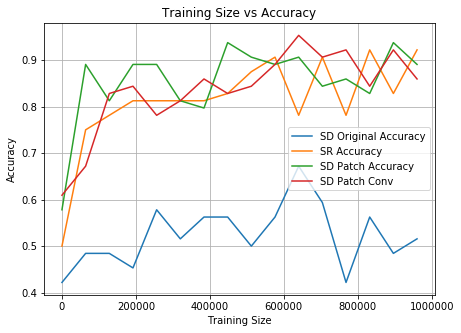

NameError: global name 'path' is not defined

In [21]:
# fig_no, training_size, accuracy, loss, start_size, end_size

generate_size_graph(1, training_size_sd_plot, accuracy_sd_plot, accuracy_sr_plot,accuracy_sd_patchonly_plot,accuracy_sd_conv_plot,  64, 960064)

### Plot Error

In [ ]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])
    
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Print Accuracy

In [ ]:
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [ ]:
train_data[:64]

In [ ]:
x_batch, y_true_batch = data.test.next_batch(64)
x_batch

In [ ]:
type(data.train.labels)

In [ ]:
[0.84375, 0.8125, 0.78125, 0.859375, 0.796875, 0.84375, 0.796875, 0.71875, 0.6875, 0.8125, 0.890625, 0.8125, 0.84375, 0.796875, 0.75, 0.890625, 0.78125, 0.859375, 0.78125, 0.78125, 0.765625, 0.828125, 0.75, 0.796875, 0.796875, 0.734375, 0.84375, 0.828125, 0.84375, 0.6875, 0.796875, 0.84375, 0.796875, 0.84375, 0.828125, 0.859375, 0.828125, 0.84375, 0.78125, 0.90625, 0.84375, 0.875, 0.65625, 0.828125, 0.828125, 0.734375, 0.84375, 0.796875, 0.875, 0.828125, 0.71875, 0.875, 0.75, 0.875, 0.828125, 0.765625, 0.84375, 0.875, 0.734375, 0.75, 0.84375, 0.84375, 0.8125, 0.796875, 0.8125, 0.828125, 0.8125, 0.8125, 0.8125, 0.859375, 0.890625, 0.859375, 0.859375, 0.75, 0.75, 0.8125, 0.78125, 0.828125, 0.84375, 0.78125, 0.78125, 0.84375, 0.8125, 0.859375, 0.796875, 0.859375, 0.875, 0.828125, 0.75, 0.84375, 0.796875, 0.90625, 0.75, 0.859375, 0.828125, 0.828125, 0.859375, 0.90625, 0.859375, 0.734375, 0.859375, 0.90625, 0.84375, 0.859375, 0.71875, 0.765625, 0.796875, 0.890625, 0.75, 0.828125, 0.828125, 0.875, 0.796875, 0.765625, 0.890625, 0.8125, 0.828125, 0.78125, 0.890625, 0.734375, 0.796875, 0.90625, 0.84375, 0.75, 0.859375, 0.8125, 0.828125, 0.890625, 0.796875, 0.859375, 0.765625, 0.84375, 0.796875, 0.78125, 0.8125, 0.734375, 0.875, 0.8125, 0.78125, 0.8125, 0.71875, 0.78125, 0.859375, 0.78125, 0.890625, 0.90625, 0.8125, 0.78125, 0.828125, 0.8125, 0.78125, 0.78125, 0.796875, 0.734375, 0.859375, 0.765625, 0.8125, 0.828125, 0.828125, 0.84375, 0.84375, 0.859375, 0.78125, 0.765625, 0.8125, 0.8125, 0.765625, 0.875, 0.8125, 0.828125, 0.875, 0.875, 0.765625, 0.796875, 0.890625, 0.828125, 0.859375, 0.734375, 0.8125, 0.765625, 0.859375, 0.78125, 0.875, 0.78125, 0.890625, 0.765625, 0.8125, 0.875, 0.84375, 0.890625, 0.796875, 0.8125, 0.828125, 0.765625, 0.8125, 0.890625, 0.859375, 0.78125, 0.828125, 0.8125, 0.96875, 0.875, 0.78125, 0.78125, 0.875, 0.703125, 0.796875, 0.875, 0.78125, 0.828125, 0.84375, 0.796875, 0.84375, 0.796875, 0.84375, 0.921875, 0.828125, 0.828125, 0.859375, 0.796875, 0.78125, 0.78125, 0.8125, 0.78125, 0.828125, 0.890625, 0.875, 0.75, 0.796875, 0.90625, 0.859375, 0.859375, 0.875, 0.8125, 0.78125, 0.90625, 0.75, 0.828125, 0.875, 0.765625, 0.828125, 0.859375, 0.859375, 0.828125, 0.78125, 0.8125, 0.8125, 0.859375, 0.84375, 0.875, 0.84375, 0.859375, 0.875, 0.828125, 0.84375, 0.796875, 0.875, 0.84375, 0.796875, 0.78125, 0.859375, 0.859375, 0.8125, 0.859375, 0.796875, 0.703125, 0.828125, 0.875, 0.859375, 0.796875, 0.828125, 0.875, 0.84375, 0.890625, 0.859375, 0.796875, 0.8125, 0.875, 0.796875, 0.859375, 0.875, 0.828125, 0.703125, 0.78125, 0.703125, 0.84375, 0.796875, 0.875, 0.890625, 0.890625, 0.8125, 0.84375, 0.78125, 0.84375, 0.84375, 0.875, 0.8125, 0.859375, 0.796875, 0.828125, 0.84375, 0.859375, 0.859375, 0.8125, 0.828125, 0.796875, 0.8125, 0.8125, 0.84375, 0.84375, 0.8125, 0.828125, 0.828125, 0.8125, 0.890625, 0.78125, 0.796875, 0.796875, 0.828125, 0.84375, 0.90625, 0.859375, 0.84375, 0.875, 0.75, 0.84375, 0.890625, 0.765625, 0.875, 0.84375, 0.84375, 0.84375, 0.859375, 0.921875, 0.75, 0.859375, 0.828125, 0.75, 0.875, 0.765625, 0.859375, 0.875, 0.78125, 0.90625, 0.75, 0.71875, 0.75, 0.859375, 0.78125, 0.78125, 0.84375, 0.875, 0.859375, 0.765625, 0.84375, 0.78125, 0.890625, 0.78125, 0.703125, 0.796875, 0.78125, 0.78125, 0.875, 0.875, 0.859375, 0.8125, 0.859375, 0.8125, 0.859375, 0.765625, 0.765625, 0.78125, 0.8125, 0.84375, 0.859375, 0.8125, 0.859375, 0.78125, 0.78125, 0.75, 0.84375, 0.765625, 0.859375, 0.78125, 0.78125, 0.8125, 0.703125, 0.828125, 0.75, 0.90625, 0.8125, 0.828125, 0.84375, 0.859375, 0.75, 0.796875, 0.890625, 0.890625, 0.78125, 0.8125, 0.71875, 0.796875, 0.859375, 0.84375, 0.859375, 0.8125, 0.828125, 0.84375, 0.8125, 0.84375, 0.828125, 0.78125, 0.8125, 0.828125, 0.8125, 0.828125, 0.765625, 0.765625, 0.765625, 0.703125, 0.828125, 0.734375, 0.875, 0.875, 0.84375, 0.8125, 0.84375, 0.734375, 0.84375, 0.890625, 0.859375, 0.8125, 0.84375, 0.859375, 0.828125, 0.765625, 0.890625, 0.84375, 0.796875, 0.890625, 0.8125, 0.734375, 0.703125, 0.921875, 0.859375, 0.90625, 0.78125, 0.84375, 0.71875, 0.828125, 0.828125, 0.84375, 0.875, 0.828125, 0.8125, 0.78125, 0.828125, 0.890625, 0.921875, 0.828125, 0.828125, 0.84375, 0.84375, 0.828125, 0.828125, 0.84375, 0.859375, 0.859375, 0.84375, 0.765625, 0.78125, 0.8125, 0.828125, 0.796875, 0.84375, 0.84375, 0.75, 0.765625, 0.890625, 0.765625, 0.859375, 0.875, 0.875, 0.734375, 0.859375, 0.796875, 0.859375, 0.859375, 0.828125, 0.84375, 0.8125, 0.71875, 0.890625, 0.828125, 0.765625, 0.84375, 0.78125, 0.90625, 0.71875, 0.828125, 0.84375, 0.796875, 0.828125, 0.875, 0.875, 0.875, 0.828125, 0.78125, 0.859375, 0.84375, 0.796875, 0.75, 0.890625, 0.8125, 0.875, 0.8125, 0.8125]
[65, 129, 193, 257, 321, 385, 449, 513, 577, 641, 705, 769, 833, 897, 961, 1025, 1089, 1153, 1217, 1281, 1345, 1409, 1473, 1537, 1601, 1665, 1729, 1793, 1857, 1921, 1985, 2049, 2113, 2177, 2241, 2305, 2369, 2433, 2497, 2561, 2625, 2689, 2753, 2817, 2881, 2945, 3009, 3073, 3137, 3201, 3265, 3329, 3393, 3457, 3521, 3585, 3649, 3713, 3777, 3841, 3905, 3969, 4033, 4097, 4161, 4225, 4289, 4353, 4417, 4481, 4545, 4609, 4673, 4737, 4801, 4865, 4929, 4993, 5057, 5121, 5185, 5249, 5313, 5377, 5441, 5505, 5569, 5633, 5697, 5761, 5825, 5889, 5953, 6017, 6081, 6145, 6209, 6273, 6337, 6401, 6465, 6529, 6593, 6657, 6721, 6785, 6849, 6913, 6977, 7041, 7105, 7169, 7233, 7297, 7361, 7425, 7489, 7553, 7617, 7681, 7745, 7809, 7873, 7937, 8001, 8065, 8129, 8193, 8257, 8321, 8385, 8449, 8513, 8577, 8641, 8705, 8769, 8833, 8897, 8961, 9025, 9089, 9153, 9217, 9281, 9345, 9409, 9473, 9537, 9601, 9665, 9729, 9793, 9857, 9921, 9985, 10049, 10113, 10177, 10241, 10305, 10369, 10433, 10497, 10561, 10625, 10689, 10753, 10817, 10881, 10945, 11009, 11073, 11137, 11201, 11265, 11329, 11393, 11457, 11521, 11585, 11649, 11713, 11777, 11841, 11905, 11969, 12033, 12097, 12161, 12225, 12289, 12353, 12417, 12481, 12545, 12609, 12673, 12737, 12801, 12865, 12929, 12993, 13057, 13121, 13185, 13249, 13313, 13377, 13441, 13505, 13569, 13633, 13697, 13761, 13825, 13889, 13953, 14017, 14081, 14145, 14209, 14273, 14337, 14401, 14465, 14529, 14593, 14657, 14721, 14785, 14849, 14913, 14977, 15041, 15105, 15169, 15233, 15297, 15361, 15425, 15489, 15553, 15617, 15681, 15745, 15809, 15873, 15937, 16001, 16065, 16129, 16193, 16257, 16321, 16385, 16449, 16513, 16577, 16641, 16705, 16769, 16833, 16897, 16961, 17025, 17089, 17153, 17217, 17281, 17345, 17409, 17473, 17537, 17601, 17665, 17729, 17793, 17857, 17921, 17985, 18049, 18113, 18177, 18241, 18305, 18369, 18433, 18497, 18561, 18625, 18689, 18753, 18817, 18881, 18945, 19009, 19073, 19137, 19201, 19265, 19329, 19393, 19457, 19521, 19585, 19649, 19713, 19777, 19841, 19905, 19969, 20033, 20097, 20161, 20225, 20289, 20353, 20417, 20481, 20545, 20609, 20673, 20737, 20801, 20865, 20929, 20993, 21057, 21121, 21185, 21249, 21313, 21377, 21441, 21505, 21569, 21633, 21697, 21761, 21825, 21889, 21953, 22017, 22081, 22145, 22209, 22273, 22337, 22401, 22465, 22529, 22593, 22657, 22721, 22785, 22849, 22913, 22977, 23041, 23105, 23169, 23233, 23297, 23361, 23425, 23489, 23553, 23617, 23681, 23745, 23809, 23873, 23937, 24001, 24065, 24129, 24193, 24257, 24321, 24385, 24449, 24513, 24577, 24641, 24705, 24769, 24833, 24897, 24961, 25025, 25089, 25153, 25217, 25281, 25345, 25409, 25473, 25537, 25601, 25665, 25729, 25793, 25857, 25921, 25985, 26049, 26113, 26177, 26241, 26305, 26369, 26433, 26497, 26561, 26625, 26689, 26753, 26817, 26881, 26945, 27009, 27073, 27137, 27201, 27265, 27329, 27393, 27457, 27521, 27585, 27649, 27713, 27777, 27841, 27905, 27969, 28033, 28097, 28161, 28225, 28289, 28353, 28417, 28481, 28545, 28609, 28673, 28737, 28801, 28865, 28929, 28993, 29057, 29121, 29185, 29249, 29313, 29377, 29441, 29505, 29569, 29633, 29697, 29761, 29825, 29889, 29953, 30017, 30081, 30145, 30209, 30273, 30337, 30401, 30465, 30529, 30593, 30657, 30721, 30785, 30849, 30913, 30977, 31041, 31105, 31169, 31233, 31297, 31361, 31425, 31489, 31553, 31617, 31681, 31745, 31809, 31873, 31937, 32001, 32065, 32129, 32193, 32257, 32321, 32385, 32449, 32513, 32577, 32641, 32705, 32769, 32833, 32897, 32961, 33025, 33089]
[0.875, 0.953125, 0.796875, 0.890625, 0.875, 0.921875, 0.9375, 0.84375, 0.90625, 0.90625, 0.8125, 0.921875, 0.84375, 0.8125, 0.890625, 0.796875, 0.890625, 0.9375, 0.90625, 0.9375, 0.890625, 0.90625, 0.828125, 0.84375, 0.90625, 0.859375, 0.890625, 0.859375, 0.8125, 0.828125, 0.875, 0.796875, 0.796875, 0.796875, 0.90625, 0.890625, 0.921875, 0.875, 0.859375, 0.890625, 0.90625, 0.953125, 0.765625, 0.90625, 0.90625, 0.84375, 0.859375, 0.84375, 0.890625, 0.890625, 0.875, 0.859375, 0.953125, 0.90625, 0.84375, 0.796875, 0.84375, 0.9375, 0.90625, 0.84375, 0.78125, 0.90625, 0.8125, 0.8125, 0.859375, 0.875, 0.953125, 0.875, 0.859375, 0.875, 0.9375, 0.90625, 0.921875, 0.890625, 0.859375, 0.890625, 0.890625, 0.859375, 0.9375, 0.859375, 0.859375, 0.828125, 0.828125, 0.875, 0.796875, 0.890625, 0.8125, 0.828125, 0.828125, 0.921875, 0.78125, 0.828125, 0.90625, 0.875, 0.796875, 0.921875, 0.8125, 0.828125, 0.8125, 0.90625, 0.90625, 0.921875, 0.796875, 0.78125, 0.875, 0.859375, 0.90625, 0.828125, 0.84375, 0.828125, 0.828125, 0.828125, 0.890625, 0.84375, 0.953125, 0.828125, 0.890625, 0.859375, 0.9375, 0.921875, 0.859375, 0.859375, 0.921875, 0.890625, 0.90625, 0.828125, 0.90625, 0.859375, 0.921875, 0.90625, 0.90625, 0.921875, 0.828125, 0.859375, 0.890625, 0.859375, 0.890625, 0.9375, 0.765625, 0.859375, 0.8125, 0.859375, 0.84375, 0.90625, 0.90625, 0.828125, 0.859375, 0.90625, 0.84375, 0.875, 0.9375, 0.9375, 0.90625, 0.890625, 0.9375, 0.84375, 0.828125, 0.859375, 0.84375, 0.84375, 0.84375, 0.859375, 0.84375, 0.828125, 0.875, 0.921875, 0.875, 0.921875, 0.8125, 0.875, 0.875, 0.875, 0.84375, 0.875, 0.84375, 0.9375, 0.765625, 0.875, 0.890625, 0.828125, 0.875, 0.84375, 0.84375, 0.984375, 0.859375, 0.859375, 0.890625, 0.875, 0.828125, 0.9375, 0.875, 0.84375, 0.875, 0.875, 0.921875, 0.875, 0.921875, 0.875, 0.890625, 0.828125, 0.90625, 0.828125, 0.890625, 0.875, 0.796875, 0.765625, 0.9375, 0.859375, 0.921875, 0.875, 0.875, 0.875, 0.890625, 0.890625, 0.796875, 0.875, 0.875, 0.796875, 0.859375, 0.859375, 0.8125, 0.9375, 0.859375, 0.890625, 0.90625, 0.859375, 0.890625, 0.921875, 0.8125, 0.921875, 0.875, 0.859375, 0.875, 0.875, 0.828125, 0.828125, 0.875, 0.90625, 0.90625, 0.859375, 0.875, 0.953125, 0.875, 0.828125, 0.9375, 0.828125, 0.8125, 0.90625, 0.921875, 0.828125, 0.875, 0.890625, 0.921875, 0.890625, 0.796875, 0.84375, 0.875, 0.828125, 0.8125, 0.890625, 0.828125, 0.90625, 0.8125, 0.84375, 0.859375, 0.90625, 0.859375, 0.890625, 0.90625, 0.859375, 0.828125, 0.890625, 0.921875, 0.859375, 0.78125, 0.890625, 0.859375, 0.84375, 0.859375, 0.890625, 0.84375, 0.828125, 0.890625, 0.921875, 0.921875, 0.828125, 0.921875, 0.84375, 0.84375, 0.875, 0.90625, 0.875, 0.875, 0.84375, 0.90625, 0.921875, 0.921875, 0.90625, 0.84375, 0.890625, 0.8125, 0.734375, 0.9375, 0.84375, 0.875, 0.8125, 0.90625, 0.90625, 0.828125, 0.90625, 0.921875, 0.890625, 0.875, 0.875, 0.859375, 0.875, 0.765625, 0.828125, 0.890625, 0.875, 0.890625, 0.875, 0.890625, 0.875, 0.8125, 0.875, 0.84375, 0.875, 0.921875, 0.84375, 0.875, 0.84375, 0.84375, 0.90625, 0.90625, 0.921875, 0.859375, 0.859375, 0.828125, 0.953125, 0.84375, 0.875, 0.953125, 0.875, 0.84375, 0.84375, 0.875, 0.84375, 0.84375, 0.859375, 0.90625, 0.875, 0.921875, 0.90625, 0.765625, 0.84375, 0.859375, 0.859375, 0.84375, 0.890625, 0.828125, 0.8125, 0.84375, 0.90625, 0.890625, 0.8125, 0.890625, 0.828125, 0.90625, 0.875, 0.828125, 0.8125, 0.765625, 0.890625, 0.859375, 0.859375, 0.984375, 0.84375, 0.859375, 0.875, 0.921875, 0.890625, 0.96875, 0.828125, 0.84375, 0.84375, 0.90625, 0.890625, 0.875, 0.90625, 0.875, 0.9375, 0.859375, 0.84375, 0.8125, 0.828125, 0.890625, 0.84375, 0.875, 0.890625, 0.828125, 0.859375, 0.859375, 0.875, 0.890625, 0.859375, 0.875, 0.890625, 0.890625, 0.9375, 0.921875, 0.90625, 0.921875, 0.859375, 0.828125, 0.828125, 0.828125, 0.828125, 0.765625, 0.8125, 0.796875, 0.84375, 0.8125, 0.84375, 0.875, 0.828125, 0.8125, 0.84375, 0.90625, 0.875, 0.859375, 0.84375, 0.875, 0.890625, 0.921875, 0.796875, 0.859375, 0.859375, 0.90625, 0.859375, 0.828125, 0.84375, 0.828125, 0.90625, 0.84375, 0.875, 0.953125, 0.828125, 0.875, 0.921875, 0.890625, 0.8125, 0.90625, 0.8125, 0.875, 0.8125, 0.84375, 0.90625, 0.90625, 0.859375, 0.84375, 0.875, 0.859375, 0.828125, 0.875, 0.8125, 0.890625, 0.875, 0.8125, 0.875, 0.859375, 0.875, 0.875, 0.828125, 0.921875, 0.828125, 0.828125, 0.953125, 0.828125, 0.859375, 0.875, 0.890625, 0.90625, 0.796875, 0.859375, 0.890625, 0.859375, 0.859375, 0.84375, 0.90625, 0.8125, 0.875, 0.875, 0.859375, 0.828125, 0.890625, 0.890625, 0.875, 0.84375, 0.84375, 0.921875, 0.828125, 0.859375, 0.890625, 0.875, 0.890625, 0.859375, 0.859375, 0.84375, 0.84375, 0.875, 0.890625, 0.875, 0.859375, 0.84375, 0.875, 0.8125]
[65, 129, 193, 257, 321, 385, 449, 513, 577, 641, 705, 769, 833, 897, 961, 1025, 1089, 1153, 1217, 1281, 1345, 1409, 1473, 1537, 1601, 1665, 1729, 1793, 1857, 1921, 1985, 2049, 2113, 2177, 2241, 2305, 2369, 2433, 2497, 2561, 2625, 2689, 2753, 2817, 2881, 2945, 3009, 3073, 3137, 3201, 3265, 3329, 3393, 3457, 3521, 3585, 3649, 3713, 3777, 3841, 3905, 3969, 4033, 4097, 4161, 4225, 4289, 4353, 4417, 4481, 4545, 4609, 4673, 4737, 4801, 4865, 4929, 4993, 5057, 5121, 5185, 5249, 5313, 5377, 5441, 5505, 5569, 5633, 5697, 5761, 5825, 5889, 5953, 6017, 6081, 6145, 6209, 6273, 6337, 6401, 6465, 6529, 6593, 6657, 6721, 6785, 6849, 6913, 6977, 7041, 7105, 7169, 7233, 7297, 7361, 7425, 7489, 7553, 7617, 7681, 7745, 7809, 7873, 7937, 8001, 8065, 8129, 8193, 8257, 8321, 8385, 8449, 8513, 8577, 8641, 8705, 8769, 8833, 8897, 8961, 9025, 9089, 9153, 9217, 9281, 9345, 9409, 9473, 9537, 9601, 9665, 9729, 9793, 9857, 9921, 9985, 10049, 10113, 10177, 10241, 10305, 10369, 10433, 10497, 10561, 10625, 10689, 10753, 10817, 10881, 10945, 11009, 11073, 11137, 11201, 11265, 11329, 11393, 11457, 11521, 11585, 11649, 11713, 11777, 11841, 11905, 11969, 12033, 12097, 12161, 12225, 12289, 12353, 12417, 12481, 12545, 12609, 12673, 12737, 12801, 12865, 12929, 12993, 13057, 13121, 13185, 13249, 13313, 13377, 13441, 13505, 13569, 13633, 13697, 13761, 13825, 13889, 13953, 14017, 14081, 14145, 14209, 14273, 14337, 14401, 14465, 14529, 14593, 14657, 14721, 14785, 14849, 14913, 14977, 15041, 15105, 15169, 15233, 15297, 15361, 15425, 15489, 15553, 15617, 15681, 15745, 15809, 15873, 15937, 16001, 16065, 16129, 16193, 16257, 16321, 16385, 16449, 16513, 16577, 16641, 16705, 16769, 16833, 16897, 16961, 17025, 17089, 17153, 17217, 17281, 17345, 17409, 17473, 17537, 17601, 17665, 17729, 17793, 17857, 17921, 17985, 18049, 18113, 18177, 18241, 18305, 18369, 18433, 18497, 18561, 18625, 18689, 18753, 18817, 18881, 18945, 19009, 19073, 19137, 19201, 19265, 19329, 19393, 19457, 19521, 19585, 19649, 19713, 19777, 19841, 19905, 19969, 20033, 20097, 20161, 20225, 20289, 20353, 20417, 20481, 20545, 20609, 20673, 20737, 20801, 20865, 20929, 20993, 21057, 21121, 21185, 21249, 21313, 21377, 21441, 21505, 21569, 21633, 21697, 21761, 21825, 21889, 21953, 22017, 22081, 22145, 22209, 22273, 22337, 22401, 22465, 22529, 22593, 22657, 22721, 22785, 22849, 22913, 22977, 23041, 23105, 23169, 23233, 23297, 23361, 23425, 23489, 23553, 23617, 23681, 23745, 23809, 23873, 23937, 24001, 24065, 24129, 24193, 24257, 24321, 24385, 24449, 24513, 24577, 24641, 24705, 24769, 24833, 24897, 24961, 25025, 25089, 25153, 25217, 25281, 25345, 25409, 25473, 25537, 25601, 25665, 25729, 25793, 25857, 25921, 25985, 26049, 26113, 26177, 26241, 26305, 26369, 26433, 26497, 26561, 26625, 26689, 26753, 26817, 26881, 26945, 27009, 27073, 27137, 27201, 27265, 27329, 27393, 27457, 27521, 27585, 27649, 27713, 27777, 27841, 27905, 27969, 28033, 28097, 28161, 28225, 28289, 28353, 28417, 28481, 28545, 28609, 28673, 28737, 28801, 28865, 28929, 28993, 29057, 29121, 29185, 29249, 29313, 29377, 29441, 29505, 29569, 29633, 29697, 29761, 29825, 29889, 29953, 30017, 30081, 30145, 30209, 30273, 30337, 30401, 30465, 30529, 30593, 30657, 30721, 30785, 30849, 30913, 30977, 31041, 31105, 31169, 31233, 31297, 31361, 31425, 31489, 31553, 31617, 31681, 31745, 31809, 31873, 31937, 32001, 32065, 32129, 32193, 32257, 32321, 32385, 32449, 32513, 32577, 32641, 32705, 32769, 32833, 32897, 32961, 33025, 33089]

In [ ]:
[0.682583252895753, 0.7848998552123552, 0.8154862451737451, 0.823871862934363, 0.8351532335907336, 0.838531611969112, 0.8439611486486487, 0.8454391891891891, 0.8443532818532818, 0.8474601833976834, 0.8517434845559846, 0.8527992277992278, 0.8534930019305019, 0.8545789092664092, 0.8536438223938224, 0.8558458011583011, 0.8557251447876448, 0.8581081081081081, 0.8593448359073359, 0.8613055019305019, 0.8607625482625483, 0.8619087837837838, 0.8626930501930502, 0.86652388996139, 0.8641710907335908, 0.8649855212355212, 0.8659809362934363, 0.868846525096525, 0.8675494691119691, 0.8706865347490348]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
[0.682583252895753, 0.7848998552123552, 0.8154862451737451, 0.823871862934363, 0.8351532335907336, 0.838531611969112, 0.8439611486486487, 0.8454391891891891, 0.8443532818532818, 0.8474601833976834, 0.8517434845559846, 0.8527992277992278, 0.8534930019305019, 0.8545789092664092, 0.8536438223938224, 0.8558458011583011, 0.8557251447876448, 0.8581081081081081, 0.8593448359073359, 0.8613055019305019, 0.8607625482625483, 0.8619087837837838, 0.8626930501930502, 0.86652388996139, 0.8641710907335908, 0.8649855212355212, 0.8659809362934363, 0.868846525096525, 0.8675494691119691, 0.8706865347490348]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

In [ ]:
accuracy_sd = [0.5181587837837838, 0.5230755308880309, 0.5339346042471043, 0.5334218146718147, 0.5387910231660231, 0.5470258204633205, 0.5545668436293436, 0.567386583011583, 0.5835847007722008, 0.6008083976833977, 0.619449806949807, 0.6399915540540541, 0.6607142857142857, 0.6763694498069498, 0.6886763996138996, 0.699867277992278, 0.7165178571428571, 0.7225808397683398, 0.7372104247104247, 0.7440878378378378, 0.753921332046332, 0.7609797297297297, 0.7618544884169884, 0.7700289575289575, 0.7795004826254827, 0.783210666023166, 0.7914152992277992, 0.7912946428571429, 0.800132722007722, 0.8066180019305019]

In [27]:
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
accuracy_patch = [0.682583252895753, 0.7848998552123552, 0.8154862451737451, 0.823871862934363, 0.8351532335907336, 0.838531611969112, 0.8439611486486487, 0.8454391891891891, 0.8443532818532818, 0.8474601833976834, 0.8517434845559846, 0.8527992277992278, 0.8534930019305019, 0.8545789092664092, 0.8536438223938224, 0.8558458011583011, 0.8557251447876448, 0.8581081081081081, 0.8593448359073359, 0.8613055019305019, 0.8607625482625483, 0.8619087837837838, 0.8626930501930502, 0.86652388996139, 0.8641710907335908, 0.8649855212355212, 0.8659809362934363, 0.868846525096525, 0.8675494691119691, 0.8706865347490348]
accuracy_patch_honest = [0.5964508642765685, 0.685759443021767, 0.7221510883482715, 0.7329745518565941, 0.7377560819462228, 0.7417373559539052, 0.7426176376440461, 0.7411371638924455, 0.7472391165172856, 0.7490196862996159, 0.7513404289372599, 0.751280409731114, 0.7525808258642765, 0.7539412612035852, 0.7538012163892446, 0.7568221830985915, 0.7538012163892446, 0.7589828745198464, 0.7596830985915493, 0.7593629961587708, 0.7561219590268886, 0.7599631882202305, 0.7578625160051217, 0.7599631882202305, 0.7632842509603073, 0.765685019206146, 0.7645646606914213, 0.7671854993597952, 0.7670454545454546, 0.7695062419974392]
accuracy_sd = [0.5181587837837838, 0.5230755308880309, 0.5339346042471043, 0.5334218146718147, 0.5387910231660231, 0.5470258204633205, 0.5545668436293436, 0.567386583011583, 0.5835847007722008, 0.6008083976833977, 0.619449806949807, 0.6399915540540541, 0.6607142857142857, 0.6763694498069498, 0.6886763996138996, 0.699867277992278, 0.7165178571428571, 0.7225808397683398, 0.7372104247104247, 0.7440878378378378, 0.753921332046332, 0.7609797297297297, 0.7618544884169884, 0.7700289575289575, 0.7795004826254827, 0.783210666023166, 0.7914152992277992, 0.7912946428571429, 0.800132722007722, 0.8066180019305019]

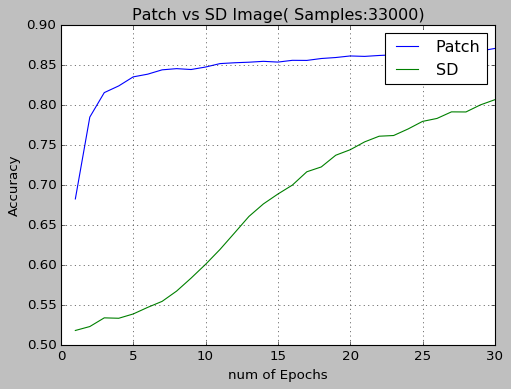

In [96]:
generate_graph(1, training_size_sd_plot, accuracy_patch, accuracy_sd, "Accuracy", "Patch", "SD Image", 33000)

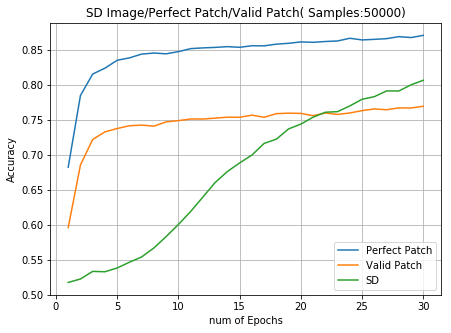

In [29]:
    plt.figure(1,figsize=(7,5))
    plt.plot(epochs,accuracy_patch)
    plt.plot(epochs,accuracy_patch_honest)
    plt.plot(epochs,accuracy_sd)    
    plt.xlabel('num of Epochs')
    plt.ylabel("Accuracy")
    plt.title("SD Image/Perfect Patch/Valid Patch" + '( Samples:' + str(50000) + ')')
    plt.grid(True)
    plt.legend(['Perfect Patch','Valid Patch', 'SD'])
    plt.style.use(['classic'])
    plt.show()